### Bartholomew_Luke_DA201_Assignment_Notebook <a id='top'></a>

## Diagnostic Analysis of NHS Data Using Python

Welcome to my Jupyter Notebook. The following sections should be completed in order:

1. <a class="anchor" href='#1'>Files Required</a>
2. <a class="anchor" href='#2'>Library Dependencies</a>
3. <a class="anchor" href='#3'>Connect To The Database</a>
4. <a class="anchor" href='#4'>Import / Export The Data</a>
5. <a class="anchor" href='#5'>Describe The Data</a>
6. <a class="anchor" href='#6'>Data Wrangling</a>
7. <a class="anchor" href='#7'>Analyse The Data</a>
8. <a href='#8'>Visualise & Identify Trends</a>
9. <a href='#9'>Analyse The Twitter Data</a>
10. <a href='#10'>Recommendations</a>

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">1. Files Required</h2></th>
        <th><a id="1"></a></th>
    </tr>
</thead>
</table>

This notebook requires the `actual_duration.csv` and `appointments_regional.csv`, `national_categories.xlsx`, `icb_locations.csv`, `tweets.csv`  and `metadata_nhs.txt` files. Upload these files to the directory before you begin.

`icb_locations.csv` data extracted from [ONS (Office for National Statistics) Geography][id16] portal. Population and GP (General Practitioner) data related to ICB Locations downloaded from June 2022 can be downloaded at the [NHS Website][id19]. This file has been added to the GitHub repository.


<b>Geographical and shape data</b> used by Geopandas can be downloaded from the NHS website:
- [ICB Locations][id17]
- [Region Locations][id18]

The files, this Jupyter notebook and technical report can be accessed at the [GitHub repository][id2].

> <b>NOTE:</b> Futher reading on the topic of appointments in General Practice can be found here:
>- [Appointments in General Practice: June 2022][id20]
>- [Supporting Information][id21]
>- [Standardised GP Appointment Categories 2021/22][id23]
>- [Metadata][id22]

[id2]:https://github.com/lukebart/Bartholomew_Luke_DA201_Assignment
[id16]:https://geoportal.statistics.gov.uk/datasets/2bca16d4f8e4426d80137213fce90bbd_0/explore
[id17]:https://geoportal.statistics.gov.uk/datasets/ons::integrated-care-boards-april-2023-en-bsc-2/explore?location=52.832374%2C-2.374080%2C8.49
[id18]:https://geoportal.statistics.gov.uk/datasets/ons::nhs-england-regions-july-2022-en-bfc-1/explore?location=52.750025%2C-2.489483%2C8.00&showTable=true
[id19]:https://www.england.nhs.uk/wp-content/uploads/2022/04/integrated-care-board-allocation-core-services.xlsx
[id20]:https://digital.nhs.uk/data-and-information/publications/statistical/appointments-in-general-practice/june-2022
[id21]:https://digital.nhs.uk/data-and-information/publications/statistical/appointments-in-general-practice/appointments-in-general-practice-supporting-information
[id22]:https://digital.nhs.uk/data-and-information/publications/statistical/appointments-in-general-practice/metadata
[id23]:https://www.england.nhs.uk/publication/gpad-appointment-categorisation-guidance-2021-22/

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">2. Library Dependencies</h2></th>
        <th><a id="2"></a></th>
    </tr>
</thead>
</table>

The following libraries will need to be installed for this notebook to work:
- [Numpy][id3]
- [Pandas][id4]
- [Datetime][id5]
- [Matplotlib][id6]
- [Seaborn][id7]
- [Geopandas][id8] > [Installation Guide][id9]
- [Jupyter Notebook][id10]
- [Openpyxl][id11]
- [Ipython-sql][id12]
- [Sqlalchemy][id13]
- [Psycopg2][id14]
- [Dotenv][id15]

[id3]:https://anaconda.org/conda-forge/numpy
[id4]:https://anaconda.org/conda-forge/pandas
[id5]:https://anaconda.org/trentonoliphant/datetime
[id6]:https://anaconda.org/conda-forge/matplotlib
[id7]:https://anaconda.org/conda-forge/seaborn
[id8]:https://anaconda.org/conda-forge/geopandas
[id9]:https://geopandas.org/en/stable/getting_started/install.html
[id10]:https://anaconda.org/conda-forge/notebook
[id11]:https://anaconda.org/conda-forge/openpyxl
[id12]:https://anaconda.org/conda-forge/ipython-sql
[id13]:https://anaconda.org/conda-forge/sqlalchemy
[id14]:https://anaconda.org/conda-forge/psycopg2
[id15]:https://anaconda.org/conda-forge/python-dotenv


### Import Libraries

<div class="alert alert-block alert-danger">
<b>Important:</b> Run the code below before going further.
</div>

In [1]:
# Import basic data anaylsis libraries
import numpy as np
import pandas as pd
import datetime as dt

# Import charting libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mtick
from matplotlib.dates import *
from matplotlib.ticker import (MultipleLocator, NullFormatter, \
                               FormatStrFormatter, AutoMinorLocator)
import seaborn as sns

# Import libraries os and dotenv to read .env file
import os
from dotenv import load_dotenv

# Import SQL libraries to create an engine and inspect the data
from sqlalchemy import create_engine
from sqlalchemy import inspect

# Import Geopandas
import geopandas as gpd

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th width="80%"><h2 style="text-align:left">3. Connect To The Database</h2></th>
        <th><a id="3"></a><a class="anchor" href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

<div class="alert alert-block alert-success">
<b>Create Database:</b> Create a new database in PgAdmin named 'nhs_data'. This will be used as a repository for the wrangled datasets, so that it will easier to retrieve specific datasets at any time.
</div>


In [2]:
# Load environment variables from .env file
load_dotenv('pw.env')

# Read the password from your .env file.
pgadmin_pw = os.getenv('pgadmin_pw')

In [3]:
# PostgreSQL credentials
host = 'localhost'
database = 'nhs_data'
user = 'postgres'

# Your own password
password = pgadmin_pw

# Test connection between PostgreSQL and Jupyter Notebook
connection_string = f"postgresql://{user}:{password}@{host}/{database}"

# Name the engine.
engine = create_engine(connection_string)

In [4]:
# List tables in database
insp = inspect(engine)
insp.get_table_names()

['nc',
 'ad',
 'ar',
 'ar_groupby_month',
 'ar_subset_post_covid',
 'ar_pivot_icb_status',
 'ar_post_covid',
 'ar_pivot_mode_status',
 'ar_pivot_region_status',
 'ar_pivot_time_status',
 'actual_duration',
 'appointments_regional',
 'icb_locations',
 'tweets',
 'national_categories']

> <b>NOTE:</b> The database will return empty until the tables have been created. This will be done in the <a class="anchor" href='#6'>Data Wrangling</a> section.

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">4. Import / Export The Data</h2></th>
        <th><a id="4"></a><a class="anchor" href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

<div class="alert alert-block alert-danger">
<b>Important:</b> Skip this section if the raw data from the files (.csv, .xlsx) has already been exported to the database. Go to <a class="anchor" href='#5'>Describe The Data</a> section.
</div>

### ERD (Entity Relationship Diagram)

<img src="erd.png" alt="ERD">

### Import .csv and .xlsx Files

In [5]:
# Read the CSV files
ad_raw = pd.read_csv('actual_duration.csv')
ar_raw = pd.read_csv('appointments_regional.csv')
loc_raw = pd.read_csv('icb_locations.csv')
tweets_raw = pd.read_csv('tweets.csv')

In [6]:
# Read the Excel file
nc_raw = pd.read_excel('national_categories.xlsx')

### Export files to database tables

In [7]:
# Write actual_duration.csv data into the table in postgresql database
ad_raw.to_sql('actual_duration', engine, if_exists='replace', index=False)

# Write appointments_regional.csv data into the table in postgresql database
ar_raw.to_sql('appointments_regional', engine, if_exists='replace', index=False)

# Write icb_locations.csv data into the table in postgresql database
loc_raw.to_sql('icb_locations', engine, if_exists='replace', index=False)

# Write tweets_raw.csv data into the table in postgresql database
tweets_raw.to_sql('tweets', engine, if_exists='replace', index=False)

174

In [8]:
# Write national_categories.xlsx data into the table in postgresql database
nc_raw.to_sql('national_categories', engine, if_exists='replace', index=False)

394

### Check tables exist in database

In [9]:
# List tables in database
insp = inspect(engine)
insp.get_table_names()

['ar_post_covid',
 'ar_groupby_month',
 'ar_subset_post_covid',
 'ar_pivot_icb_status',
 'ar_pivot_region_status',
 'ar_pivot_mode_status',
 'ar_pivot_time_status',
 'actual_duration',
 'appointments_regional',
 'icb_locations',
 'tweets',
 'national_categories',
 'nc',
 'ad',
 'ar']

### Query a table and return head

In [10]:
# Read the national_categories table from the database
nc_sql = pd.read_sql('SELECT * from national_categories ORDER BY appointment_date', engine)

In [11]:
# show the head
nc_sql.head()

appointment_date icb_ons_code                       sub_icb_location_name   
0       2021-08-01    E54000048  NHS Lancashire and South Cumbria ICB - 00X  \
1       2021-08-01    E54000048  NHS Lancashire and South Cumbria ICB - 00X   
2       2021-08-01    E54000057            NHS Greater Manchester ICB - 00T   
3       2021-08-01    E54000048  NHS Lancashire and South Cumbria ICB - 00X   
4       2021-08-01    E54000057            NHS Greater Manchester ICB - 01G   

             service_setting            context_type   
0           General Practice  Care Related Encounter  \
1  Extended Access Provision  Care Related Encounter   
2           General Practice    Inconsistent Mapping   
3           General Practice  Care Related Encounter   
4           General Practice  Care Related Encounter   

              national_category  count_of_appointments appointment_month  
0    General Consultation Acute                     11           2021-08  
1  General Consultation Routine                     13           2021-08  
2          Inconsistent Mapping                      9           2021-08  
3  General Consultation Routine                     32           2021-08  
4    General Consultation Acute                     17           2021-08

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">5. Describe The Data</h2></th>
        <th><a id="5"></a><a class="anchor" href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

Sense-check the <b>raw data</b> from the imported from the files using Pandas DataFrames. Determine (a) column names, number of rows and columns, data types and number of missing values, and (b) descriptive statistics and metadata of each DataFrame.

### Functions

<b>NOTE:</b> In order to avoid repetition, I wrote a function used to describe the imported data. Rather than count the number of records by location or category, I used the calculation of the sum of appointments as I thought this would be a more insightful measure. <a id="55"></a>

In [12]:
# Function to describe data in the dataframe (mini version)
# df = DataFrame object (dataframe)
# df_sum = Column to sum (string)
def describe_data_mini(df, df_sum):
    # Check shape of dataframe
    print(df.shape)
    
    # missing values
    df_na = df[df.isna().any(axis=1)]
    print(df_na.shape)
    
    # Check info of dataframe
    print(df.info())
    
    # return head of dataframe
    return df.head(3).style.bar(subset=[df_sum], color='#CCCCCC')

In [13]:
# Function to describe data in the dataframe
# df = DataFrame object (dataframe)
# df_name = Name of the file the DataFrame object created from (string)
# df_columns = List of columns to describe unique values (list)
# df_sum = Column to sum (string)
# df_head = Show number of rows (integer)
def describe_data(df, df_name, df_columns, df_sum, df_head):
    print(f"Shape of DataFrame {df_name}:")
    print(df.shape)
    print('\n')
    print(f"Info of DataFrame {df_name}:")
    print(df.info())
    print('\n')
    #print(f"Head of DataFrame {df_name}:")
    #print(df.head())
    #print('\n')
    #print(f"Tail of DataFrame {df_name}:")
    #print(df.tail())
    #print('\n')
    print(f"Describe DataFrame {df_name}:")
    print(df.describe())
    print('\n')
    df_na = df[df.isna().any(axis=1)]  # missing values
    print(f"Missing values in DataFrame {df_name}:")
    print(df_na.shape)
    print('\n')
    # loop df_columns
    for col_name in df_columns:
        # Show unique values by col_name
        print(f"Unique count for {col_name} of DataFrame {df_name}: ")
        print(df[col_name].unique())
        print(df[col_name].nunique())
        print('\n')
        # Show sum of column df_sum by col_name
        print(f"Sum {df_sum} by {col_name} of DataFrame {df_name} (top {df_head}): ")
        print(df.groupby(col_name).aggregate({df_sum : 'sum'}).
              sort_values(by=[df_sum], ascending=False).head(df_head))
        print('\n')
    print(f"Head of DataFrame {df_name}:")
    return df.head(5).style.bar(subset=[df_sum], color='#CCCCCC')

### Describe actual_duration.csv

In [14]:
# Call function to describe data in actual_duration.csv
describe_data(ad_raw,'actual_duration.csv',['sub_icb_location_ons_code',
                                            'icb_ons_code',
                                            'region_ons_code',
                                            'actual_duration'],
                                            'count_of_appointments',10)

Shape of DataFrame actual_duration.csv:
(137793, 8)


Info of DataFrame actual_duration.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137793 entries, 0 to 137792
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   sub_icb_location_code      137793 non-null  object
 1   sub_icb_location_ons_code  137793 non-null  object
 2   sub_icb_location_name      137793 non-null  object
 3   icb_ons_code               137793 non-null  object
 4   region_ons_code            137793 non-null  object
 5   appointment_date           137793 non-null  object
 6   actual_duration            137793 non-null  object
 7   count_of_appointments      137793 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 8.4+ MB
None


Describe DataFrame actual_duration.csv:
       count_of_appointments
count          137793.000000
mean             1219.080011
std              1546.902956
min                 1.00

### Describe appointments_regional.csv

In [15]:
# Call function to describe data in appointments_regional.csv
describe_data(ar_raw,'appointments_regional.csv',['icb_ons_code',
                                                  'appointment_status', 
                                                  'hcp_type', 
                                                  'appointment_mode',
                                                  'time_between_book_and_appointment'],
                                                  'count_of_appointments',10)

Shape of DataFrame appointments_regional.csv:
(596821, 7)


Info of DataFrame appointments_regional.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data columns (total 7 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   icb_ons_code                       596821 non-null  object
 1   appointment_month                  596821 non-null  object
 2   appointment_status                 596821 non-null  object
 3   hcp_type                           596821 non-null  object
 4   appointment_mode                   596821 non-null  object
 5   time_between_book_and_appointment  596821 non-null  object
 6   count_of_appointments              596821 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 31.9+ MB
None


Describe DataFrame appointments_regional.csv:
       count_of_appointments
count          596821.000000
mean             1244.601857
std              5

### Describe national_categories.xlsx

In [16]:
# Call function to describe data in national_categories.xlsx
describe_data(nc_raw,'national_categories.xlsx', ['sub_icb_location_name',
                                                  'icb_ons_code',
                                                  'service_setting', 
                                                  'context_type', 
                                                  'national_category'],
                                                  'count_of_appointments',10)

Shape of DataFrame national_categories.xlsx:
(817394, 8)


Info of DataFrame national_categories.xlsx:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817394 entries, 0 to 817393
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   appointment_date       817394 non-null  datetime64[ns]
 1   icb_ons_code           817394 non-null  object        
 2   sub_icb_location_name  817394 non-null  object        
 3   service_setting        817394 non-null  object        
 4   context_type           817394 non-null  object        
 5   national_category      817394 non-null  object        
 6   count_of_appointments  817394 non-null  int64         
 7   appointment_month      817394 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 49.9+ MB
None


Describe DataFrame national_categories.xlsx:
                    appointment_date  count_of_appointments
count

['Care Related Encounter' 'Unmapped' 'Inconsistent Mapping']
3


Sum count_of_appointments by context_type of DataFrame national_categories.xlsx (top 10): 
                        count_of_appointments
context_type                                 
Care Related Encounter              257075158
Inconsistent Mapping                 27890802
Unmapped                             11080810


Unique count for national_category of DataFrame national_categories.xlsx: 
['Patient contact during Care Home Round' 'Planned Clinics' 'Home Visit'
 'General Consultation Acute' 'Structured Medication Review'
 'Care Home Visit' 'Unmapped' 'Clinical Triage'
 'Planned Clinical Procedure' 'Inconsistent Mapping'
 'Care Home Needs Assessment & Personalised Care and Support Planning'
 'General Consultation Routine'
 'Service provided by organisation external to the practice'
 'Unplanned Clinical Activity' 'Social Prescribing Service'
 'Non-contractual chargeable work'
 'Group Consultation and Group Education' '

### Describe icb_locations.csv

In [17]:
# Call function to describe data in icb_locations.csv
describe_data(loc_raw,'icb_locations.csv', ['icb_ons_code',
                                            'region_ons_name'],
                                            'gps_by_icb',10)

Shape of DataFrame icb_locations.csv:
(42, 10)


Info of DataFrame icb_locations.csv:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 10 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   icb_ons_code                            42 non-null     object 
 1   icb_ons_name                            42 non-null     object 
 2   region_ons_code                         42 non-null     object 
 3   region_ons_name                         42 non-null     object 
 4   icb_registered_population_2021_2022     42 non-null     int64  
 5   region_registered_population_2021_2022  42 non-null     int64  
 6   gps_by_icb                              42 non-null     int64  
 7   gps_by_region                           42 non-null     int64  
 8   gp_per_100000                           42 non-null     float64
 9   gb_per_100000_region                    42 non-

### Dataset actual_duration.csv

- shape, head() and tail() confirms the total rows to be 137,793 and 8 columns.
- info() shows appointment_date column has object datatype, this will need to be changed to datetime.
- isna() show no missing values.
- Unique count of locations shows sub_icb_location_ons_code = 106, icb_ons_code = 42 & region_ons_code = 7.
- sub_icb_location_ons_code 'E38000256' has the highest sum of appointments = 6,976,986
- icb_ons_code 'E54000050' has the highest sum of appointments = 9,584,943
- region_ons_code 'E40000011' has the highest sum of appointments = 32,574,555
- actual_duration category by highest sum of appointments is 'Unknown / Data Quality'. Most appointments are completed within 15 minutes. I will be able to write a script to calculate the percentage of appointments completed within 15 minutes. Why do some appointments take over 30 minutes (over 9 million)?

> Notes: The dataset does not contain descriptive information for the locations (icb_ons_code, region_ons_code). I will need to wrangle the data to include this information to that it be presented informatively in a chart or table.

### Dataset appointments_regional.csv

- shape, head() and tail() confirms there are 596,821 rows and 7 columns.
- info() shows appointment_month column has object datatype, this will need to be changed to datetime with format "01/01/2020"
- isna() show no missing values.
- Unique count of locations shows icb_ons_code = 42.
- icb_ons_code 'E54000050' has the highest sum of appointments = 43,083,535
- hcp_type shows sum of appointments by GP and Other Practice Staff not signifcantly different (379,650,140 vs. 339,650,525)
- appointment_status 'DNA' (Did Not Attend) is direct interest to our analysis. DNA sum of appointments = 30,911,233
- appointment_mode 'Face-to-Face' has the highest sum of appointments = 439,981,729
- time_between_book_and_appointment category by highest sum of appointments is 'Same Day'. Most appointments seen within 1 week. - Would be good to investigate any relationships between these categories and 'DNA' in appointment_status.

> Notes: The dataset does not contain descriptive information for the location icb_ons_code. I will need to wrangle the data to include this information to that it be presented informatively in a chart or table. The location data is limited to ICB and not Sub-ICB. There are also no specific days, date will only be available by month and year in format "01/01/2020".

### Dataset national_categories.xlsx

- shape, head() and tail() confirms there are 817,394 rows and 8 columns.
- info() shows appointment_month column has object datatype, this will need to be changed to datetime with format "01/01/2020"
- isna() show no missing values.
- Unique count of locations shows sub_icb_location_name = 106 & icb_ons_code = 42.
- sub_icb_location_name 'NHS North West London ICB - W2U3Z' has the highest sum of appointments = 12,142,390
- icb_ons_code 'E54000050' has the highest sum of appointments = 16,882,235
- service_setting 'General Practice' has by far the highest sum of appointments = 270,811,691
- context_type is unlikely to be usable due to 'Inconsistent Mapping' and 'Unmapped' making up 2 of the 3 categories.
- national_category 'General Consultation Routine' has the highest sum of appointments = 97,271,522. These categories could be useful to determine the use of resources in the NHS.

> Notes: The dataset does not contain descriptive information for the location icb_ons_code. I will need to wrangle the data to include this information to that it be presented informatively in a chart or table. The complete date (including day) is available for time series analysis.

<span style="font-family:Helvetica">
<h3><u>Answer the Questions</u></h3>
<br>
<b>Question 1. How many locations are there in the data set?</b>
   
<ul>
    <li>Sub-ICB Locations = 106</li>
    <li>ICB = 42</li>
    <li>Region = 7</li>
</ul>

<blockquote>The number of locations by Sub-ICB, ICB & Region was cross-referenced 
    with official statistics on the UK Government 
    <a href="https://geoportal.statistics.gov.uk/datasets/2bca16d4f8e4426d80137213fce90bbd_0/explore" target="_blank">website</a>.
    </blockquote>
    

<b>Question 2. What are the five locations with the highest number of records?</b>

<blockquote>This was calculated as the sum of count_of_appointments by sub_icb_location_name from the dataset national_categories.xlsx.</blockquote>

<table>
<thead>
    <tr><th>sub_icb_location_name</th><th>count_of_appointments</th></tr>
</thead>
<tbody>
    <tr><td>NHS North West London ICB - W2U3Z</td><td>12142390</td></tr>
    <tr><td>NHS North East London ICB - A3A8R</td><td>9588891</td></tr>
    <tr><td>NHS Kent and Medway ICB - 91Q</td><td>9286167</td></tr>
    <tr><td>NHS Hampshire and Isle Of Wight ICB - D9Y0V</td><td>8288102</td></tr>
    <tr><td>NHS South East London ICB - 72Q</td><td>7850170</td></tr>
</tbody>
</table>   

<blockquote><div class="alert alert-block alert-info">The reason to use the sum rather than count was that
it would be more useful to know the total sum of count_of_appointments by sub_icb_location_name rather 
    than only the number of records by sub_icb_location_name.</div></blockquote>
                              
<b>Question 3. How many service settings, context types, national categories and appointment statuses are there?</b>

<table>
<thead>
    <tr><th>Category</th><th>Sub-categories</th><th>Count of Sub-categories</th></tr>
</thead>
<tbody>
    <tr><td>Service Settings</td><td>['Primary Care Network' 'Other'<br>'General Practice'<br>
      'Unmapped' 'Extended Access Provision']</td><td>5</td></tr>
    <tr><td>Context Types</td><td>['Care Related Encounter'<br>'Unmapped' 'Inconsistent Mapping']</td><td>3</td></tr>
    <tr><td>National Categories</td><td>['Patient contact during Care Home Round' 'Planned Clinics'<br>
        'Home Visit'
     'General Consultation Acute' 'Structured Medication Review'<br>
     'Care Home Visit' 'Unmapped' 'Clinical Triage'<br>
     'Planned Clinical Procedure' 'Inconsistent Mapping'<br>
     'Care Home Needs Assessment &amp Personalised Care and Support Planning'<br>
     'General Consultation Routine'<br>
     'Service provided by organisation external to the practice'<br>
     'Unplanned Clinical Activity' 'Social Prescribing Service'<br>
     'Non-contractual chargeable work'
     'Group Consultation and Group Education' 'Walk-in']</td><td>18</td></tr>
    <tr><td>Appointment Status</td><td>['Attended' 'DNA' 'Unknown']</td><td>3</td></tr>
</tbody>
</table>
    
> The categories above correspond correctly with the metadata provided with one exception - the "Inconsistent Mapping" and "Unmapped" sub-categories for National Categories does not exactly match the source metadata description text.
<hr>


<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">6. Data Wrangling</h2></th>
        <th><a id="6"></a><a class="anchor" href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

<div class="alert alert-block alert-danger">
<b>Important:</b> This section will not work unless you have imported the raw data into the database as detailed in section <a class="anchor" href='#4'>Import / Export The Data</a>. 
</div>

The <b>raw</b> data will be manipulated into a format useful for data anaylsis and visualisation.

There is an individual section for each data file imported:
- <a class="anchor" href='#61'>National Categories</a>
- <a class="anchor" href='#62'>Actual Duration</a>
- <a class="anchor" href='#63'>Appointments Regional</a>


> At the end of this section, we will have 3 new datasets stored in the database, and prepared for the next stage of the analysis.

This section uses the <a class="anchor" href='#55'>describe_data_mini</a> user-defined function.

#### Note: Run the code below as it is required in each section

In [18]:
# Dictionary mapping month with season
seasons = {1 : 'Winter', 2 : 'Winter', 3 : 'Spring',
           4 : 'Spring', 5 : 'Spring', 6 : 'Summer',
           7 : 'Summer', 8 : 'Summer', 9 : 'Autumn',
           10 : 'Autumn', 11 : 'Autumn', 12 : 'Winter'}

### 1. National Categories (nc) <a id="61"></a>

### (a) Import raw data from postgresql database

In [19]:
# Read the national_categories table from the database
nc_sql = pd.read_sql('SELECT * from national_categories ORDER BY appointment_date', engine)

In [20]:
# Call function to describe dataframe
describe_data_mini(nc_sql,'count_of_appointments')

(817394, 8)
(0, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 817394 entries, 0 to 817393
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   appointment_date       817394 non-null  datetime64[ns]
 1   icb_ons_code           817394 non-null  object        
 2   sub_icb_location_name  817394 non-null  object        
 3   service_setting        817394 non-null  object        
 4   context_type           817394 non-null  object        
 5   national_category      817394 non-null  object        
 6   count_of_appointments  817394 non-null  int64         
 7   appointment_month      817394 non-null  object        
dtypes: datetime64[ns](1), int64(1), object(6)
memory usage: 49.9+ MB
None


### (b) Data wrangling

In [21]:
# sub_icb_location_name will not be used in the analysis, and appointment_month will be numerical
# Remove sub_icb_location_name and appointment_month from nc dataset
nc_groupby_icb_all = nc_sql.groupby(['appointment_date', 'icb_ons_code', \
                                     'service_setting', 'context_type', \
                                     'national_category'])['count_of_appointments'] \
                                     .sum() \
                                     .reset_index()

# print the shape
print(nc_groupby_icb_all.shape)

# print the head
nc_groupby_icb_all.head()

(456494, 6)


appointment_date icb_ons_code            service_setting   
0       2021-08-01    E54000008  Extended Access Provision  \
1       2021-08-01    E54000008           General Practice   
2       2021-08-01    E54000008           General Practice   
3       2021-08-01    E54000008           General Practice   
4       2021-08-01    E54000008           General Practice   

             context_type             national_category  count_of_appointments  
0  Care Related Encounter  General Consultation Routine                     12  
1  Care Related Encounter               Clinical Triage                      1  
2  Care Related Encounter    General Consultation Acute                      3  
3  Care Related Encounter  General Consultation Routine                      5  
4  Care Related Encounter    Planned Clinical Procedure                     38

In [22]:
# Read icb_locations from database
icb_locations_sql = pd.read_sql('SELECT icb_ons_code, \
                                        icb_ons_name, \
                                        region_ons_name, \
                                        gp_per_100000 from icb_locations', engine)

# show the head
icb_locations_sql.head()

icb_ons_code                                       icb_ons_name   
0    E54000040  NHS Bath and North East Somerset, Swindon and ...  \
1    E54000024  NHS Bedfordshire, Luton and Milton Keynes Inte...   
2    E54000055  NHS Birmingham and Solihull Integrated Care Board   
3    E54000062            NHS Black Country Integrated Care Board   
4    E54000039  NHS Bristol, North Somerset and South Gloucest...   

   region_ons_name  gp_per_100000  
0       South West          59.82  
1  East of England          47.01  
2         Midlands          60.09  
3         Midlands          59.92  
4       South West          58.67

In [23]:
# Merge nc_groupby_icb_all with icb_locations on icb_ons_code
nc_merged = pd.merge(nc_groupby_icb_all, icb_locations_sql, how='left', on='icb_ons_code')

In [24]:
# show the head
nc_merged.head()

appointment_date icb_ons_code            service_setting   
0       2021-08-01    E54000008  Extended Access Provision  \
1       2021-08-01    E54000008           General Practice   
2       2021-08-01    E54000008           General Practice   
3       2021-08-01    E54000008           General Practice   
4       2021-08-01    E54000008           General Practice   

             context_type             national_category   
0  Care Related Encounter  General Consultation Routine  \
1  Care Related Encounter               Clinical Triage   
2  Care Related Encounter    General Consultation Acute   
3  Care Related Encounter  General Consultation Routine   
4  Care Related Encounter    Planned Clinical Procedure   

   count_of_appointments                                       icb_ons_name   
0                     12  NHS Cheshire and Merseyside Integrated Care Board  \
1                      1  NHS Cheshire and Merseyside Integrated Care Board   
2                      3  NHS Cheshire and Merseyside Integrated Care Board   
3                      5  NHS Cheshire and Merseyside Integrated Care Board   
4                     38  NHS Cheshire and Merseyside Integrated Care Board   

  region_ons_name  gp_per_100000  
0      North West          67.62  
1      North West          67.62  
2      North West          67.62  
3      North West          67.62  
4      North West          67.62

In [25]:
# Create some new fields to add to the dataframe

# Extract year and month from date to create two new integer columns
nc_merged['appointment_year'] = pd.DatetimeIndex(nc_merged['appointment_date']).year
nc_merged['appointment_month'] = pd.DatetimeIndex(nc_merged['appointment_date']).month

# Create new season column from dictionary mapping
nc_merged['appointment_season'] = nc_merged['appointment_month'].map(seasons)

# Add day of the week as object (string)
nc_merged['appointment_dayofweek'] = pd.DatetimeIndex(nc_merged['appointment_date']).day_name()

# Remove 'Integrated Care Board' string from icb_ons_name column values
nc_merged['icb_ons_name'] = nc_merged['icb_ons_name'].str.replace('Integrated Care Board', '')

In [26]:
# show the head
nc_merged.head()

appointment_date icb_ons_code            service_setting   
0       2021-08-01    E54000008  Extended Access Provision  \
1       2021-08-01    E54000008           General Practice   
2       2021-08-01    E54000008           General Practice   
3       2021-08-01    E54000008           General Practice   
4       2021-08-01    E54000008           General Practice   

             context_type             national_category   
0  Care Related Encounter  General Consultation Routine  \
1  Care Related Encounter               Clinical Triage   
2  Care Related Encounter    General Consultation Acute   
3  Care Related Encounter  General Consultation Routine   
4  Care Related Encounter    Planned Clinical Procedure   

   count_of_appointments                  icb_ons_name region_ons_name   
0                     12  NHS Cheshire and Merseyside       North West  \
1                      1  NHS Cheshire and Merseyside       North West   
2                      3  NHS Cheshire and Merseyside       North West   
3                      5  NHS Cheshire and Merseyside       North West   
4                     38  NHS Cheshire and Merseyside       North West   

   gp_per_100000  appointment_year  appointment_month appointment_season   
0          67.62              2021                  8             Summer  \
1          67.62              2021                  8             Summer   
2          67.62              2021                  8             Summer   
3          67.62              2021                  8             Summer   
4          67.62              2021                  8             Summer   

  appointment_dayofweek  
0                Sunday  
1                Sunday  
2                Sunday  
3                Sunday  
4                Sunday

In [27]:
# reorder columns
nc_final = nc_merged[['appointment_date',
         'icb_ons_code',
         'icb_ons_name',
         'region_ons_name',
         'service_setting',
         'context_type',
         'national_category',
         'appointment_dayofweek',
         'appointment_month',
         'appointment_season',
         'appointment_year',
         'gp_per_100000',
         'count_of_appointments']]

In [28]:
# print the shape
print(nc_final.shape)

# show the head
nc_final.head()

(456494, 13)


appointment_date icb_ons_code                  icb_ons_name region_ons_name   
0       2021-08-01    E54000008  NHS Cheshire and Merseyside       North West  \
1       2021-08-01    E54000008  NHS Cheshire and Merseyside       North West   
2       2021-08-01    E54000008  NHS Cheshire and Merseyside       North West   
3       2021-08-01    E54000008  NHS Cheshire and Merseyside       North West   
4       2021-08-01    E54000008  NHS Cheshire and Merseyside       North West   

             service_setting            context_type   
0  Extended Access Provision  Care Related Encounter  \
1           General Practice  Care Related Encounter   
2           General Practice  Care Related Encounter   
3           General Practice  Care Related Encounter   
4           General Practice  Care Related Encounter   

              national_category appointment_dayofweek  appointment_month   
0  General Consultation Routine                Sunday                  8  \
1               Clinical Triage                Sunday                  8   
2    General Consultation Acute                Sunday                  8   
3  General Consultation Routine                Sunday                  8   
4    Planned Clinical Procedure                Sunday                  8   

  appointment_season  appointment_year  gp_per_100000  count_of_appointments  
0             Summer              2021          67.62                     12  
1             Summer              2021          67.62                      1  
2             Summer              2021          67.62                      3  
3             Summer              2021          67.62                      5  
4             Summer              2021          67.62                     38

### (c) Export final dataset to postgresql table as nc, and a .csv version as backup

In [29]:
# Write national categories wrangled data into the table in postgresql database
nc_final.to_sql('nc', engine, if_exists='replace', index=False)

494

In [30]:
# View tables in nhs_data database
insp = inspect(engine)
insp.get_table_names()

['nc',
 'ar_post_covid',
 'ar_groupby_month',
 'ar_subset_post_covid',
 'ar_pivot_icb_status',
 'ar_pivot_region_status',
 'ar_pivot_mode_status',
 'ar_pivot_time_status',
 'actual_duration',
 'appointments_regional',
 'icb_locations',
 'tweets',
 'national_categories',
 'ad',
 'ar']

In [31]:
# export national categories wrangled data to csv as backup
nc_final.to_csv('nc.csv', index=False)

### (d) Import nc table from postgresql and sense-check

In [32]:
# Create a DataFrame.
nc = pd.read_sql('SELECT * from nc ORDER BY appointment_date', engine)

In [33]:
# Describe datafram
describe_data_mini(nc, 'count_of_appointments')

(456494, 13)
(0, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456494 entries, 0 to 456493
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   appointment_date       456494 non-null  datetime64[ns]
 1   icb_ons_code           456494 non-null  object        
 2   icb_ons_name           456494 non-null  object        
 3   region_ons_name        456494 non-null  object        
 4   service_setting        456494 non-null  object        
 5   context_type           456494 non-null  object        
 6   national_category      456494 non-null  object        
 7   appointment_dayofweek  456494 non-null  object        
 8   appointment_month      456494 non-null  int64         
 9   appointment_season     456494 non-null  object        
 10  appointment_year       456494 non-null  int64         
 11  gp_per_100000          456494 non-null  float64       
 12  count_of_appointments  

### 2. Actual Duration (ad)<a id="62"></a>

### (a) Import raw data from postgresql database

In [34]:
# Read the national_categories table from the database
ad_sql = pd.read_sql('SELECT * from actual_duration', engine)

In [35]:
# Call function to describe dataframe
describe_data_mini(ad_sql,'count_of_appointments')

(137793, 8)
(0, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137793 entries, 0 to 137792
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype 
---  ------                     --------------   ----- 
 0   sub_icb_location_code      137793 non-null  object
 1   sub_icb_location_ons_code  137793 non-null  object
 2   sub_icb_location_name      137793 non-null  object
 3   icb_ons_code               137793 non-null  object
 4   region_ons_code            137793 non-null  object
 5   appointment_date           137793 non-null  object
 6   actual_duration            137793 non-null  object
 7   count_of_appointments      137793 non-null  int64 
dtypes: int64(1), object(7)
memory usage: 8.4+ MB
None


### (b) Data wrangling

In [36]:
# Change appointment_date to datetime datatype
ad_sql["appointment_date"] = pd.to_datetime(ad_sql["appointment_date"], format='%d-%b-%y')

In [37]:
# Change actual_duration to ordered category datatype
ad_sql['actual_duration'] = ad_sql['actual_duration']. \
       astype(pd.api.types.CategoricalDtype(categories=['1-5 Minutes',
                                                        '6-10 Minutes',
                                                        '11-15 Minutes',
                                                        '16-20 Minutes',
                                                        '21-30 Minutes',
                                                        '31-60 Minutes',
                                                        'Unknown / Data Quality'], ordered=True))

In [38]:
# sub_icb_location_code will not be used in the analysis.
# Remove sub_icb_location_name, sub_icb_location_code, 
# sub_icb_location_ons_code, region_ons_code from dataset
ad_groupby_icb_all = ad_sql.groupby(['appointment_date', 'icb_ons_code', \
                                     'actual_duration'])['count_of_appointments'] \
                                     .sum() \
                                     .reset_index()

# print the shape
print(ad_groupby_icb_all.shape)

# print the head
ad_groupby_icb_all.head()

(62328, 4)


appointment_date icb_ons_code actual_duration  count_of_appointments
0       2021-12-01    E54000008     1-5 Minutes                   9077
1       2021-12-01    E54000008    6-10 Minutes                   8963
2       2021-12-01    E54000008   11-15 Minutes                   6617
3       2021-12-01    E54000008   16-20 Minutes                   4188
4       2021-12-01    E54000008   21-30 Minutes                   4045

In [39]:
# Read icb_locations from database
icb_locations_sql = pd.read_sql('SELECT icb_ons_code, \
                                        icb_ons_name, \
                                        region_ons_name, \
                                        gp_per_100000 from icb_locations', engine)

# show the head
icb_locations_sql.head()

icb_ons_code                                       icb_ons_name   
0    E54000040  NHS Bath and North East Somerset, Swindon and ...  \
1    E54000024  NHS Bedfordshire, Luton and Milton Keynes Inte...   
2    E54000055  NHS Birmingham and Solihull Integrated Care Board   
3    E54000062            NHS Black Country Integrated Care Board   
4    E54000039  NHS Bristol, North Somerset and South Gloucest...   

   region_ons_name  gp_per_100000  
0       South West          59.82  
1  East of England          47.01  
2         Midlands          60.09  
3         Midlands          59.92  
4       South West          58.67

In [40]:
# Merge ad_groupby_icb_all with icb_locations on icb_ons_code
ad_merged = pd.merge(ad_groupby_icb_all, icb_locations_sql, how='left', on='icb_ons_code')

In [41]:
# show the head
ad_merged.head()

appointment_date icb_ons_code actual_duration  count_of_appointments   
0       2021-12-01    E54000008     1-5 Minutes                   9077  \
1       2021-12-01    E54000008    6-10 Minutes                   8963   
2       2021-12-01    E54000008   11-15 Minutes                   6617   
3       2021-12-01    E54000008   16-20 Minutes                   4188   
4       2021-12-01    E54000008   21-30 Minutes                   4045   

                                        icb_ons_name region_ons_name   
0  NHS Cheshire and Merseyside Integrated Care Board      North West  \
1  NHS Cheshire and Merseyside Integrated Care Board      North West   
2  NHS Cheshire and Merseyside Integrated Care Board      North West   
3  NHS Cheshire and Merseyside Integrated Care Board      North West   
4  NHS Cheshire and Merseyside Integrated Care Board      North West   

   gp_per_100000  
0          67.62  
1          67.62  
2          67.62  
3          67.62  
4          67.62

In [42]:
# Extract year and month from date to create two new integer columns
ad_merged['appointment_year'] = pd.DatetimeIndex(ad_merged['appointment_date']).year
ad_merged['appointment_month'] = pd.DatetimeIndex(ad_merged['appointment_date']).month

# Create new season column from dictionary mapping
ad_merged['appointment_season'] = ad_merged['appointment_month'].map(seasons)

# Add day of the week as object (string)
ad_merged['appointment_dayofweek'] = pd.DatetimeIndex(ad_merged['appointment_date']).day_name()

# Remove 'Integrated Care Board' string from icb_ons_name column values
ad_merged['icb_ons_name'] = ad_merged['icb_ons_name'].str.replace('Integrated Care Board', '')

In [43]:
# reorder columns
ad_final = ad_merged[['appointment_date',
                      'icb_ons_code',
                      'icb_ons_name',
                      'region_ons_name',
                      'actual_duration',
                      'appointment_dayofweek',
                      'appointment_month',
                      'appointment_season',
                      'appointment_year',
                      'gp_per_100000',
                      'count_of_appointments']]

In [44]:
# print the shape
print(ad_final.shape)

# show the head
ad_final.head()

(62328, 11)


appointment_date icb_ons_code                  icb_ons_name region_ons_name   
0       2021-12-01    E54000008  NHS Cheshire and Merseyside       North West  \
1       2021-12-01    E54000008  NHS Cheshire and Merseyside       North West   
2       2021-12-01    E54000008  NHS Cheshire and Merseyside       North West   
3       2021-12-01    E54000008  NHS Cheshire and Merseyside       North West   
4       2021-12-01    E54000008  NHS Cheshire and Merseyside       North West   

  actual_duration appointment_dayofweek  appointment_month appointment_season   
0     1-5 Minutes             Wednesday                 12             Winter  \
1    6-10 Minutes             Wednesday                 12             Winter   
2   11-15 Minutes             Wednesday                 12             Winter   
3   16-20 Minutes             Wednesday                 12             Winter   
4   21-30 Minutes             Wednesday                 12             Winter   

   appointment_year  gp_per_100000  count_of_appointments  
0              2021          67.62                   9077  
1              2021          67.62                   8963  
2              2021          67.62                   6617  
3              2021          67.62                   4188  
4              2021          67.62                   4045

### (c) Export final dataset to postgresql table as ad, and a .csv version as backup

In [45]:
# Write actual duration wrangled data into the table in postgresql database
ad_final.to_sql('ad', engine, if_exists='replace', index=False)

328

In [46]:
# View tables in nhs_data database
insp = inspect(engine)
insp.get_table_names()

['nc',
 'ad',
 'ar_post_covid',
 'ar_groupby_month',
 'ar_subset_post_covid',
 'ar_pivot_icb_status',
 'ar_pivot_region_status',
 'ar_pivot_mode_status',
 'ar_pivot_time_status',
 'actual_duration',
 'appointments_regional',
 'icb_locations',
 'tweets',
 'national_categories',
 'ar']

In [47]:
# export actual duration wrangled data to csv as backup
ad_final.to_csv('ad.csv', index=False)

### (d) Import ad table from postgresql and sense-check

In [48]:
# Create a DataFrame.
ad = pd.read_sql('SELECT * from ad ORDER BY appointment_date', engine)

In [49]:
# Describe datafram
describe_data_mini(ad,'count_of_appointments')

(62328, 11)
(0, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62328 entries, 0 to 62327
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   appointment_date       62328 non-null  datetime64[ns]
 1   icb_ons_code           62328 non-null  object        
 2   icb_ons_name           62328 non-null  object        
 3   region_ons_name        62328 non-null  object        
 4   actual_duration        62328 non-null  object        
 5   appointment_dayofweek  62328 non-null  object        
 6   appointment_month      62328 non-null  int64         
 7   appointment_season     62328 non-null  object        
 8   appointment_year       62328 non-null  int64         
 9   gp_per_100000          62328 non-null  float64       
 10  count_of_appointments  62328 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(6)
memory usage: 5.2+ MB
None


### 3. Appointments Regional (ar)<a id="63"></a>

### (a) Import raw data from postgresql database

In [50]:
# Read the appointments regional table from the database
ar_sql = pd.read_sql('SELECT * from appointments_regional', engine)

In [51]:
# Call function to describe dataframe
describe_data_mini(ar_sql,'count_of_appointments')

(596821, 7)
(0, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data columns (total 7 columns):
 #   Column                             Non-Null Count   Dtype 
---  ------                             --------------   ----- 
 0   icb_ons_code                       596821 non-null  object
 1   appointment_month                  596821 non-null  object
 2   appointment_status                 596821 non-null  object
 3   hcp_type                           596821 non-null  object
 4   appointment_mode                   596821 non-null  object
 5   time_between_book_and_appointment  596821 non-null  object
 6   count_of_appointments              596821 non-null  int64 
dtypes: int64(1), object(6)
memory usage: 31.9+ MB
None


### (b) Data wrangling

In [52]:
# Based on the exploratory analysis the date needs to be changed to correct datatype
# Create appointment_date from appointment_month with datatype of date
ar_sql["appointment_date"] = pd.to_datetime(ar_sql["appointment_month"])

# NOTE: The 'day' attribute for appointment_date has been set to '01' for all rows

In [53]:
# Change dtype of time_between_book_and_appointment to be ordered categories
ar_sql['time_between_book_and_appointment'] = ar_sql['time_between_book_and_appointment']. \
       astype(pd.api.types.CategoricalDtype(categories=['Same Day',
                                                        '1 Day',
                                                        '2 to 7 Days',
                                                        '8  to 14 Days',
                                                        '15  to 21 Days',
                                                        '22  to 28 Days',
                                                        'More than 28 Days',
                                                        'Unknown / Data Quality'], ordered=True))

In [54]:
# Read icb_locations from database
icb_locations_sql = pd.read_sql('SELECT icb_ons_code, \
                                        icb_ons_name, \
                                        region_ons_name, \
                                        gp_per_100000 from icb_locations', engine)

# show the head
icb_locations_sql.head()

icb_ons_code                                       icb_ons_name   
0    E54000040  NHS Bath and North East Somerset, Swindon and ...  \
1    E54000024  NHS Bedfordshire, Luton and Milton Keynes Inte...   
2    E54000055  NHS Birmingham and Solihull Integrated Care Board   
3    E54000062            NHS Black Country Integrated Care Board   
4    E54000039  NHS Bristol, North Somerset and South Gloucest...   

   region_ons_name  gp_per_100000  
0       South West          59.82  
1  East of England          47.01  
2         Midlands          60.09  
3         Midlands          59.92  
4       South West          58.67

In [55]:
# Merge ar_sql with icb_locations on icb_ons_code
ar_merged = pd.merge(ar_sql, icb_locations_sql, how='left', on='icb_ons_code')

In [56]:
# show the head
ar_merged.head()

icb_ons_code appointment_month appointment_status hcp_type appointment_mode   
0    E54000034           2020-01           Attended       GP     Face-to-Face  \
1    E54000034           2020-01           Attended       GP     Face-to-Face   
2    E54000034           2020-01           Attended       GP     Face-to-Face   
3    E54000034           2020-01           Attended       GP     Face-to-Face   
4    E54000034           2020-01           Attended       GP     Face-to-Face   

  time_between_book_and_appointment  count_of_appointments appointment_date   
0                             1 Day                   8107       2020-01-01  \
1                    15  to 21 Days                   6791       2020-01-01   
2                       2 to 7 Days                  20686       2020-01-01   
3                    22  to 28 Days                   4268       2020-01-01   
4                     8  to 14 Days                  11971       2020-01-01   

                        icb_ons_name region_ons_name  gp_per_100000  
0  NHS Frimley Integrated Care Board      South East          51.82  
1  NHS Frimley Integrated Care Board      South East          51.82  
2  NHS Frimley Integrated Care Board      South East          51.82  
3  NHS Frimley Integrated Care Board      South East          51.82  
4  NHS Frimley Integrated Care Board      South East          51.82

In [57]:
# Extract year and month from date to create two new integer columns
ar_merged['appointment_year'] = pd.DatetimeIndex(ar_merged['appointment_date']).year
ar_merged['appointment_month'] = pd.DatetimeIndex(ar_merged['appointment_date']).month

# Create new season column from dictionary mapping
ar_merged['appointment_season'] = ar_merged['appointment_month'].map(seasons)

# Add day of the week as object (string)
ar_merged['appointment_dayofweek'] = pd.DatetimeIndex(ar_merged['appointment_date']).day_name()

# Remove 'Integrated Care Board' string from icb_ons_name column values
ar_merged['icb_ons_name'] = ar_merged['icb_ons_name'].str.replace('Integrated Care Board', '')

In [58]:
# reorder columns
ar_final = ar_merged[['appointment_date',
                      'icb_ons_code',
                      'icb_ons_name',
                      'region_ons_name',
                      'appointment_status',
                      'hcp_type',
                      'appointment_mode',
                      'time_between_book_and_appointment',
                      'appointment_dayofweek',
                      'appointment_month',
                      'appointment_season',
                      'appointment_year',
                      'gp_per_100000',
                      'count_of_appointments']]

In [59]:
# print the shape
print(ar_final.shape)

# show the head
ar_final.head()

(596821, 14)


appointment_date icb_ons_code  icb_ons_name region_ons_name   
0       2020-01-01    E54000034  NHS Frimley       South East  \
1       2020-01-01    E54000034  NHS Frimley       South East   
2       2020-01-01    E54000034  NHS Frimley       South East   
3       2020-01-01    E54000034  NHS Frimley       South East   
4       2020-01-01    E54000034  NHS Frimley       South East   

  appointment_status hcp_type appointment_mode   
0           Attended       GP     Face-to-Face  \
1           Attended       GP     Face-to-Face   
2           Attended       GP     Face-to-Face   
3           Attended       GP     Face-to-Face   
4           Attended       GP     Face-to-Face   

  time_between_book_and_appointment appointment_dayofweek  appointment_month   
0                             1 Day             Wednesday                  1  \
1                    15  to 21 Days             Wednesday                  1   
2                       2 to 7 Days             Wednesday                  1   
3                    22  to 28 Days             Wednesday                  1   
4                     8  to 14 Days             Wednesday                  1   

  appointment_season  appointment_year  gp_per_100000  count_of_appointments  
0             Winter              2020          51.82                   8107  
1             Winter              2020          51.82                   6791  
2             Winter              2020          51.82                  20686  
3             Winter              2020          51.82                   4268  
4             Winter              2020          51.82                  11971

### (c) Export final dataset to postgresql table as ar, and a .csv as backup

In [60]:
# Write appointments regional wrangled data into the table in postgresql database
ar_final.to_sql('ar', engine, if_exists='replace', index=False)

821

In [61]:
# View tables in nhs_data database
insp = inspect(engine)
insp.get_table_names()

['nc',
 'ad',
 'ar',
 'ar_post_covid',
 'ar_groupby_month',
 'ar_subset_post_covid',
 'ar_pivot_icb_status',
 'ar_pivot_region_status',
 'ar_pivot_mode_status',
 'ar_pivot_time_status',
 'actual_duration',
 'appointments_regional',
 'icb_locations',
 'tweets',
 'national_categories']

In [63]:
# export appointments regional wrangled data to csv as backup
ar_final.to_csv('ar.csv', index=False)

### (d) Import ar table from postgresql and sense-check

In [64]:
# Create a DataFrame
ar = pd.read_sql('SELECT * from ar ORDER BY appointment_date', engine)

In [65]:
# Describe dataframe
describe_data_mini(ar,'count_of_appointments')

(596821, 14)
(0, 14)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596821 entries, 0 to 596820
Data columns (total 14 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   appointment_date                   596821 non-null  datetime64[ns]
 1   icb_ons_code                       596821 non-null  object        
 2   icb_ons_name                       596821 non-null  object        
 3   region_ons_name                    596821 non-null  object        
 4   appointment_status                 596821 non-null  object        
 5   hcp_type                           596821 non-null  object        
 6   appointment_mode                   596821 non-null  object        
 7   time_between_book_and_appointment  596821 non-null  object        
 8   appointment_dayofweek              596821 non-null  object        
 9   appointment_month                  596821 non-null  int64         
 10 

### Final ERD (Entity Relationship Diagram)

<img src="erd_final.png" alt="ERD">

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">7. Analyse The Data</h2></th>
        <th><a id="7"></a><a class="anchor" href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

### Import Wrangled Data

<div class="alert alert-block alert-danger">
<b>Important:</b> If the data is already imported, you can skip this step. You may also need to <a class="anchor" href='#2'>import the dependent libraries in this section</a>, and/or <a class="anchor" href='#3'>connect to the database</a>.
</div>

In [66]:
# Read the nc table from the database
nc = pd.read_sql('SELECT * from nc ORDER BY appointment_date', engine)

# Read the ad table from the database
ad = pd.read_sql('SELECT * from ad ORDER BY appointment_date', engine)

# Read the ar table from the database
ar = pd.read_sql('SELECT * from ar ORDER BY appointment_date', engine)

The <b>imported</b> data will be analysed to prepare for the visualisation process.

There is an individual section the cominbed datasets and for each set of data individually:
- <a class="anchor" href='#71'>Combined Datasets</a>
- <a class="anchor" href='#72'>National Categories</a>
- <a class="anchor" href='#73'>Actual Duration</a>
- <a class="anchor" href='#74'>Appointments Regional</a>


> At the end of this section, we will have a better understanding of the data, and will have created various subsets stored in the database that can be easily imported for further visual analysis.

### Functions

The function is used across the different sections and returns a grouped dataset with aggregated sum and percentage columns.

In [67]:
# This function return a grouped dataset with sum and percentage columns
# df = dataframe
# grp_col = the column to groupby
# agg_col = the column to aggregate (sum, percentage)

def groupby_agg_sum_pct(df,grp_col,agg_col):
    
    df_agg = df.groupby([grp_col]) \
                        .apply(lambda x: pd.Series({ \
                        'sum' : x[agg_col].sum(), \
                        '%' : round((x[agg_col].sum()/(df[agg_col].sum())*100), 2) \
                        })).sort_values(by='%', ascending=False)
    
    df_agg['sum'] = df_agg['sum'].astype(np.int64)
    df_agg = df_agg.reset_index()
    
    return df_agg

### 1. Combined Datasets<a id="71"></a>

### (i) Between what dates were appointments scheduled?

### Function

In [68]:
# Function to calculate aggregates for a column of the same datatype
# from multiple dataframes and concatenate results

# dict_in = pass in a dictionary in format {col_new : {df_dict}}
# col_new = the new column name (string)
# df_dict = dictionary of old column name (df_col) and dataframe name (df_name)

# df_name = Name of the file the DataFrame object created from (string)
# df_col = Column to return aggregate values (string)

# df_list = List of returned dataframes to concatenate

def agg_columns(dict_in, list_agg):
    df_list = []
    for col_new, df_dict in dict_in.items():
        for df_col, df_name in df_dict.items():
            df = df_name[df_col].agg(list_agg).reset_index()
            df.rename(columns = {df_col:col_new}, inplace = True)
            df.set_index('index', inplace=True)
            df_list.append(df)
            # print(df)
            # print('\n')
    result = pd.concat(df_list, axis=1, join='inner')
    result.rename_axis('aggregate', inplace=True)
    return result

In [69]:
# Create dictionary to pass into agg_columns function
dict_source = {'ad_date' : {'appointment_date' : ad},
               'ar_date' : {'appointment_date' : ar},
               'nc_date' : {'appointment_date' : nc}}

# Pass dictionary and aggregatation to function
agg_columns(dict_source, ['min', 'max']).reset_index()

aggregate    ad_date    ar_date    nc_date
0       min 2021-12-01 2020-01-01 2021-08-01
1       max 2022-06-30 2022-06-01 2022-06-30

The results show that the appointment_regional (ar) dataset begins on month of January 2020, while the national_categories (nc) and actual_duration (ad) datasets start on August 2021 and December 2021 respectively. All datasets continue until end of June 2022.

<blockquote><b>NOTE:</b> appointments_regional.csv dates aggregated by month, therefore every date will be format '01/mm/yyyy'. Each dataset ended in June 2022.</blockquote>

The function 'agg_columns' can be reused to describe any numerical column shared across datasets. For example, the count_of_appointments can be summed, as below. As expected the appointments_regional (ar) dataset has the most appointments, because it also spans the longest timeframe.

In [70]:
# Create dictionary to pass into agg_columns function
dict_source = {'ad_appointments' : {'count_of_appointments' : ad},
               'ar_appointments' : {'count_of_appointments' : ar},
               'nc_appointments' : {'count_of_appointments' : nc}}

# Pass dictionary and aggregatation to function
agg_columns(dict_source, ['min', 'max', 'sum']).reset_index()

aggregate  ad_appointments  ar_appointments  nc_appointments
0       min                0                1                1
1       max            19514           211265            31861
2       sum        167980692        742804525        296046770

### 2. National Categories (nc) <a id="72"></a>

The national categories will help us to understand the needs of the patients.

### (i) What are the most common service settings, national category and context types?

In [71]:
# call function groupby_agg_sum_pct (see above)
groupby_agg_sum_pct(nc, 'service_setting', 'count_of_appointments').head(10)

service_setting        sum      %
0           General Practice  270811691  91.48
1                   Unmapped   11080810   3.74
2       Primary Care Network    6557386   2.21
3                      Other    5420076   1.83
4  Extended Access Provision    2176807   0.74

- 91.48% of appointments are  in the 'General Practice' service setting 
- The next highest category is 'Unmapped' which shows problems with data quality

In [72]:
# call function groupby_agg_sum_pct
groupby_agg_sum_pct(nc, 'national_category', 'count_of_appointments').head(20)

national_category       sum      %
0                        General Consultation Routine  97271522  32.86
1                          General Consultation Acute  53691150  18.14
2                                     Clinical Triage  41546964  14.03
3                                     Planned Clinics  28019748   9.46
4                                Inconsistent Mapping  27890802   9.42
5                          Planned Clinical Procedure  25702694   8.68
6                                            Unmapped  11080810   3.74
7                         Unplanned Clinical Activity   3055794   1.03
8                                          Home Visit   2144452   0.72
9                        Structured Medication Review   1858379   0.63
10  Service provided by organisation external to t...    852133   0.29
11             Patient contact during Care Home Round    810330   0.27
12                                    Care Home Visit    628279   0.21
13                         Social Prescribing Service    475828   0.16
14  Care Home Needs Assessment & Personalised Care...    405904   0.14
15                                            Walk-in    412438   0.14
16                    Non-contractual chargeable work    138911   0.05
17             Group Consultation and Group Education     60632   0.02

- National categories are primarily routine general consultations (32.86%).
- The next highest category is General Consultation Acute which is described as "Urgent, emergency, NHS 111, on the day appointment" within the NHS data descriptions.
- Planned clinics and clinical procedure make up over 18.14% of total appointments. The procedure or activity "which takes place is known in advance". We would expect these categories to be booked in advance. 
- Clinical triage is described as "Clinical triage, GP telephone triage, acute same day triage, home visits triage, ANP triage, nurse triage, online triage, physiotherapist triage". This category can cover a range of health care professionals and modes.

> <b>Reference:</b> <a href="https://www.england.nhs.uk/publication/gpad-appointment-categorisation-guidance-2021-22/" target="_blank">Standardised GP Appointment Categories 2021/22</a>

In [73]:
# call function groupby_agg_sum_pct
groupby_agg_sum_pct(nc, 'context_type', 'count_of_appointments').head(20)

context_type        sum      %
0  Care Related Encounter  257075158  86.84
1    Inconsistent Mapping   27890802   9.42
2                Unmapped   11080810   3.74

- Inconsistent mapping and unmapped categories remain high which could signal data quality issues.

### (ii) Which days / months are the busiest (ie. have the most appointments)?

In [74]:
# call function groupby_agg_sum_pct
groupby_agg_sum_pct(nc, 'appointment_dayofweek', 'count_of_appointments').head(20)

appointment_dayofweek       sum      %
0               Tuesday  61806933  20.88
1                Monday  59695267  20.16
2             Wednesday  58984265  19.92
3              Thursday  56976354  19.25
4                Friday  52394868  17.70
5              Saturday   5574922   1.88
6                Sunday    614161   0.21

- Data shows Tuesday is the busiest day of the week.
- Saturday and Sunday have very low number of appointments which indicates that the GP clinics are closed on those days.

In [75]:
# call function groupby_agg_sum_pct
groupby_agg_sum_pct(nc, pd.Grouper(key='appointment_date', freq='1M'), 'count_of_appointments').head(20)

appointment_date       sum      %
0        2021-11-30  30405070  10.27
1        2021-10-31  30303834  10.24
2        2022-03-31  29595038  10.00
3        2021-09-30  28522501   9.63
4        2022-05-31  27495508   9.29
5        2022-06-30  25828078   8.72
6        2022-01-31  25635474   8.66
7        2022-02-28  25355260   8.56
8        2021-12-31  25140776   8.49
9        2022-04-30  23913060   8.08
10       2021-08-31  23852171   8.06

- Variance is around 2.2% between the most and least busy months.
- Busiest month is November 2021.
- Least busy month is August 2021.

### 3. Actual Duration (ad) <a id="73"></a>

### (i) How much time do patients normally spend at an appointment?

In [76]:
# call function groupby_agg_sum_pct
groupby_agg_sum_pct(ad, 'actual_duration', 'count_of_appointments').head(30)

actual_duration       sum      %
0  Unknown / Data Quality  40284086  23.98
1            6-10 Minutes  33800815  20.12
2             1-5 Minutes  28600865  17.03
3           11-15 Minutes  25160882  14.98
4           16-20 Minutes  16004247   9.53
5           21-30 Minutes  15026365   8.95
6           31-60 Minutes   9103432   5.42

- The data shows us that almost 24% of all recorded appointments, the actual duration is unknown or has data quality issues.
- Most appointments will be concluded within 15 minutes (52.13%)

### 4. Appointments Regional (ar) <a id="74"></a>

We are particularly interested in the subset of data where the appointment status equals 'Did Not Attend'.

### (i) Which months have the most and least appointments?

In [77]:
# aggregate by month
ar_groupby_month = groupby_agg_sum_pct(ar, 'appointment_date', 'count_of_appointments') \
                                       .sort_values(by='appointment_date').head(30)

ar_groupby_month.head(30)

appointment_date       sum     %
7        2020-01-01  27199296  3.66
16       2020-02-01  24104621  3.25
17       2020-03-01  24053468  3.24
29       2020-04-01  16007881  2.16
28       2020-05-01  16417212  2.21
26       2020-06-01  20690805  2.79
24       2020-07-01  22491437  3.03
27       2020-08-01  20150520  2.71
9        2020-09-01  26714255  3.60
4        2020-10-01  28301932  3.81
15       2020-11-01  25061602  3.37
21       2020-12-01  23535936  3.17
23       2021-01-01  22492069  3.03
25       2021-02-01  22399569  3.02
6        2021-03-01  27225424  3.67
19       2021-04-01  23879932  3.21
22       2021-05-01  23508395  3.16
8        2021-06-01  26784182  3.61
11       2021-07-01  25739219  3.47
20       2021-08-01  23852171  3.21
3        2021-09-01  28522501  3.84
1        2021-10-01  30303834  4.08
0        2021-11-01  30405070  4.09
14       2021-12-01  25140776  3.38
12       2022-01-01  25635474  3.45
13       2022-02-01  25355260  3.41
2        2022-03-01  29595038  3.98
18       2022-04-01  23913060  3.22
5        2022-05-01  27495508  3.70
10       2022-06-01  25828078  3.48

- October & November 2021 were the busiest months (4.09% of total)
- April, May and June 2020 were very quite months. This would have been caused by the covid-19 lockdown event.

<div class="alert alert-block alert-info">In the next section I want to assess the impact of Covid-19 on the appointment data</div>

In [78]:
# Dictionary mapping month with covid status in the UK
covid_status = {dt.datetime.strptime('2020-01-01', '%Y-%m-%d') : 'Pre-Covid',
                      dt.datetime.strptime('2020-02-01', '%Y-%m-%d') : 'Pre-Covid', 
                      dt.datetime.strptime('2020-03-01', '%Y-%m-%d') : 'Pre-Covid',
                      dt.datetime.strptime('2020-04-01', '%Y-%m-%d') : 'Covid Lockdown',
                      dt.datetime.strptime('2020-05-01', '%Y-%m-%d') : 'Covid Lockdown',
                      dt.datetime.strptime('2020-06-01', '%Y-%m-%d') : 'Covid Lockdown',
                      dt.datetime.strptime('2020-07-01', '%Y-%m-%d') : 'Minimal Restrictions',
                      dt.datetime.strptime('2020-08-01', '%Y-%m-%d') : 'Minimal Restrictions',
                      dt.datetime.strptime('2020-09-01', '%Y-%m-%d') : 'Restrictions',
                      dt.datetime.strptime('2020-10-01', '%Y-%m-%d') : 'Restrictions',
                      dt.datetime.strptime('2020-11-01', '%Y-%m-%d') : 'Covid Lockdown',
                      dt.datetime.strptime('2020-12-01', '%Y-%m-%d') : 'Restrictions',
                      dt.datetime.strptime('2021-01-01', '%Y-%m-%d') : 'Covid Lockdown',
                      dt.datetime.strptime('2021-02-01', '%Y-%m-%d') : 'Covid Lockdown',
                      dt.datetime.strptime('2021-03-01', '%Y-%m-%d') : 'Restrictions',
                      dt.datetime.strptime('2021-04-01', '%Y-%m-%d') : 'Restrictions',
                      dt.datetime.strptime('2021-05-01', '%Y-%m-%d') : 'Restrictions',
                      dt.datetime.strptime('2021-06-01', '%Y-%m-%d') : 'Restrictions',
                      dt.datetime.strptime('2021-07-01', '%Y-%m-%d') : 'Minimal Restrictions',
                      dt.datetime.strptime('2021-08-01', '%Y-%m-%d') : 'Post-Covid',
                      dt.datetime.strptime('2021-09-01', '%Y-%m-%d') : 'Post-Covid',
                      dt.datetime.strptime('2021-10-01', '%Y-%m-%d') : 'Post-Covid',
                      dt.datetime.strptime('2021-11-01', '%Y-%m-%d') : 'Post-Covid',
                      dt.datetime.strptime('2021-12-01', '%Y-%m-%d') : 'Post-Covid',
                      dt.datetime.strptime('2022-01-01', '%Y-%m-%d') : 'Post-Covid',
                      dt.datetime.strptime('2022-02-01', '%Y-%m-%d') : 'Post-Covid',
                      dt.datetime.strptime('2022-03-01', '%Y-%m-%d') : 'Post-Covid',
                      dt.datetime.strptime('2022-04-01', '%Y-%m-%d') : 'Post-Covid',
                      dt.datetime.strptime('2022-05-01', '%Y-%m-%d') : 'Post-Covid',
                      dt.datetime.strptime('2022-06-01', '%Y-%m-%d') : 'Post-Covid'}                      

The data above is reported on the following websites:
- <a href="https://commonslibrary.parliament.uk/research-briefings/cbp-9068/" target="_blank">UK Parliament</a>
- <a href="https://en.wikipedia.org/wiki/Timeline_of_the_COVID-19_pandemic_in_England_(2021)" target="_blank">Wikipedia</a>

In [79]:
# group appointments by month and map covid status to month
ar_groupby_month['covid_status'] = ar_groupby_month['appointment_date'].map(covid_status)

ar_groupby_month.head(30)

appointment_date       sum     %          covid_status
7        2020-01-01  27199296  3.66             Pre-Covid
16       2020-02-01  24104621  3.25             Pre-Covid
17       2020-03-01  24053468  3.24             Pre-Covid
29       2020-04-01  16007881  2.16        Covid Lockdown
28       2020-05-01  16417212  2.21        Covid Lockdown
26       2020-06-01  20690805  2.79        Covid Lockdown
24       2020-07-01  22491437  3.03  Minimal Restrictions
27       2020-08-01  20150520  2.71  Minimal Restrictions
9        2020-09-01  26714255  3.60          Restrictions
4        2020-10-01  28301932  3.81          Restrictions
15       2020-11-01  25061602  3.37        Covid Lockdown
21       2020-12-01  23535936  3.17          Restrictions
23       2021-01-01  22492069  3.03        Covid Lockdown
25       2021-02-01  22399569  3.02        Covid Lockdown
6        2021-03-01  27225424  3.67          Restrictions
19       2021-04-01  23879932  3.21          Restrictions
22       2021-05-01  23508395  3.16          Restrictions
8        2021-06-01  26784182  3.61          Restrictions
11       2021-07-01  25739219  3.47  Minimal Restrictions
20       2021-08-01  23852171  3.21            Post-Covid
3        2021-09-01  28522501  3.84            Post-Covid
1        2021-10-01  30303834  4.08            Post-Covid
0        2021-11-01  30405070  4.09            Post-Covid
14       2021-12-01  25140776  3.38            Post-Covid
12       2022-01-01  25635474  3.45            Post-Covid
13       2022-02-01  25355260  3.41            Post-Covid
2        2022-03-01  29595038  3.98            Post-Covid
18       2022-04-01  23913060  3.22            Post-Covid
5        2022-05-01  27495508  3.70            Post-Covid
10       2022-06-01  25828078  3.48            Post-Covid

In [80]:
# Write ar_groupby_month into a new table in the postgresql database (to use for visualisation later)
ar_groupby_month.to_sql('ar_groupby_month', engine, if_exists='replace', index=False)

30

In [153]:
# export ar_groupby_month data to csv as backup
ar_groupby_month.to_csv('ar_groupby_month.csv', index=False)

### (ii) How do the monthly appointments vary between the different covid statuses?

In [81]:
# Show the difference in sum, min, max, mean of appointments between different covid statuses
group_covid_status = ar_groupby_month.groupby('covid_status') \
    ['sum'].agg(['sum', 'max', 'min', 'mean']).sort_values(by='mean').reset_index()

group_covid_status['mean'] = group_covid_status['mean'].astype(np.int64)

group_covid_status

covid_status        sum       max       min      mean
0        Covid Lockdown  123069138  25061602  16007881  20511523
1  Minimal Restrictions   68381176  25739219  20150520  22793725
2             Pre-Covid   75357385  27199296  24053468  25119128
3          Restrictions  179950056  28301932  23508395  25707150
4            Post-Covid  296046770  30405070  23852171  26913342

> <b>NOTE: </b>There is a clear difference in the average monthly appointments between post-Covid and Lockdown periods. Based on the covid data it would make more sense to analyse the appointment data from the post-Covid period. This also brings the data within the range provided in the national categories dataset.

In [82]:
# create a new post-covid dataset for appointments regional from the appointment date >= 1st August 2021
ar_subset_post_covid = ar['appointment_date'] >= dt.datetime.strptime('2021-08-01', '%Y-%m-%d')

# reset index
ar_subset_post_covid = ar[ar_subset_post_covid.values].reset_index()

In [83]:
# call function to describe new dataframe
describe_data_mini(ar_subset_post_covid, 'count_of_appointments')

(223418, 15)
(0, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223418 entries, 0 to 223417
Data columns (total 15 columns):
 #   Column                             Non-Null Count   Dtype         
---  ------                             --------------   -----         
 0   index                              223418 non-null  int64         
 1   appointment_date                   223418 non-null  datetime64[ns]
 2   icb_ons_code                       223418 non-null  object        
 3   icb_ons_name                       223418 non-null  object        
 4   region_ons_name                    223418 non-null  object        
 5   appointment_status                 223418 non-null  object        
 6   hcp_type                           223418 non-null  object        
 7   appointment_mode                   223418 non-null  object        
 8   time_between_book_and_appointment  223418 non-null  object        
 9   appointment_dayofweek              223418 non-null  object        
 10 

In [84]:
# Write ar_subset_post_covid into a new table in the postgresql database
ar_subset_post_covid.to_sql('ar_subset_post_covid', engine, if_exists='replace', index=False)

418

In [101]:
# export ar_subset_post_covid data to csv as backup
ar_subset_post_covid.to_csv('ar_subset_post_covid.csv', index=False)

<div class="alert alert-block alert-danger">
<b>Important:</b> Further analysis will be based on this post-Covid subset of data. Charts relating to the Covid data can be found <a class="anchor" href='#86'>here</a>.
</div>

### (iv) What is the most common Health Care Provider (HCP) type, appointment mode, appointment status and time between booking and appointment? 

In [85]:
# Read the ar table from the database
ar_subset_post_covid = pd.read_sql('SELECT * from ar_subset_post_covid', engine)

In [86]:
groupby_agg_sum_pct(ar_subset_post_covid, 'hcp_type', 'count_of_appointments').head()

hcp_type        sum      %
0                    GP  148371442  50.12
1  Other Practice staff  137982773  46.61
2               Unknown    9692555   3.27

- General Practitioners (GPs) receive 50.12% of all appointments
- Other Practice Staff (e.g. Nurses, Physiotherapists) cover the rest. The data quality could be more comprehensive, such as specifying which staff categories are taking the appointments.
- <a href="https://digital.nhs.uk/data-and-information/publications/statistical/appointments-in-general-practice/june-2022" target="_blank"> According to government data 20.6% of appointments were carried out by nurses throughout June 2022.</a>

In [87]:
groupby_agg_sum_pct(ar_subset_post_covid, 'appointment_mode', 'count_of_appointments').head()

appointment_mode        sum      %
0     Face-to-Face  183503587  61.98
1        Telephone  100274881  33.87
2          Unknown    8733661   2.95
3       Home Visit    1991144   0.67
4     Video/Online    1543497   0.52

- Face-to-Face appointments make up the majority of appointments (61.98%)
- Telephone appointments are roughly one third of the total (33.87%)

In [88]:
groupby_agg_sum_pct(ar_subset_post_covid, 'appointment_status', 'count_of_appointments').head()

appointment_status        sum      %
0           Attended  270657694  91.42
1                DNA   13318384   4.50
2            Unknown   12070692   4.08

> Most interesting here is the average percentage of missed appointments is 4.5%

In [89]:
groupby_agg_sum_pct(ar_subset_post_covid, 'time_between_book_and_appointment', 'count_of_appointments').head(10)

time_between_book_and_appointment        sum      %
0                          Same Day  130976642  44.24
1                       2 to 7 Days   60734100  20.52
2                     8  to 14 Days   37507051  12.67
3                             1 Day   25872974   8.74
4                    15  to 21 Days   19454328   6.57
5                    22  to 28 Days   11430584   3.86
6                 More than 28 Days    9880538   3.34
7            Unknown / Data Quality     190553   0.06

- Most appointments are seen the same day (44.24%)


### (v) Further investigation needs to be done to understand the reason why patients may not be attending appointments. How are the 'Did Not Attend' (DNA) appointments distributed across the different Integrated Care Board (ICB) locations and regions?

### Function <a id="76"></a>

In [23]:
# write a function to pivot the appointment status by any column
# df = dataframe to pivot
# index_col is the column to pivot the appointment status from
# gp_data : 0 = do not return gp data

def pivot_status(df,index_col, gp_data):
    
    df_pivot = pd.pivot_table(df, values =['count_of_appointments', 'gp_per_100000'],
                                         index =[index_col],
                                         columns =['appointment_status'], \
                                         aggfunc={'count_of_appointments':np.sum, 'gp_per_100000':np.mean})

    # calculate the sum of appointments across each row
    df_pivot['sum_of_appointments'] = df_pivot['count_of_appointments']['Attended'] \
                                      + df_pivot['count_of_appointments']['DNA'] \
                                      + df_pivot['count_of_appointments']['Unknown']
    
    # calculate the percentage of dna appointments
    df_pivot['percentage_of_dna'] = round((df_pivot['count_of_appointments']['DNA']/df_pivot['sum_of_appointments'])*100, 2)
    
    df_pivot['gps_per_100000'] = round(df_pivot['gp_per_100000']['DNA'], 2)
    
    # Remove appointment status columns
    df_pivot.drop(['count_of_appointments'], axis=1, inplace=True)
    df_pivot.drop(['gp_per_100000'], axis=1, inplace=True)
    
    if gp_data == 0:
        df_pivot.drop(['gps_per_100000'], axis=1, inplace=True)
    else:
        # rename gps_per_100000
        df_pivot.rename(columns = {'gps_per_100000' : 'gp_per_100000'}, inplace=True)
    
    # drop multilevel index, sort values and reset index
    df_pivot.columns = df_pivot.columns.droplevel(1)
    df_pivot.sort_values(by=['percentage_of_dna'], inplace=True)
    df_pivot.reset_index(inplace=True)
    
    
    return df_pivot.head(100)

In [91]:
# pivot table for icb by appointment status
pivot_status(ar_subset_post_covid,'icb_ons_name', 1).describe()

sum_of_appointments  percentage_of_dna  gp_per_100000
count         4.200000e+01          42.000000      42.000000
mean          7.048733e+06           4.372143      56.922857
std           3.239731e+06           0.914692       5.458675
min           2.568487e+06           2.980000      44.870000
25%           4.872299e+06           3.602500      53.690000
50%           6.253010e+06           4.280000      57.930000
75%           8.882510e+06           5.022500      60.047500
max           1.688224e+07           6.090000      67.620000

In [93]:
ar_subset_post_covid.groupby('icb_ons_name')['count_of_appointments'].sum().reset_index()

icb_ons_name  count_of_appointments
0   NHS Bath and North East Somerset, Swindon and ...                5242176
1          NHS Bedfordshire, Luton and Milton Keynes                 4838515
2                        NHS Birmingham and Solihull                 6383746
3                                  NHS Black Country                 7033637
4   NHS Bristol, North Somerset and South Gloucest...                4899508
5   NHS Buckinghamshire, Oxfordshire and Berkshire...                8924264
6                NHS Cambridgeshire and Peterborough                 5116300
7                        NHS Cheshire and Merseyside                13250311
8               NHS Cornwall and the Isles of Scilly                 3697369
9                      NHS Coventry and Warwickshire                 4863552
10                          NHS Derby and Derbyshire                 5795343
11                                         NHS Devon                 7447758
12                                        NHS Dorset                 4340449
13                                       NHS Frimley                 3754540
14                               NHS Gloucestershire                 3663418
15                            NHS Greater Manchester                13857900
16                   NHS Hampshire and Isle of Wight                 9210625
17              NHS Herefordshire and Worcestershire                 4700180
18                  NHS Hertfordshire and West Essex                 7059966
19                    NHS Humber and North Yorkshire                 9125945
20                               NHS Kent and Medway                 9286167
21                  NHS Lancashire and South Cumbria                 8757248
22         NHS Leicester, Leicestershire and Rutland                 6242530
23                                  NHS Lincolnshire                 4253394
24                           NHS Mid and South Essex                 5630586
25                           NHS Norfolk and Waveney                 6074027
26                          NHS North Central London                 6747958
27                             NHS North East London                 9588891
28                  NHS North East and North Cumbria                16882235
29                             NHS North West London                12142390
30                              NHS Northamptonshire                 3922181
31                NHS Nottingham and Nottinghamshire                 6263489
32                NHS Shropshire, Telford and Wrekin                 2568487
33                                      NHS Somerset                 3079318
34                             NHS South East London                 7850170
35                             NHS South West London                 7155030
36                               NHS South Yorkshire                 7549415
37              NHS Staffordshire and Stoke-on-Trent                 5325790
38                  NHS Suffolk and North East Essex                 5335653
39                             NHS Surrey Heartlands                 4898540
40                                        NHS Sussex                 8929398
41                                NHS West Yorkshire                14358371

In [94]:
# call pivot_status function on icb_ons_name column
ar_pivot_icb_status = pivot_status(ar_subset_post_covid,'icb_ons_name', 1)

# add dna_status colunn based on percentage_of_dna values
ar_pivot_icb_status['dna_status'] = pd.cut(ar_pivot_icb_status['percentage_of_dna'], \
                                    bins=[0, 3.5, 5.3, float('Inf')], \
                                    labels=['Low', 'Medium', 'High'])

# add gp_status colunn based on gp_per_100000 values
ar_pivot_icb_status['gp_status'] = pd.cut(ar_pivot_icb_status['gp_per_100000'], \
                                    bins=[0, 51.5, 62.5, float('Inf')], \
                                    labels=['Bad', 'OK', 'Good'])

# show new pivot table
ar_pivot_icb_status.head(42)

icb_ons_name  sum_of_appointments   
0                            NHS Mid and South Essex               5630586  \
1                               NHS Northamptonshire               3922181   
2   NHS Bath and North East Somerset, Swindon and ...              5242176   
3                                         NHS Dorset               4340449   
4                           NHS Derby and Derbyshire               5795343   
5                NHS Cambridgeshire and Peterborough               5116300   
6                            NHS Norfolk and Waveney               6074027   
7                                   NHS Lincolnshire               4253394   
8                   NHS Suffolk and North East Essex               5335653   
9                                 NHS West Yorkshire              14358371   
10                               NHS Gloucestershire               3663418   
11                                        NHS Sussex               8929398   
12                    NHS Humber and North Yorkshire               9125945   
13         NHS Leicester, Leicestershire and Rutland               6242530   
14              NHS Cornwall and the Isles of Scilly               3697369   
15                  NHS Hertfordshire and West Essex               7059966   
16                                         NHS Devon               7447758   
17         NHS Bedfordshire, Luton and Milton Keynes               4838515   
18                NHS Nottingham and Nottinghamshire               6263489   
19                NHS Shropshire, Telford and Wrekin               2568487   
20              NHS Herefordshire and Worcestershire               4700180   
21  NHS Buckinghamshire, Oxfordshire and Berkshire...              8924264   
22                  NHS North East and North Cumbria              16882235   
23                               NHS South Yorkshire               7549415   
24                   NHS Hampshire and Isle of Wight               9210625   
25                             NHS Surrey Heartlands               4898540   
26                                      NHS Somerset               3079318   
27                     NHS Coventry and Warwickshire               4863552   
28                             NHS North West London              12142390   
29                               NHS Kent and Medway               9286167   
30                  NHS Lancashire and South Cumbria               8757248   
31                                       NHS Frimley               3754540   
32              NHS Staffordshire and Stoke-on-Trent               5325790   
33  NHS Bristol, North Somerset and South Gloucest...              4899508   
34                       NHS Cheshire and Merseyside              13250311   
35                          NHS North Central London               6747958   
36                             NHS South West London               7155030   
37                             NHS South East London               7850170   
38                       NHS Birmingham and Solihull               6383746   
39                            NHS Greater Manchester              13857900   
40                                 NHS Black Country               7033637   
41                             NHS North East London               9588891   

    percentage_of_dna  gp_per_100000 dna_status gp_status  
0                2.98          48.20        Low       Bad  
1                3.09          57.84        Low        OK  
2                3.20          59.82        Low        OK  
3                3.30          57.29        Low        OK  
4                3.35          65.31        Low      Good  
5                3.41          53.67        Low        OK  
6                3.55          58.45     Medium        OK  
7                3.57          53.78     Medium        OK  
8                3.58          53.06     Medium        OK  
9                3.58          58.45     Medium        OK  
10               3.60     

- NHS North East London has the worst rate of DNA appointments (6.09%)

In [95]:
# Write ar_pivot_icb_status into a new table in the postgresql database
ar_pivot_icb_status.to_sql('ar_pivot_icb_status', engine, if_exists='replace', index=False)

42

In [102]:
# export ar_pivot_icb_status data to csv as backup
ar_pivot_icb_status.to_csv('ar_pivot_icb_status.csv', index=False)

In [96]:
# pivot table for region by appointment status
pivot_status(ar_subset_post_covid,'region_ons_name', 1)

region_ons_name  sum_of_appointments  percentage_of_dna   
0           East of England             34055047               3.54  \
1                South West             32369996               3.90   
2  North East and Yorkshire             47915966               3.97   
3                South East             45003534               4.38   
4                  Midlands             57352329               4.47   
5                    London             43484439               5.54   
6                North West             35865459               5.60   

   gp_per_100000  
0          52.46  
1          61.17  
2          59.24  
3          52.52  
4          59.46  
5          50.59  
6          61.88

- North West and London recorded the highest % of DNA appointments

In [32]:
# Write ar_pivot_region_status into a new table in the postgresql database
pivot_status(ar_subset_post_covid,'region_ons_name', 1).to_sql('ar_pivot_region_status', \
                                                        engine, if_exists='replace', index=False)

7

In [97]:
# pivot table for appointment mode by appointment status
pivot_status(ar_subset_post_covid,'appointment_mode', 0)

appointment_mode  sum_of_appointments  percentage_of_dna
0        Telephone            100274881               2.09
1          Unknown              8733661               3.50
2       Home Visit              1991144               3.94
3     Video/Online              1543497               5.02
4     Face-to-Face            183503587               5.86

- Highest % of DNA appointments were due to be Face-to-Face.

In [31]:
# Write ar_pivot_mode_status into a new table in the postgresql database
pivot_status(ar_subset_post_covid,'appointment_mode', 0).to_sql('ar_pivot_mode_status', \
                                                         engine, if_exists='replace', index=False)

5

In [98]:
# pivot table for time_between_book_and_appointment by appointment status
pivot_status(ar_subset_post_covid,'time_between_book_and_appointment', 0)

time_between_book_and_appointment  sum_of_appointments  percentage_of_dna
0                          Same Day            130976642               1.75
1            Unknown / Data Quality               190553               2.67
2                             1 Day             25872974               4.04
3                       2 to 7 Days             60734100               6.08
4                     8  to 14 Days             37507051               7.65
5                    15  to 21 Days             19454328               8.06
6                    22  to 28 Days             11430584               8.18
7                 More than 28 Days              9880538               9.21

- Clear increase in % of DNA appointments by increased time between booking and appointment.

In [ ]:
# Write ar_pivot_time_status into a new table in the postgresql database
pivot_status(ar_subset_post_covid,'time_between_book_and_appointment', 0) \
             .to_sql('ar_pivot_time_status', engine, if_exists='replace', index=False)

In [99]:
# pivot table for appointment date by appointment status
pivot_status(ar_subset_post_covid,'appointment_date', 0)

appointment_date  sum_of_appointments  percentage_of_dna
0        2021-08-01             23852171               3.98
1        2022-01-01             25635474               4.20
2        2022-02-01             25355260               4.25
3        2022-03-01             29595038               4.36
4        2022-05-01             27495508               4.36
5        2022-04-01             23913060               4.37
6        2022-06-01             25828078               4.52
7        2021-09-01             28522501               4.63
8        2021-11-01             30405070               4.70
9        2021-12-01             25140776               4.77
10       2021-10-01             30303834               5.17

- Not a large variance by month. The average % of DNA appointments across the dataset is 4.5%.

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">8. Visualise &amp Identify Trends</h2></th>
        <th><a id='8'></a><a href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

## Import data

<div class="alert alert-block alert-danger">
<b>Important:</b> If the data is already imported, you can skip this step. You may also need to <a class="anchor" href='#2'>import the dependent libraries in this section</a>, and/or <a class="anchor" href='#3'>connect to the database</a>.
</div>

In [5]:
# Read the nc table from the database
nc = pd.read_sql('SELECT * from nc ORDER BY appointment_date', engine)

# Read the ad table from the database
ad = pd.read_sql('SELECT * from ad ORDER BY appointment_date', engine)

# Read the ar table from the database
ar = pd.read_sql('SELECT * from ar ORDER BY appointment_date', engine)

# Read the ar_subset_post_covid table from the database
ar_subset_post_covid = pd.read_sql('SELECT * from ar_subset_post_covid ORDER BY appointment_date', engine)

# Read the ar_pivot_icb_status table from the database
ar_pivot_icb_status = pd.read_sql('SELECT * from ar_pivot_icb_status', engine)

# Read the ar_pivot_time_status table from the database
ar_pivot_time_status = pd.read_sql('SELECT * from ar_pivot_time_status', engine)

Various subsets of the original data will be visualised to develop a narrative.

There is an individual section for each set of data:
- <a class="anchor" href='#81'>National Categories</a>
- <a class="anchor" href='#82'>Actual Duration</a>
- <a class="anchor" href='#83'>Appointments Regional</a>
- <a class="anchor" href='#84'>Missed Appointments</a>

> The "Missed Appointments" is a special section which explores the how to identify the key factors and possibly reduce missed appointments. At the end of this section, we will have presented the important stories within the data.

### Function

This function is used to standardise a dataset so that the numerical values are between 0 and 1.

In [6]:
# Apply the maximum absolute scaling in Pandas using the .abs() and .max() methods.
def max_abs_scaling(df):
    # Copy the DataFrame.
    df_scaled = df.copy()
    if isinstance(df_scaled, pd.DataFrame):
        # Apply maximum absolute scaling.
        for column in df_scaled.columns:
            df_scaled[column] = df_scaled[column] / df_scaled[column].abs(
            ).max()
    else:
        df_scaled = df_scaled / df_scaled.abs().max()
        
    return df_scaled

## 1. National Categories (nc) <a id="81"></a>

Create a variable for the total sum of all appointments in the National Categories dataframe.

In [104]:
# calculate sum of appointments in the nc dataframe
nc_total_appointments = nc['count_of_appointments'].sum()

nc_total_appointments

296046770

### (i) How are the appointments distributed across the different ICB locations?

We will use GeoPandas to create a map.

<div class="alert alert-block alert-danger">
<b>Important:</b> The shapefile must be on your local computer, and change the file location in the code below. The data can be downloaded the <a href="https://geoportal.statistics.gov.uk/datasets/ons::integrated-care-boards-april-2023-en-bsc-2/explore?location=52.832374%2C-2.374080%2C8.49" target="_blank">Government statistics website</a>.
</div>

In [105]:
# set the filepath and load in a shapefile
fp = "D:\LSE\Assignment 2\icb_shape_files\ICB_APR_2023_EN_BSC.shp"
map_nc = gpd.read_file(fp)

# remove Integrated Care Board text from ICB23NM column
map_nc['ICB23NM'] = map_nc['ICB23NM'].str.replace('Integrated Care Board', '')

# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_nc.head()

ICB23CD                                     ICB23NM   BNG_E   BNG_N   
0  E54000008                NHS Cheshire and Merseyside   374405  380936  \
1  E54000010       NHS Staffordshire and Stoke-on-Trent   398243  334651   
2  E54000011         NHS Shropshire, Telford and Wrekin   350226  302960   
3  E54000013                           NHS Lincolnshire   517984  358538   
4  E54000015  NHS Leicester, Leicestershire and Rutland   466552  310188   

      LONG      LAT                              GlobalID   
0 -2.38572  53.3247  01aa947d-176c-4218-b9f5-6798c1191576  \
1 -2.02756  52.9093  3b28608f-bcd0-4cc3-b3fd-ee20085b1351   
2 -2.73668  52.6221  7771af61-6a62-4c2c-b9c9-1bfbdb20ba60   
3 -0.23884  53.1110  00359689-8b11-467f-8e48-247c842cbef5   
4 -1.01690  52.6853  221b43d6-c9ee-4fe9-bd15-c16166e272a7   

                                            geometry  
0  POLYGON ((336404.203 422323.301, 335946.900 42...  
1  POLYGON ((404258.156 368301.562, 406240.093 36...  
2  POLYGON ((374820.812 344544.594, 374602.312 34...  
3  POLYGON ((512490.999 414654.689, 512679.309 41...  
4  POLYGON ((482154.188 340911.500, 483722.808 34...

<Axes: >

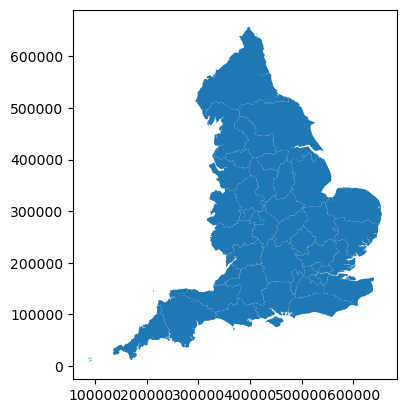

In [106]:
# plot the map outline created by the shape files.
map_nc.plot()

In [107]:
# check the nc dataframe
nc.head()

appointment_date icb_ons_code                           icb_ons_name   
0       2021-08-01    E54000019  NHS Herefordshire and Worcestershire   \
1       2021-08-01    E54000022               NHS Norfolk and Waveney    
2       2021-08-01    E54000022               NHS Norfolk and Waveney    
3       2021-08-01    E54000022               NHS Norfolk and Waveney    
4       2021-08-01    E54000022               NHS Norfolk and Waveney    

   region_ons_name   service_setting            context_type   
0         Midlands  General Practice    Inconsistent Mapping  \
1  East of England  General Practice  Care Related Encounter   
2  East of England  General Practice  Care Related Encounter   
3  East of England  General Practice  Care Related Encounter   
4  East of England  General Practice  Care Related Encounter   

              national_category appointment_dayofweek  appointment_month   
0          Inconsistent Mapping                Sunday                  8  \
1    General Consultation Acute                Sunday                  8   
2  General Consultation Routine                Sunday                  8   
3               Planned Clinics                Sunday                  8   
4                       Walk-in                Sunday                  8   

  appointment_season  appointment_year  gp_per_100000  count_of_appointments  
0             Summer              2021          64.11                      4  
1             Summer              2021          58.45                     42  
2             Summer              2021          58.45                     28  
3             Summer              2021          58.45                     12  
4             Summer              2021          58.45                    158

In [108]:
# create variables to hold the min and max dates of the datafram
min_date = nc['appointment_date'].min().strftime('%m/%Y')
max_date = nc['appointment_date'].max().strftime('%m/%Y')

In [109]:
# create a groupby icb with sum of appointments
nc_groupby_icb = nc.groupby('icb_ons_name')['count_of_appointments'].sum() \
                            .reset_index() \
                            .sort_values(by='count_of_appointments', ascending=False)

# create variables min and max
min_appointments = nc_groupby_icb['count_of_appointments'].min()
max_appointments = nc_groupby_icb['count_of_appointments'].max()

nc_groupby_icb.head(10)

icb_ons_name  count_of_appointments
28  NHS North East and North Cumbria                16882235
41                NHS West Yorkshire                14358371
15            NHS Greater Manchester                13857900
7        NHS Cheshire and Merseyside                13250311
29             NHS North West London                12142390
27             NHS North East London                 9588891
20               NHS Kent and Medway                 9286167
16   NHS Hampshire and Isle of Wight                 9210625
19    NHS Humber and North Yorkshire                 9125945
40                        NHS Sussex                 8929398

In [110]:
# merge geospatial data with the icb appointment data
nc_merged = map_nc.set_index('ICB23NM').join(nc_groupby_icb.set_index('icb_ons_name')).reset_index()

nc_merged.sort_values(by=['LONG'], inplace=True)
nc_merged.head()

ICB23NM    ICB23CD   BNG_E   BNG_N     LONG   
19  NHS Cornwall and the Isles of Scilly   E54000036  212497   64493 -4.64254  \
20                             NHS Devon   E54000037  283157   93085 -3.65678   
21                          NHS Somerset   E54000038  309318  131066 -3.29569   
2     NHS Shropshire, Telford and Wrekin   E54000011  350226  302960 -2.73668   
28      NHS Lancashire and South Cumbria   E54000048  352411  467532 -2.72924   

        LAT                              GlobalID   
19  50.4502  77024d50-a54d-4c4b-9122-08c49c0c9bba  \
20  50.7256  05ceb46b-1675-4eb1-a8bb-c41a6db2e9f4   
21  51.0717  7d455181-8907-4096-bbe6-b1cbdab7d94e   
2   52.6221  7771af61-6a62-4c2c-b9c9-1bfbdb20ba60   
28  54.1015  c3d322aa-b7c4-451d-95ab-c928ce0e2b2d   

                                             geometry  count_of_appointments  
19  MULTIPOLYGON (((88859.996 8832.496, 89270.734 ...                3697369  
20  MULTIPOLYGON (((264838.577 43779.215, 264643.3...                7447758  
21  MULTIPOLYGON (((329170.090 148190.593, 329228....                3079318  
2   POLYGON ((374820.812 344544.594, 374602.312 34...                2568487  
28  MULTIPOLYGON (((341524.402 455205.098, 341196....                8757248

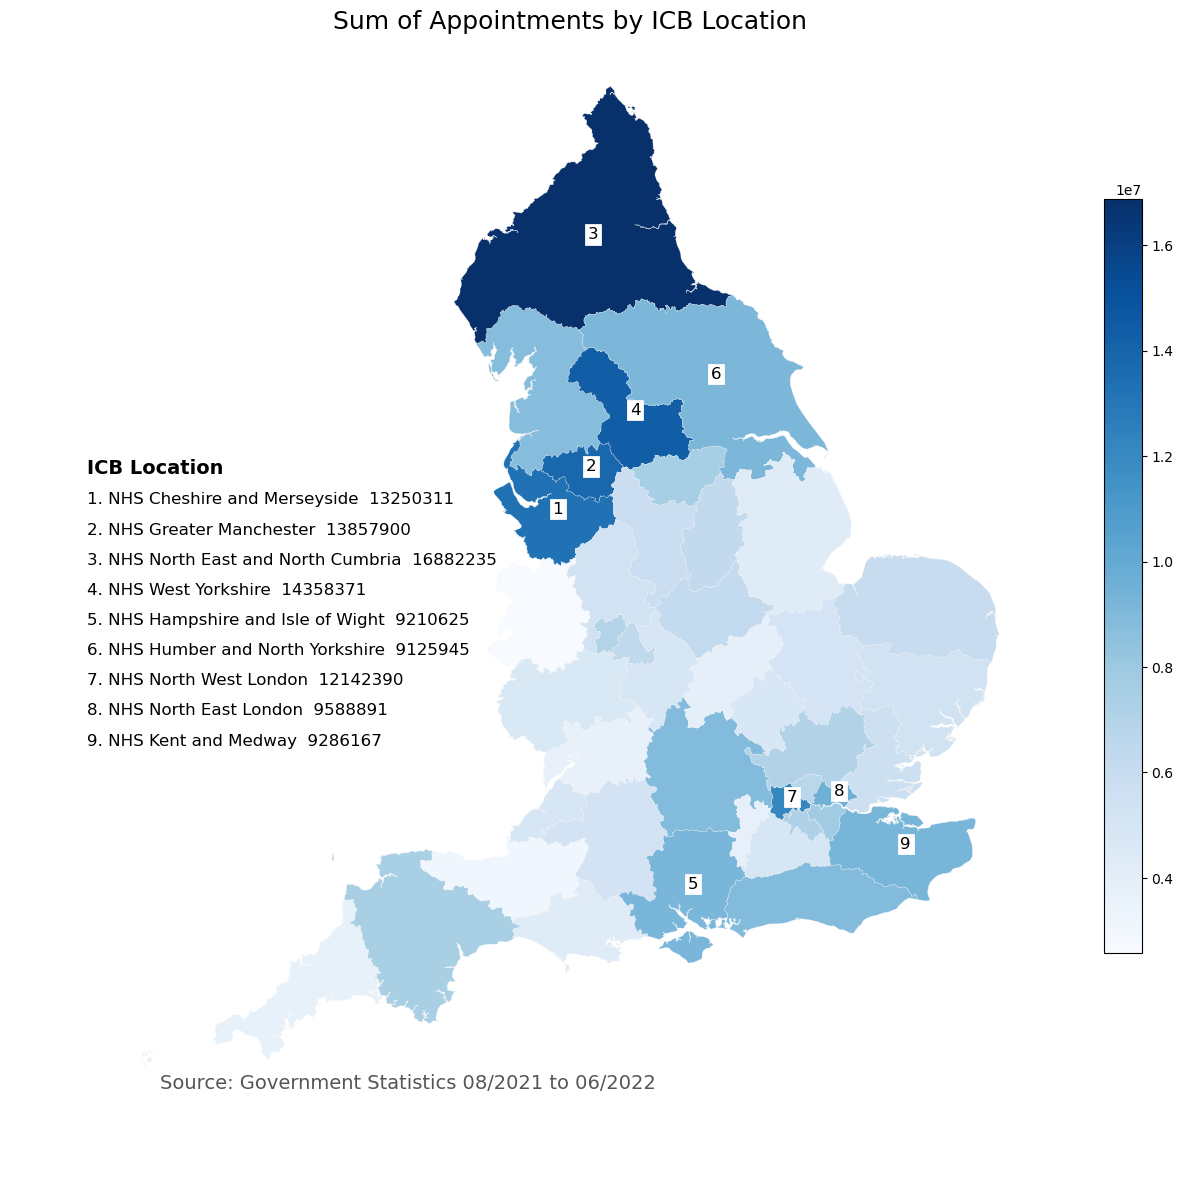

In [115]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'count_of_appointments'

# set the range for the choropleth
vmin, vmax = min_appointments, max_appointments

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(16, 14))

# create map
nc_merged.plot(column=variable, cmap='Blues', linewidth=0.2, ax=ax, edgecolor='whitesmoke', \
               vmin=vmin, vmax=vmax, legend=True, legend_kwds={'shrink': 0.7})

# remove the axis
ax.axis('off')

# add a title
ax.set_title('Sum of Appointments by ICB Location', \
             fontdict={'fontsize': '18', 'fontweight' : '2'})

# create an annotation for the data source
ax.annotate(f"Source: Government Statistics {min_date} to {max_date}", xy=(0.1, .08), \
            xycoords='figure fraction', horizontalalignment='left', \
            verticalalignment='top', fontsize=14, color='#555555')

coord_y = 400000
coord_x = 50000

plt.text(coord_x, coord_y, "ICB Location", fontsize=14, horizontalalignment='left', color='black', weight='semibold')

n = 1
coord_y = coord_y - 20000
greater_than = 9000000
less_than = 0
   
nc_merged.sort_values(by=['LONG'], inplace=True)

for x in nc_merged.index:
    if nc_merged['count_of_appointments'][x] > greater_than or nc_merged['count_of_appointments'][x] < less_than:
        ax.annotate(text=f"{n}. {nc_merged['ICB23NM'][x].replace('Integrated Care Board', '')} {'%.0f' % nc_merged['count_of_appointments'][x]}", 
                    xy=nc_merged.geometry[x].centroid.coords[0], 
                    ha='left', color='black', xytext=(coord_x, coord_y), fontsize=12)
        ax.annotate(text=n, 
                    xy=nc_merged.geometry[x].centroid.coords[0], 
                    ha='left', color='black', 
                    bbox=dict(boxstyle="square,pad=0.1", fc="white", ec="white", lw=2), fontsize=12)
        coord_y = coord_y - 20000
        n = n + 1


> Most appointments by ICB location are clustered in the North and South East regions.

### (ii) We want to understand the usage of resources, so we will create some visualisations indicating the number of appointments per month for service settings, context types, and national categories.

### Service Settings

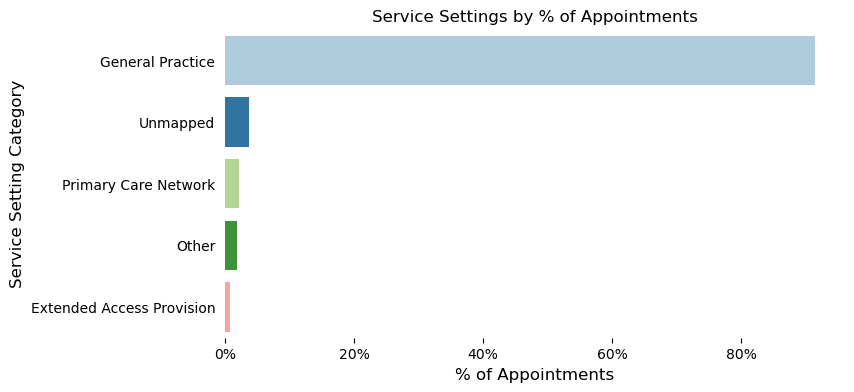

In [116]:
# plot bar chart to show 
fig, ax = plt.subplots(figsize=(8, 4))

# setup colour palette
sns.set_palette('Paired')

# plot chart
sns.barplot(x='%', y='service_setting', \
            data=groupby_agg_sum_pct(nc, 'service_setting', 'count_of_appointments'), \
            orient='h')

# setup labels, ticks, spines and title
ax.set_ylabel(r'Service Setting Category', size=12)
ax.set_xlabel(r'% of Appointments', size=12)
ax.ticklabel_format(style='plain', axis='x')
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.tick_params(left=False, bottom=True)
sns.despine(left=True, bottom=True)
plt.title("Service Settings by % of Appointments")

# print chart
plt.show()

# export chart
fig.savefig('Service Settings Barchart.png', dpi=300, bbox_inches='tight')

> Most appointments are clearly in the General Practice service setting.

In [117]:
# create service settings pivot table from nc dataframe, index = appointment date bi-weekly
nc_pivot_ss = pd.pivot_table(nc, values='count_of_appointments',
                                 index=[pd.Grouper(key='appointment_date', freq='14D')],
                                 columns=['service_setting'], aggfunc=np.sum) \
                                 .reset_index()

nc_pivot_ss.head()

service_setting appointment_date  Extended Access Provision  General Practice   
0                     2021-08-01                      76195          10186577  \
1                     2021-08-15                      75734          10257885   
2                     2021-08-29                      75956           9807441   
3                     2021-09-12                      87635          12374020   
4                     2021-09-26                      97685          13275606   

service_setting   Other  Primary Care Network  Unmapped  
0                214152                204883    593304  
1                211039                205224    575753  
2                201464                202514    528760  
3                247955                249041    631938  
4                268899                274310    651123

### Function

The function below will output a linechart for each column (except for appointment_date) calculated from the dataframe passed to it.

In [123]:
# df = dataframe
def linechart_by_nc(df):
    
    for col in df:
        if col != 'appointment_date':
            
            # prepare dataset
            df_new = df[['appointment_date', col]]
            df_new = df_new.set_index(['appointment_date'])
            df_mean = df_new[col].mean()
            df_sma = df_new[col].rolling(window=4).mean()
            
            # set figure and axis
            fig, ax = plt.subplots(figsize=(8, 3))
            
            # date formatter
            major_locator = AutoDateLocator()
            formatter = ConciseDateFormatter(major_locator)
            ax.xaxis.set_major_formatter(formatter)
            
            # plot the chart
            ax.plot_date(df['appointment_date'], df[col], linestyle='--', \
                         label='Appointments', color='#1161b8')
            ax.text(df['appointment_date'].min(), df_mean+(df_mean*0.01),'Mean Line')
            ax.axhline(y=df_mean, color='#CCCCCC', linestyle='--')
            ax.ticklabel_format(style='plain', axis='y')
            ax.plot(df_sma, 'r', label='2 Month SMA', linestyle='--')
            plt.fill_between(df_sma.index, df_new[col].min(), df_sma, color='r', alpha=0.05)
            
            # add title, remove grid and show plot
            #plt.legend(bbox_to_anchor=(0, 1), loc=4)
            plt.title(f"{col}: Sum of Appointments by Month")
            plt.grid(False)
            plt.legend(loc='best')
            plt.show()
            
            fig.savefig(col+'.png', dpi=300)
            
    return

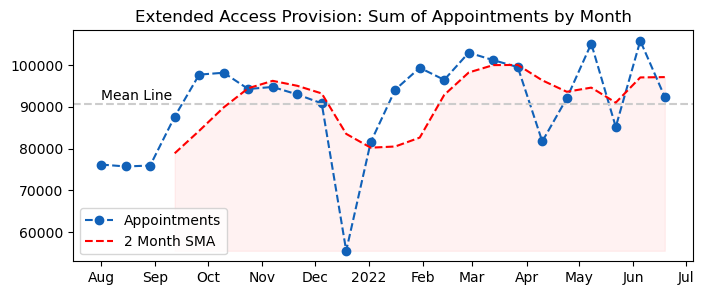

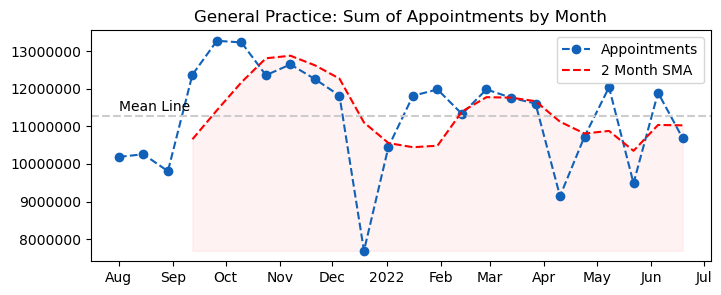

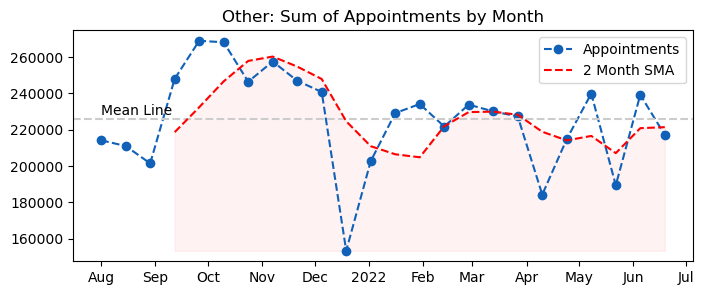

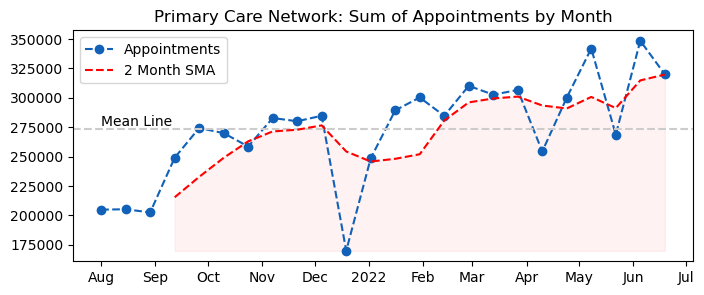

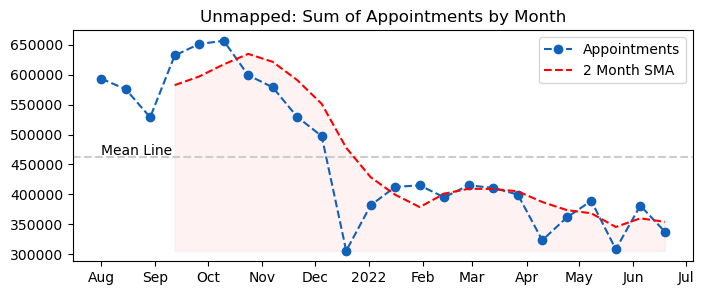

In [124]:
# plot the linecharts for service settings by calling the function
linechart_by_nc(nc_pivot_ss)

The service settings linecharts above show:
- General Practice shows a peak in October & November 2021, followed by an event in December where the number of appointments reduced signifanctly for a short period.
- Increased demand on the Primary Care Network over time.
- An decrease by around 50% of Unmapped category, indicating a better quality data over time.

> <b>NOTE:</b> The mean line show the average number of appointments by service setting. The 2 month SMA averages the line to reduce noise.

### Context Types

In [125]:
# create service settings pivot table from nc dataframe, index = appointment date bi-weekly
nc_pivot_ct = pd.pivot_table(nc, values='count_of_appointments',
                             index=[pd.Grouper(key='appointment_date', freq='14D')],
                             columns=['context_type'], aggfunc=np.sum) \
                             .reset_index()

nc_pivot_ct.head()

context_type appointment_date  Care Related Encounter  Inconsistent Mapping   
0                  2021-08-01                 9563146               1118661  \
1                  2021-08-15                 9634488               1115394   
2                  2021-08-29                 9198915               1088460   
3                  2021-09-12                11654905               1303746   
4                  2021-09-26                12554379               1362121   

context_type  Unmapped  
0               593304  
1               575753  
2               528760  
3               631938  
4               651123

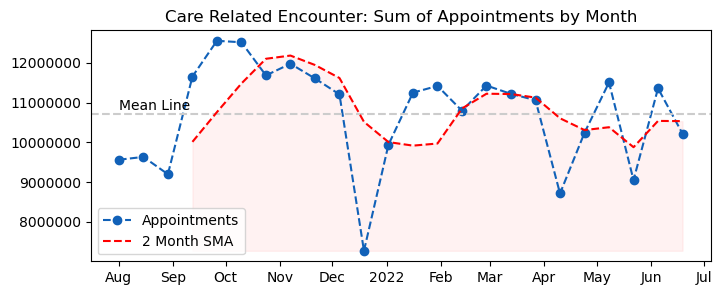

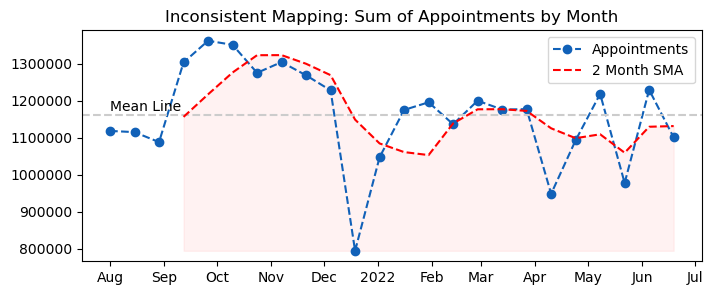

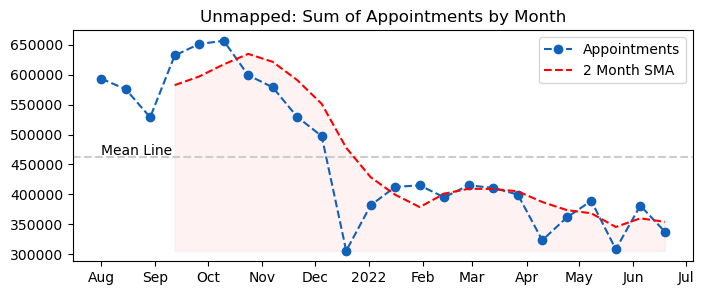

In [126]:
# call function to plot charts from nc_pivot_ct dataset
linechart_by_nc(nc_pivot_ct)

The context type linecharts above show:
- Care Related Encounter shows a peak in October & November 2021, followed by an event in December where the number of appointments reduced signifanctly for a short period.
- An decrease by around 50% of Unmapped category, indicating a better quality data over time.

> <b>NOTE:</b> The mean line show the average number of appointments by context type. The 2 month SMA averages the line to reduce noise.

### National Categories

In [7]:
# Create groupby national category from the nc dataset and calculate percent of appointments
nc_groupby_nc = nc.groupby('national_category') \
                          ['count_of_appointments'].sum().reset_index()

nc_groupby_nc['percentage_of_total'] = ((nc_groupby_nc['count_of_appointments'] \
                                        /nc['count_of_appointments'].sum())*100).round(2)

nc_groupby_nc.sort_values(by='percentage_of_total', ascending=False, inplace=True)

nc_groupby_nc.head(20)

national_category  count_of_appointments   
4                        General Consultation Routine               97271522  \
3                          General Consultation Acute               53691150   
2                                     Clinical Triage               41546964   
11                                    Planned Clinics               28019748   
7                                Inconsistent Mapping               27890802   
10                         Planned Clinical Procedure               25702694   
15                                           Unmapped               11080810   
16                        Unplanned Clinical Activity                3055794   
6                                          Home Visit                2144452   
14                       Structured Medication Review                1858379   
12  Service provided by organisation external to t...                 852133   
9              Patient contact during Care Home Round                 810330   
1                                     Care Home Visit                 628279   
13                         Social Prescribing Service                 475828   
0   Care Home Needs Assessment & Personalised Care...                 405904   
17                                            Walk-in                 412438   
8                     Non-contractual chargeable work                 138911   
5              Group Consultation and Group Education                  60632   

    percentage_of_total  
4                 32.86  
3                 18.14  
2                 14.03  
11                 9.46  
7                  9.42  
10                 8.68  
15                 3.74  
16                 1.03  
6                  0.72  
14                 0.63  
12                 0.29  
9                  0.27  
1                  0.21  
13                 0.16  
0                  0.14  
17                 0.14  
8                  0.05  
5                  0.02

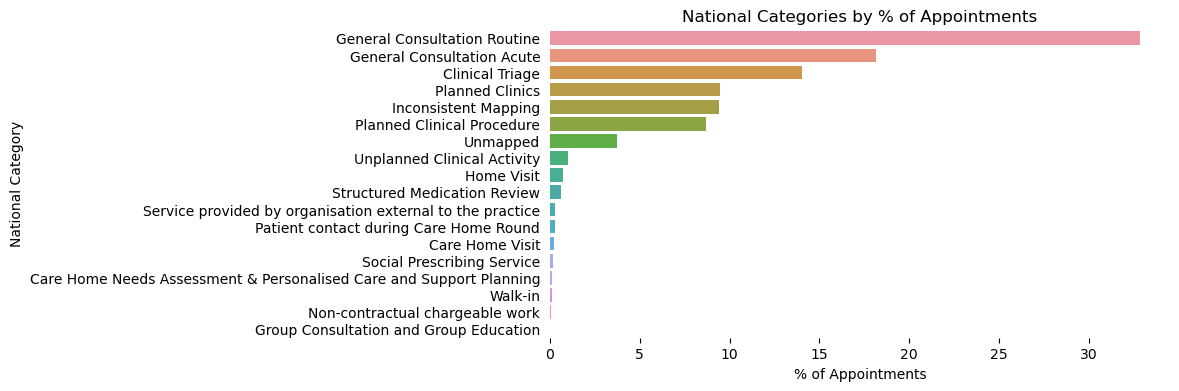

In [8]:
# plot bar chart to show 
fig, ax = plt.subplots(figsize=(8, 4))

# setup colour palette
sns.set_palette('Paired')

# plot chart
sns.barplot(x='percentage_of_total', y='national_category', \
            data=nc_groupby_nc, \
            orient='h')

# setup labels, ticks, spines and title
ax.set(xlabel='% of Appointments', ylabel='National Category')
ax.ticklabel_format(style='plain', axis='x')
ax.tick_params(left=False, bottom=True)
sns.despine(left=True, bottom=True)
plt.title("National Categories by % of Appointments")

# print chart
plt.show()

# export chart
fig.savefig('National Categories.png', dpi=300, bbox_inches='tight')

- Inconsistent Mapping and Unmapped are high, meaning the data is less reliable.
> <b>NOTE:</b> Remove categories with percentage_of_total below 1.5%

In [9]:
# Create groupby dataset for national categories by date (14 days)
nc_groupby_week_nc = nc.groupby([pd.Grouper(key='appointment_date', freq='14D'), \
                                'national_category']) \
                                ['count_of_appointments'] \
                                .sum() \
                                .reset_index()


nc_groupby_week_nc.head()

appointment_date                                  national_category   
0       2021-08-01  Care Home Needs Assessment & Personalised Care...  \
1       2021-08-01                                    Care Home Visit   
2       2021-08-01                                    Clinical Triage   
3       2021-08-01                         General Consultation Acute   
4       2021-08-01                       General Consultation Routine   

   count_of_appointments  
0                  13970  
1                  22034  
2                1743374  
3                2005515  
4                3665569

In [10]:
# remove national categories less than 1.5% of total appointments
for ind in nc_groupby_nc.index:
    if nc_groupby_nc['percentage_of_total'][ind] < 1.5:
        nc_groupby_week_nc = nc_groupby_week_nc[nc_groupby_week_nc['national_category'] \
                                                != nc_groupby_nc['national_category'][ind]]

In [11]:
# check to make sure I only have the national categories with more than 1.5% of total appointments
nc_groupby_week_nc.groupby('national_category')['count_of_appointments'].sum().reset_index()

national_category  count_of_appointments
0               Clinical Triage               41546964
1    General Consultation Acute               53691150
2  General Consultation Routine               97271522
3          Inconsistent Mapping               27890802
4    Planned Clinical Procedure               25702694
5               Planned Clinics               28019748
6                      Unmapped               11080810

In [12]:
# normalise dataframe nc_groupby_week_nc
nc_list = nc_groupby_nc["national_category"].tolist()

n = 1

for a in nc_list:
    if n != 1:
        df_1 = nc_groupby_week_nc.loc[nc_groupby_week_nc['national_category']==a].copy()
        df_1['scaled_appointments'] = max_abs_scaling(df_1['count_of_appointments'])
        df = pd.concat([df, df_1])
        n = n + 1
    else:
        df = nc_groupby_week_nc.loc[nc_groupby_week_nc['national_category']==a].copy()
        df['scaled_appointments'] = max_abs_scaling(df['count_of_appointments'])
        n = n + 1

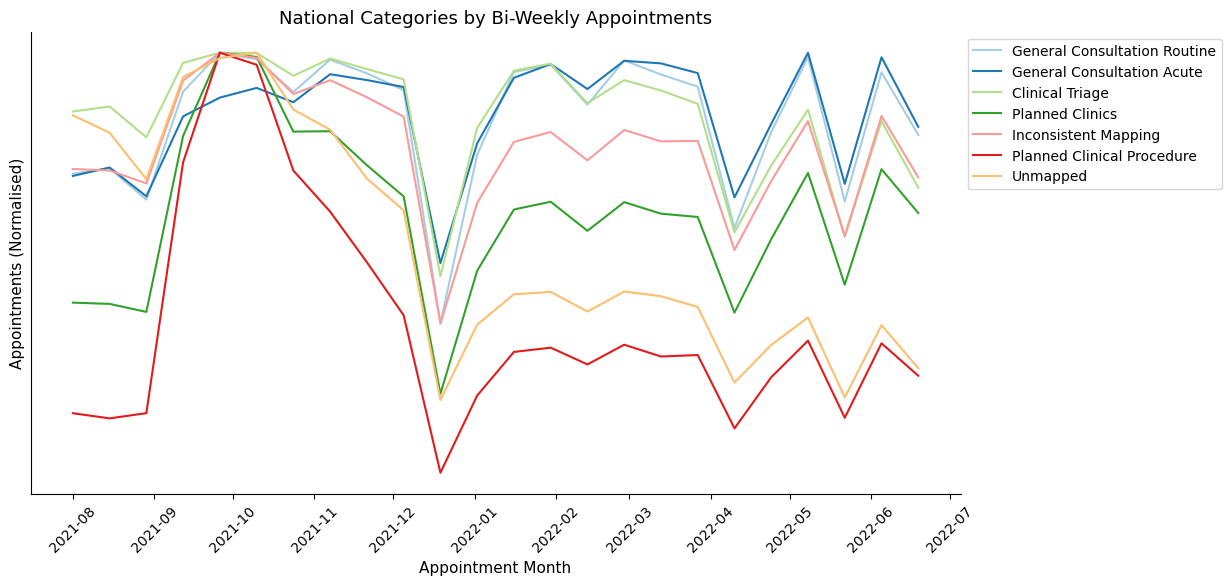

In [13]:
# plot dataframe nc_groupby_week_nc
fig, ax = plt.subplots(figsize=(12, 6))

# setup colour palette
sns.set_palette('Paired')

# plot the chart
sns.lineplot(x='appointment_date', y='scaled_appointments', hue='national_category', estimator=sum, data=df)

# place legend on right side outside
plt.legend(bbox_to_anchor=(1, 1), loc=2)

# setup labels, ticks, spines and title
plt.xticks(rotation=45)
ax.set_xlabel(r'Appointment Month', size=11)
ax.set_ylabel(r'Appointments (Normalised)', size=11)
ax.tick_params(left=False, bottom=True)
plt.yticks([]) 
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title("National Categories by Bi-Weekly Appointments", size=13)
plt.grid(False)

# print chart
plt.show()

# export chart
fig.savefig('National Categories Lineplot.png', dpi=300, bbox_inches='tight')

- Planned Clinics & Planned Clinical Procedure appointments exploded from relative low to high in October and November 2021, thereafter falling back to previous range.
- Unmapped category falling signifanctly after October 2021.

In [14]:
# subset the data to be national categories Planned Clinics & Planned Clinical Procedure
nc_groupby_nc_month_subset_planned = nc_groupby_week_nc[ \
                              (nc_groupby_week_nc['national_category'] == 'Planned Clinics') | \
                              (nc_groupby_week_nc['national_category'] == 'Planned Clinical Procedure')]

nc_groupby_nc_month_subset_planned.head()

appointment_date           national_category  count_of_appointments
10       2021-08-01  Planned Clinical Procedure                 817036
11       2021-08-01             Planned Clinics                 954567
28       2021-08-15  Planned Clinical Procedure                 802550
29       2021-08-15             Planned Clinics                 951540
46       2021-08-29  Planned Clinical Procedure                 817193

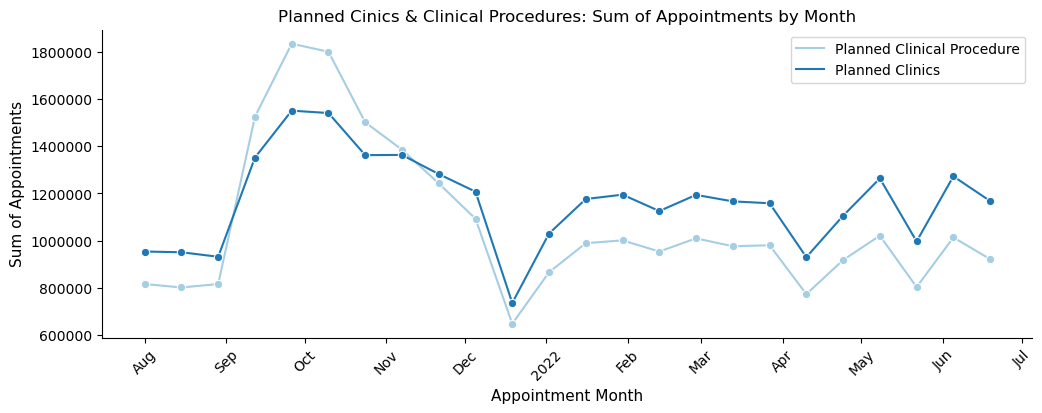

In [16]:
# Plot chart of patients waiting more than 3 weeks for appointments
fig, ax = plt.subplots(figsize=(12, 4))

# format dates
major_locator = AutoDateLocator()
formatter = ConciseDateFormatter(major_locator)
ax.xaxis.set_major_formatter(formatter)

# plot chart
sns.lineplot(data=nc_groupby_nc_month_subset_planned, x='appointment_date', y='count_of_appointments', \
             hue='national_category', marker="o",  linestyle="-", color='#1161b8')

# setup labels, ticks, spines, title and legend
ax.set_xlabel(r'Appointment Month', size=11)
ax.set_ylabel(r'Sum of Appointments', size=11)
ax.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
sns.despine(right=True, top=True)
plt.title('Planned Cinics & Clinical Procedures: Sum of Appointments by Month', size=12)
plt.legend(loc='best')

# show chart
plt.show()

# export chart
fig.savefig('National Categories Planned Lineplot.png', dpi=300, bbox_inches='tight')

- The aggregated data clearly shows a peak in October 2021 indicating a high demand for planned services, which reduce thereafter but still above previous August 2020 high.

In [14]:
# subset the data to be the top 3 national categories
nc_groupby_nc_month_subset_top3 = nc_groupby_week_nc[ \
                              (nc_groupby_week_nc['national_category'] == 'General Consultation Routine') | \
                              (nc_groupby_week_nc['national_category'] == 'General Consultation Acute') | \
                              (nc_groupby_week_nc['national_category'] == 'Clinical Triage')]

nc_groupby_nc_month_subset_top3.head()

appointment_date             national_category  count_of_appointments
2        2021-08-01               Clinical Triage                1743374
3        2021-08-01    General Consultation Acute                2005515
4        2021-08-01  General Consultation Routine                3665569
20       2021-08-15               Clinical Triage                1758050
21       2021-08-15    General Consultation Acute                2037638

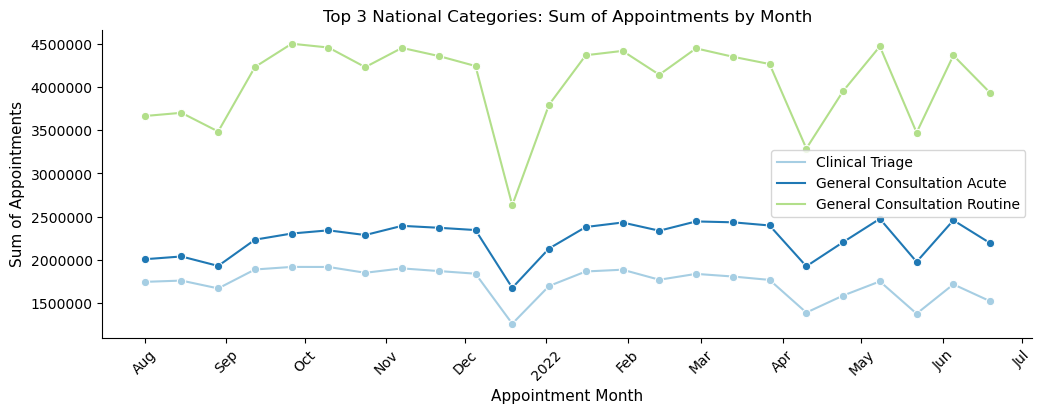

In [17]:
# Plot chart of patients waiting more than 3 weeks for appointments
fig, ax = plt.subplots(figsize=(12, 4))

# format dates
major_locator = AutoDateLocator()
formatter = ConciseDateFormatter(major_locator)
ax.xaxis.set_major_formatter(formatter)

# plot chart
sns.lineplot(data=nc_groupby_nc_month_subset_top3, x='appointment_date', y='count_of_appointments', \
             hue='national_category', marker="o",  linestyle="-", color='#1161b8')

# setup labels, ticks, spines, title and legend
ax.set_xlabel(r'Appointment Month', size=11)
ax.set_ylabel(r'Sum of Appointments', size=11)
ax.ticklabel_format(style='plain', axis='y')
sns.despine(right=True, top=True)
plt.title('Top 3 National Categories: Sum of Appointments by Month', size=12)
plt.xticks(rotation=45)
plt.legend(loc='best')

# show chart
plt.show()

# export chart
fig.savefig('National Categories Top 3 Lineplot.png', dpi=300, bbox_inches='tight')

- The data shows double peak in demand for services; October to November 2021, February to April 2022.
- Demand for General Consultation Acute (same day emergency) gradually increasing over time.

In [6]:
# show most common national category by sum of appointments
nc.groupby('national_category') \
          ['count_of_appointments'] \
           .sum().nlargest(7).reset_index()

national_category  count_of_appointments
0  General Consultation Routine               97271522
1    General Consultation Acute               53691150
2               Clinical Triage               41546964
3               Planned Clinics               28019748
4          Inconsistent Mapping               27890802
5    Planned Clinical Procedure               25702694
6                      Unmapped               11080810

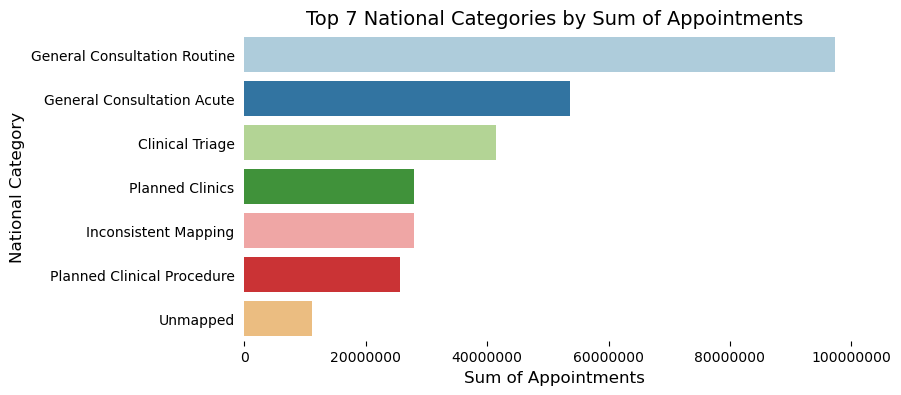

In [7]:
# plot bar chart to show 
fig, ax = plt.subplots(figsize=(8, 4))

# setup colour palette
sns.set_palette('Paired')

# plot chart
sns.barplot(x='count_of_appointments', y='national_category', \
            data=nc.groupby('national_category')['count_of_appointments'] \
            .sum().nlargest(7).reset_index(), \
            orient='h')

# setup labels, ticks, spines and title
ax.set_xlabel(r'Sum of Appointments', size=12)
ax.set_ylabel(r'National Category', size=12)

ax.ticklabel_format(style='plain', axis='x')
ax.tick_params(left=False, bottom=True)
sns.despine(left=True, bottom=True)
plt.title('Top 7 National Categories by Sum of Appointments', size=14)

# print chart
plt.show()

# export chart
fig.savefig('National Categories.png', dpi=300, bbox_inches='tight')

### (iii) Create visualisations indicating the number of appointments for service setting per season. The seasons are summer (August 2021), autumn (October 2021), winter (December 2021 & January 2022), and spring (April 2022).

In [140]:
# create service_setting groupby dataset from nc
nc_groupby_ss = nc.groupby('service_setting')['count_of_appointments'] \
                           .sum().reset_index() \
                           .sort_values(by='count_of_appointments', ascending=False)

# calculate new column percentage of total appointments
nc_groupby_ss['percentage_of_total'] = ((nc_groupby_ss['count_of_appointments'] \
                                         /nc['count_of_appointments'].sum())*100).round(2)

nc_groupby_ss.head()

service_setting  count_of_appointments  percentage_of_total
1           General Practice              270811691                91.48
4                   Unmapped               11080810                 3.74
3       Primary Care Network                6557386                 2.21
2                      Other                5420076                 1.83
0  Extended Access Provision                2176807                 0.74

<div class="alert alert-block alert-info"><b>NOTE: </b>The data for this exercise will only include the General Practice category. We want to see the how appointments are allocated in the GP setting only.</div>

In [141]:
# filter by GP only!!!
nc_gp_only = nc.loc[nc['service_setting']=='General Practice'].reset_index()

nc_gp_only.head()

index appointment_date icb_ons_code                           icb_ons_name   
0      0       2021-08-01    E54000019  NHS Herefordshire and Worcestershire   \
1      1       2021-08-01    E54000022               NHS Norfolk and Waveney    
2      2       2021-08-01    E54000022               NHS Norfolk and Waveney    
3      3       2021-08-01    E54000022               NHS Norfolk and Waveney    
4      4       2021-08-01    E54000022               NHS Norfolk and Waveney    

   region_ons_name   service_setting            context_type   
0         Midlands  General Practice    Inconsistent Mapping  \
1  East of England  General Practice  Care Related Encounter   
2  East of England  General Practice  Care Related Encounter   
3  East of England  General Practice  Care Related Encounter   
4  East of England  General Practice  Care Related Encounter   

              national_category appointment_dayofweek  appointment_month   
0          Inconsistent Mapping                Sunday                  8  \
1    General Consultation Acute                Sunday                  8   
2  General Consultation Routine                Sunday                  8   
3               Planned Clinics                Sunday                  8   
4                       Walk-in                Sunday                  8   

  appointment_season  appointment_year  gp_per_100000  count_of_appointments  
0             Summer              2021          64.11                      4  
1             Summer              2021          58.45                     42  
2             Summer              2021          58.45                     28  
3             Summer              2021          58.45                     12  
4             Summer              2021          58.45                    158

In [142]:
nc.groupby('appointment_date')['count_of_appointments'].sum().reset_index()

appointment_date  count_of_appointments
0         2021-08-01                   5627
1         2021-08-02                1222768
2         2021-08-03                1169920
3         2021-08-04                1093532
4         2021-08-05                1074043
..               ...                    ...
329       2022-06-26                   6574
330       2022-06-27                1410883
331       2022-06-28                1335598
332       2022-06-29                1237258
333       2022-06-30                1226746

[334 rows x 2 columns]

### Function

The function below will plot a linechart from the dataframe for each month passed as a dictionary (month:year).

In [144]:
# df = dataframe
# months = dictionary of Month : Year

def linechart_one_month(df, months):
    
    for m, y in months.items():
        
        # prepare dataframe
        # search by month and year
        df_new = df[(df['appointment_month'] == m) & (df['appointment_year'] == y)]
        # set month as string variable
        month_str = df_new['appointment_date'].dt.month_name(locale='English').iloc[0]
        year_str = y
        third_day = dt.date(y, m, 3)
        # group new dataframe by date
        df_new = df_new.groupby('appointment_date')['count_of_appointments'].sum().reset_index()
        # set index as date
        df_new = df_new.set_index(['appointment_date'])
        # keep only appointments column
        df_new = df_new[['count_of_appointments']]
    
        
        # Create plot and set plot size
        ax = df_new.plot(figsize=(8, 4), marker="o",  linestyle="--", color='#1161b8')
        plt.ylim([0, 1600000])
        plt.axhline(y=1200000, color='r', linestyle='--')
        plt.text(y=1210000, x=third_day, s='Daily Capacity', fontsize='x-small')
        
        # show full tick labels on y axis
        ax.ticklabel_format(style='plain', axis='y')
    
        # format the x-axis
        dtFmt = mdates.DateFormatter('%a')
        plt.gca().xaxis.set_major_formatter(dtFmt) 
        # show every tick on x axes
        plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
        plt.xticks(rotation=45, fontweight='light', fontsize='x-small')
        
        # plot title, labels, legend, grid
        plt.title(f"General Practice Appointments in {month_str} {year_str}")
        plt.xlabel("Appointment Day", size=11)
        plt.ylabel("Number of Appointments", size=11)
        plt.legend(['GP Appointments'], loc='upper right')
        plt.grid(False)
        
        # export chart
        plt.savefig('GP_' + str(m) + '_' + str(y) + '.png', dpi=300, bbox_inches='tight')
        
        # show plot
        plt.show(block=False)        
        
    return 

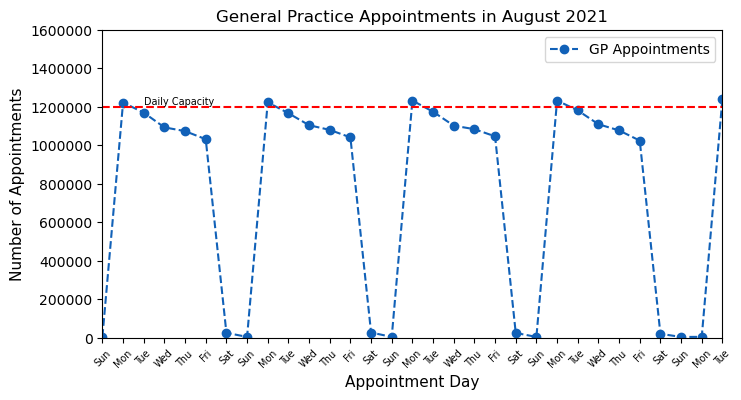

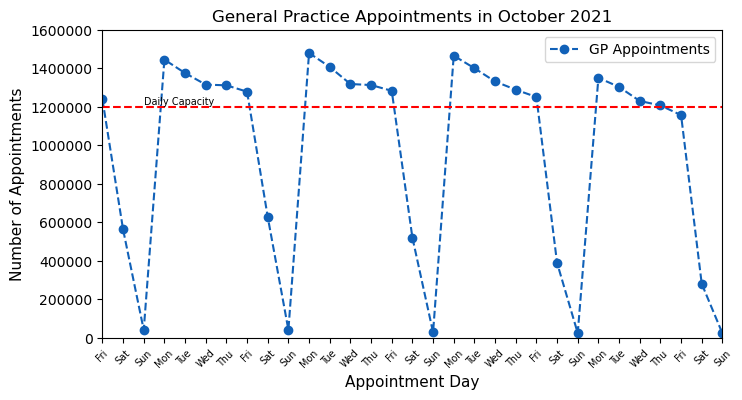

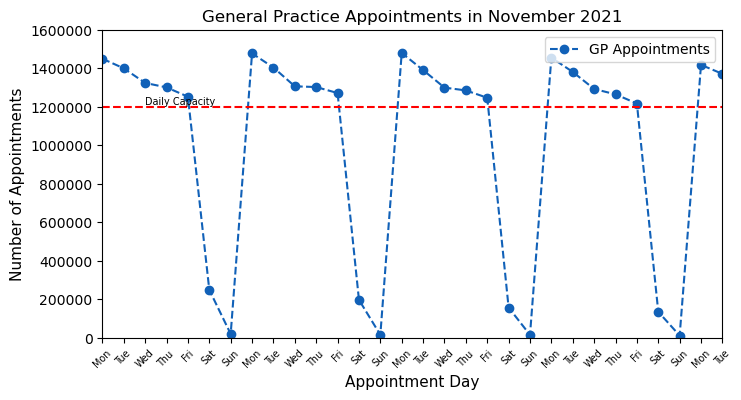

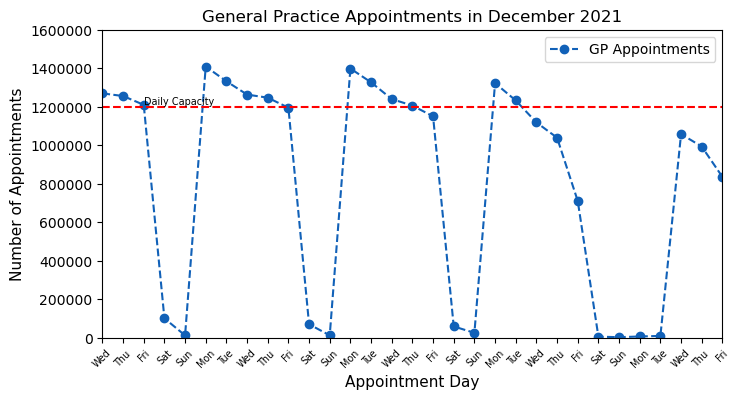

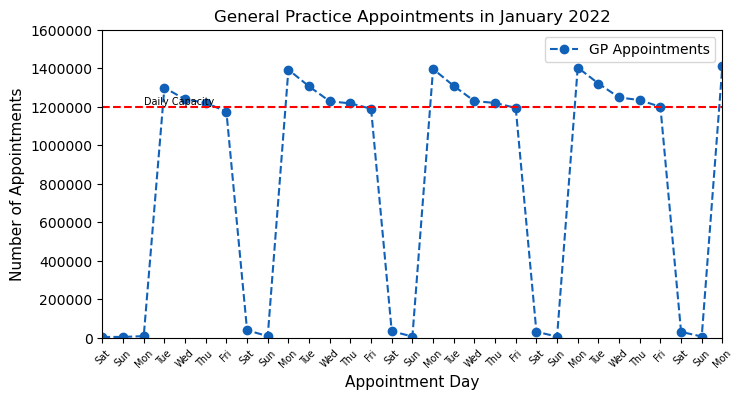

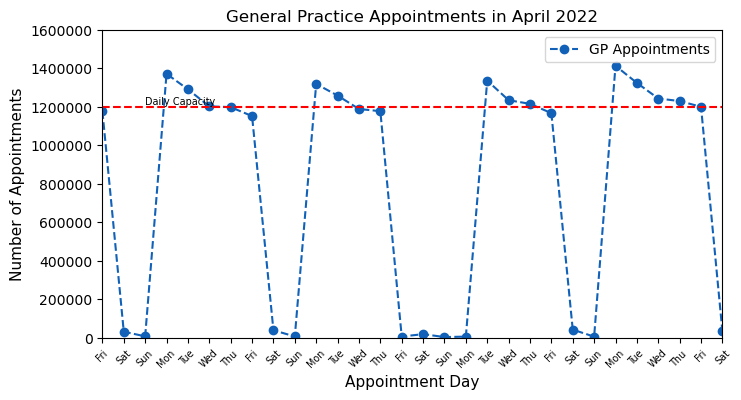

In [145]:
# Dictionary for selecting the month/year
months = {8 : 2021, 10 : 2021, 11 : 2021, 12 : 2021, 1 : 2022, 4 : 2022}

# Call function to print line charts from nc dataframe, months dictionary as filter
linechart_one_month(nc,months)

- Daily capacity of the General Practice (GP) surgeries is calculated to be 1.2 Million appointments per day.
- The linecharts clearly show GPs are generally open Mon to Fr.
- November 2021 was an anomaly where GPs were providing appointments on Saturday, perhaps to reduce waiting lists due to high demand.
- December 2021 shows that GPs were closed for Christmas holidays which explains the drop in appointments for that month.
- Daily capacity was exceeded for all months except for Summer (August 2021).

### (iv) Based on the linecharts above, it would useful to know which day of the week is busiest for the General Practice service setting.

In [146]:
# groupby days of the week and service setting
nc_groupby_dayofweek = nc_gp_only.groupby(['appointment_dayofweek', 'service_setting'])['count_of_appointments'] \
                           .sum().reset_index() \
                           .sort_values(by='count_of_appointments', ascending=False)

# calculate new column percentage of total appoinments
nc_groupby_dayofweek['percentage_of_total'] = ((nc_groupby_dayofweek['count_of_appointments'] \
                                            /nc_gp_only['count_of_appointments'].sum())*100).round(4)

# show head
nc_groupby_dayofweek.head(7)

appointment_dayofweek   service_setting  count_of_appointments   
5               Tuesday  General Practice               56529751  \
1                Monday  General Practice               54794619   
6             Wednesday  General Practice               53980690   
4              Thursday  General Practice               52084657   
0                Friday  General Practice               48099601   
2              Saturday  General Practice                4856121   
3                Sunday  General Practice                 466252   

   percentage_of_total  
5              20.8742  
1              20.2335  
6              19.9329  
4              19.2328  
0              17.7613  
2               1.7932  
3               0.1722

In [148]:
# Change dtype to ordered category
nc_groupby_dayofweek['appointment_dayofweek'] = nc_groupby_dayofweek['appointment_dayofweek']. \
       astype(pd.api.types.CategoricalDtype(categories=['Monday',
                                                        'Tuesday',
                                                        'Wednesday',
                                                        'Thursday',
                                                        'Friday',
                                                        'Saturday',
                                                        'Sunday'], ordered=True))

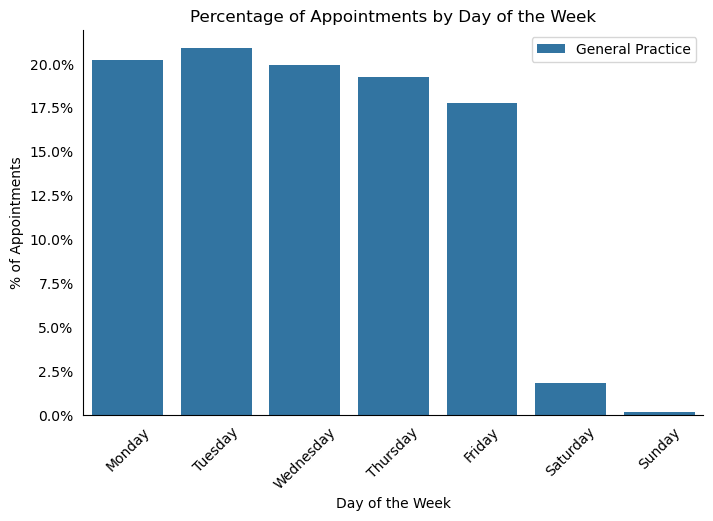

In [149]:
# Barplot of appointments by days of the week
fig, ax = plt.subplots(figsize=(8, 5))

# setup colour palette
sns.set_palette('tab10')

# setup chart
by_dayofweek = sns.barplot(x='appointment_dayofweek', y='percentage_of_total', \
                           hue='service_setting', data=nc_groupby_dayofweek, ax=ax, dodge=False)

# place legend on right side inside
plt.legend(bbox_to_anchor=(1, 1), loc=1)

# setup labels, ticks, spines and title
ax.set(xlabel='Day of the Week', ylabel='% of Appointments')
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.tick_params(left=False, bottom=False)
sns.despine(right=True, top=True)
plt.title("Percentage of Appointments by Day of the Week")

# rotate labels
for item in by_dayofweek.get_xticklabels():
    item.set_rotation(45)
    
# export chart
plt.savefig('GP_day_of_week.png', dpi=300, bbox_inches='tight')
    
# print chart
plt.show()

- Tuesday has the most appointments.
- Daily appointments fall lower until Friday. 
- Saturday has few appointments.
- Sunday has almost no appointments.

> This clearly reflects the routine week at a General Practice.

## 2. Actual Duration (ad) <a id="82"></a>

### (i) How long do appointments usually take?

In [150]:
# groupby actual_duration
ad_groupby_ad = groupby_agg_sum_pct(ad, 'actual_duration', 'count_of_appointments')

In [151]:
# Change actual_duration to ordered category datatype
ad_groupby_ad['actual_duration'] = ad_groupby_ad['actual_duration']. \
       astype(pd.api.types.CategoricalDtype(categories=['1-5 Minutes',
                                                        '6-10 Minutes',
                                                        '11-15 Minutes',
                                                        '16-20 Minutes',
                                                        '21-30 Minutes',
                                                        '31-60 Minutes',
                                                        'Unknown / Data Quality'], ordered=True))

ad_groupby_ad.sort_values(by='actual_duration')

actual_duration       sum      %
2             1-5 Minutes  28600865  17.03
1            6-10 Minutes  33800815  20.12
3           11-15 Minutes  25160882  14.98
4           16-20 Minutes  16004247   9.53
5           21-30 Minutes  15026365   8.95
6           31-60 Minutes   9103432   5.42
0  Unknown / Data Quality  40284086  23.98

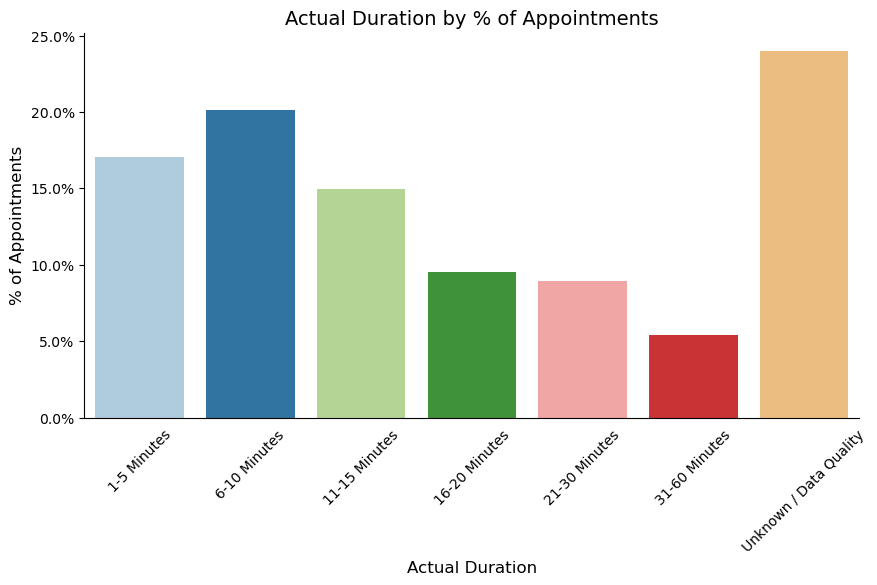

In [152]:
# Create a barplot.
# Barplot of appointment mode by percentage of dna
fig, ax = plt.subplots(figsize=(10, 5))

# setup colour palette
sns.set_palette('Paired')

# use seaborn to plot the chart
by_duration = sns.barplot(x='actual_duration', y='%', \
                      data=ad_groupby_ad, ax=ax)

# list of labels for x axis
for item in by_duration.get_xticklabels():
    item.set_rotation(45)

# format the y axis labels
ax.ticklabel_format(style='plain', axis='y')

# label the axis
ax.set_xlabel(r'Actual Duration', size=12)
ax.set_ylabel(r'% of Appointments', size=12)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Actual Duration by % of Appointments", size=14)

# remove ticks (bottom) and despine (right and top)
ax.tick_params(left=True, bottom=False)
sns.despine(right=True, top=True)

# show chart
plt.show()

# export chart
fig.savefig('actual_duration.png', dpi=300, bbox_inches='tight')

- A large proportion of the data (almost 25%) is Unknown/Data Quality which indicates that the quality of the data can be improved.
- Most appointments are completed within 15 minutes. 
- 15 minutes should be the target for completing appointments.

<div class="alert alert-block alert-info"><b>NOTE: </b>It would be useful to know more information regarding the actual duration of appointments. For example, the associated Health Care Professional (HCP) type or the National Category.</div>

## 3. Appointments Regional (ar) <a id="83"></a>

### (i) How did Covid effect monthly appointment data? <a id="86"></a>

In [154]:
# Read the nc table from the database
ar_groupby_month = pd.read_sql('SELECT * from ar_groupby_month ORDER BY appointment_date', engine)

In [155]:
ar_groupby_month.head()

appointment_date       sum     %    covid_status
0       2020-01-01  27199296  3.66       Pre-Covid
1       2020-02-01  24104621  3.25       Pre-Covid
2       2020-03-01  24053468  3.24       Pre-Covid
3       2020-04-01  16007881  2.16  Covid Lockdown
4       2020-05-01  16417212  2.21  Covid Lockdown

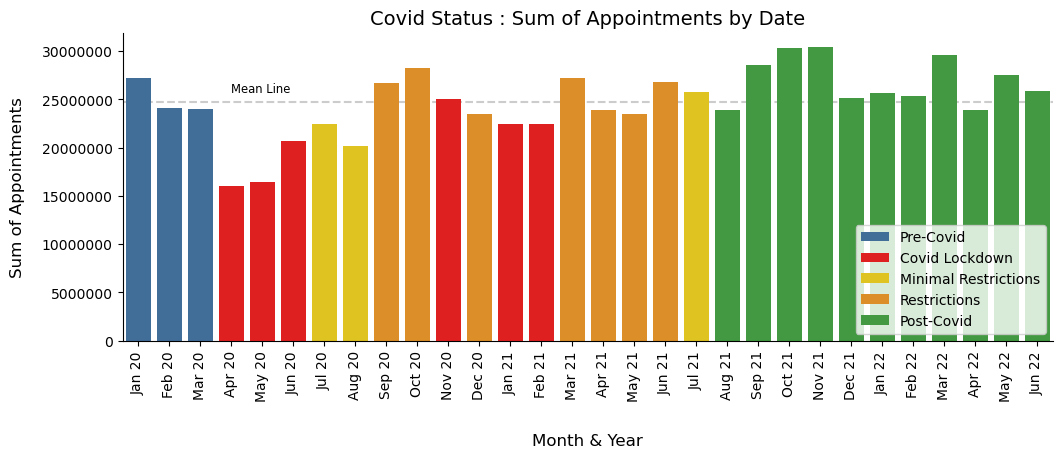

In [156]:
fig, ax = plt.subplots(figsize=(12, 4))

# the average monthly appointments
df_mean = ar_groupby_month['sum'].mean()

# use seaborn to plot the chart
sns.barplot(data=ar_groupby_month, x='appointment_date', \
            y='sum', hue='covid_status', ax=ax, dodge=False,
            palette={'Pre-Covid':'#326da8', \
                     'Covid Lockdown':'r', \
                     'Minimal Restrictions':'#ffd900', \
                     'Restrictions':'#fa920a', \
                     'Post-Covid':'#34a832'})

# remove top and right spines
sns.despine(top=True, right=True)

# list of labels for x axis
x_dates = ar_groupby_month['appointment_date'].dt.strftime('%b %y')
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
ax.set_xticklabels(labels=x_dates, rotation=90, ha='center')

# format the y axis labels
ax.ticklabel_format(style='plain', axis='y')

# plot the mean line
ax.axhline(y=df_mean, color='#CCCCCC', linestyle='--', zorder=0)
plt.text(y=df_mean+1000000, x=3, s='Mean Line', fontsize='small')

# label the axis
ax.set_ylabel(r'Sum of Appointments', size=12)
ax.set_xlabel(r'Month & Year', size=12)

# adjust x-axis label position 
ax.xaxis.set_label_coords(.5, -.3)
ax.yaxis.set_label_coords(-.105, .5)

# show the legend
plt.title('Covid Status : Sum of Appointments by Date', size=14)
plt.legend(loc='lower right')

# export chart
plt.savefig('covid.png', dpi=300, bbox_inches='tight')

# show the graph
plt.show()

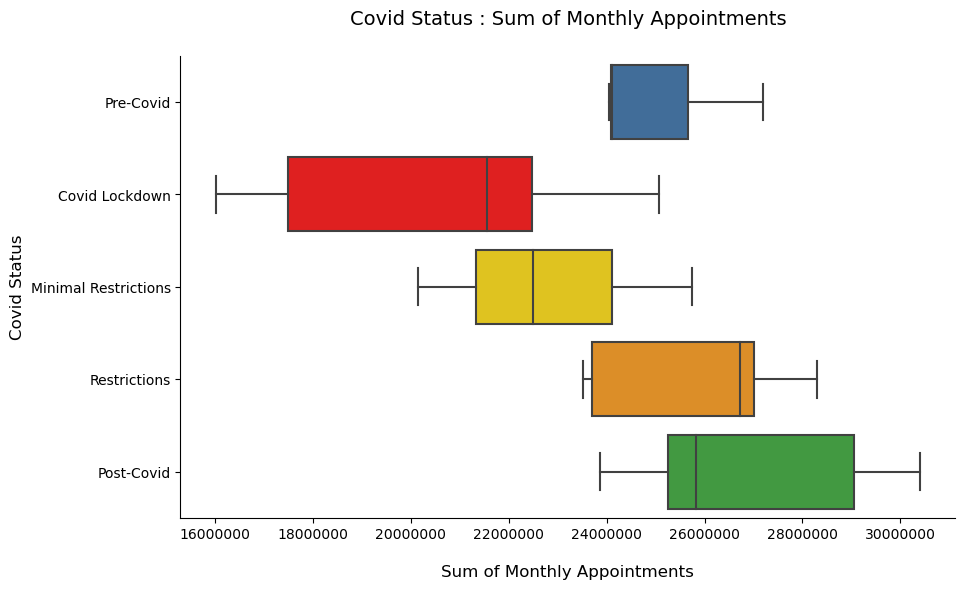

In [157]:
fig, ax = plt.subplots(figsize=(10, 6))

sns.boxplot(data=ar_groupby_month, x='sum', y='covid_status', \
            palette={'Pre-Covid':'#326da8', \
                     'Covid Lockdown':'r', \
                     'Minimal Restrictions':\
                     '#ffd900','Restrictions':\
                     '#fa920a', \
                     'Post-Covid':'#34a832'})

# remove top and right spines
sns.despine(top=True, right=True)

# format the x axis labels
ax.ticklabel_format(style='plain', axis='x')

# label the axis
ax.set_xlabel(r'Sum of Monthly Appointments', size=12)
ax.set_ylabel(r'Covid Status', size=12)

# adjust x-axis label position 
ax.xaxis.set_label_coords(.5, -.1)

# show the title
plt.title('Covid Status : Sum of Monthly Appointments', size=14, y=1.05)

# export chart
fig.savefig('covid-boxplot.png', dpi=300, bbox_inches='tight')

<div class="alert alert-block alert-danger">
<b>Important:</b> Analysis below will be based on the post-Covid subset of data</a>.
</div>

### (ii) What is the distribution of GP numbers per 100,000 population?

In [158]:
# Get the GP data by ICB
gp_data = ar.groupby('icb_ons_name')['gp_per_100000'].mean().reset_index()

# sort by gp_per_100000
gp_data.sort_values(by=['gp_per_100000'], inplace=True)

gp_data.reset_index(drop=True, inplace=True)

gp_data.head()

icb_ons_name  gp_per_100000
0                        NHS Kent and Medway           44.87
1                      NHS North West London           46.74
2  NHS Bedfordshire, Luton and Milton Keynes           47.01
3                    NHS Mid and South Essex           48.20
4                      NHS North East London           48.50

In [159]:
# describe the data
gp_data.describe()

gp_per_100000
count      42.000000
mean       56.922857
std         5.458675
min        44.870000
25%        53.690000
50%        57.930000
75%        60.047500
max        67.620000

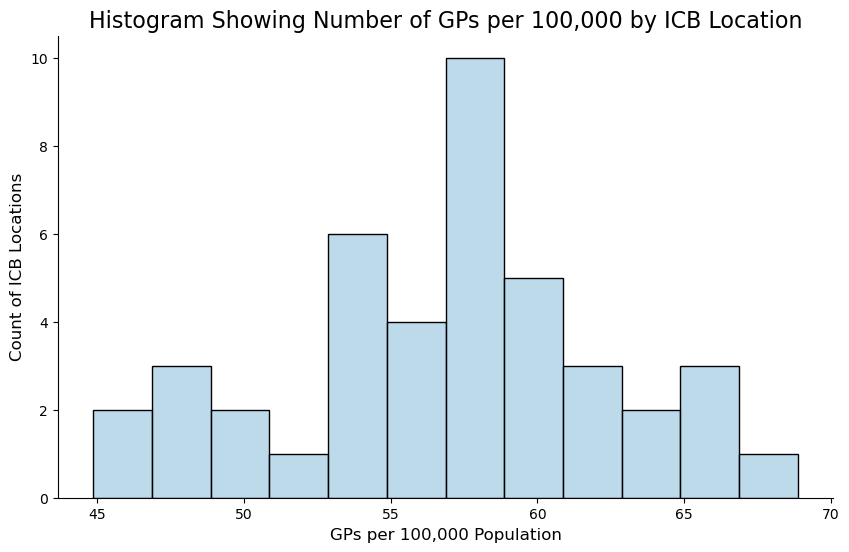

In [160]:
# plot the gp data in a histogram
fig, ax = plt.subplots(figsize=(10, 6))

sns.histplot(data=gp_data, x='gp_per_100000', binwidth=2)

# add labels
ax.set_xlabel(r'GPs per 100,000 Population', size=12)
ax.set_ylabel(r'Count of ICB Locations', size=12)
plt.title("Histogram Showing Number of GPs per 100,000 by ICB Location", size=16)

# remove spines on the top and right
sns.despine(right=True, top=True)

# show plot
plt.show()

# export chart
fig.savefig('gp_per_100000.png', dpi=300, bbox_inches='tight')

- GP distribution is fairly normal across ICB locations, we should expect a few locations to be relatively high (63 to 68) and low (45 to 50)

### (iii) Do appointments by Healthcare Professional (HCP) types differ over time?

In [8]:
# create groupby month for healthcare professional type
ar_groupby_month_hcp = ar_subset_post_covid.groupby(['hcp_type', 'appointment_date']) \
                                                    ['count_of_appointments'].sum().reset_index()

In [9]:
# preview head
ar_groupby_month_hcp.head()

hcp_type appointment_date  count_of_appointments
0       GP       2021-08-01               12299022
1       GP       2021-09-01               14487785
2       GP       2021-10-01               14300751
3       GP       2021-11-01               14897749
4       GP       2021-12-01               12654767

In [10]:
# remove unknown category
ar_groupby_month_hcp = ar_groupby_month_hcp.loc[ar_groupby_month_hcp['hcp_type']!='Unknown']

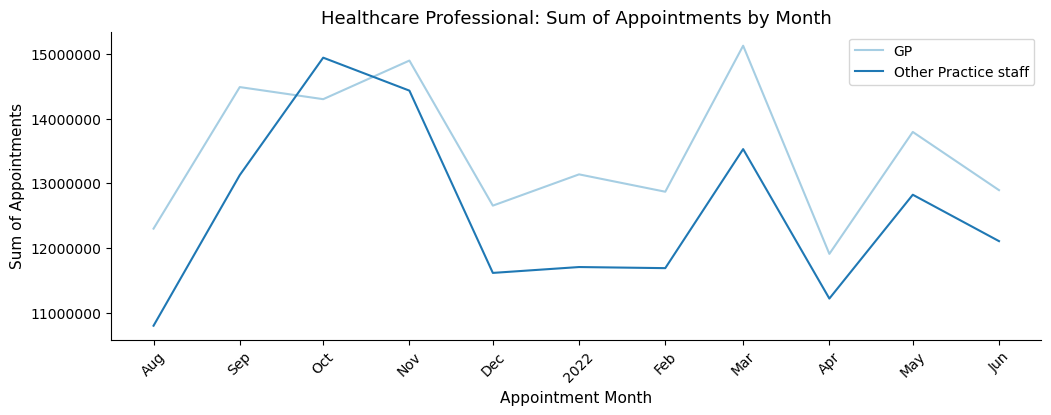

In [164]:
# plot the linechart
fig, ax = plt.subplots(figsize=(12, 4))

# date formatted
major_locator = AutoDateLocator()
formatter = ConciseDateFormatter(major_locator)
ax.xaxis.set_major_formatter(formatter)

# plot the chart
sns.lineplot(data=ar_groupby_month_hcp, x='appointment_date', y='count_of_appointments', hue='hcp_type')

# setup labels, ticks, spines, legend and title
ax.set_xlabel(r'Appointment Month', size=11)
ax.set_ylabel(r'Sum of Appointments', size=11)
ax.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
ax.tick_params(left=True, bottom=True)
sns.despine(left=False, bottom=False)
plt.title("Healthcare Professional: Sum of Appointments by Month", size=13)
plt.legend(loc='best')

# show plot
plt.show()

# export chart
fig.savefig('hcp_type_lineplot.png', dpi=300, bbox_inches='tight')

- Appointments by healthcare professionals appear to follow a similar pattern. Peaks in demand during the months of October and November 2021, and March 2022.
- Demand for the different types are fairly even.

> It would be beneficial to have the breakdown of the different Other Practice Staff category to be able to understand how the resources are being used.

### (iv) How does appointment mode change over time?

In [165]:
# group the data by appointment mode
ar_groupby_mode = ar_subset_post_covid.groupby(['appointment_mode', 'appointment_date']) \
                                               ['count_of_appointments'].sum().reset_index()

In [166]:
# preview the head
ar_groupby_mode.head()

appointment_mode appointment_date  count_of_appointments
0     Face-to-Face       2021-08-01               13717325
1     Face-to-Face       2021-09-01               17266602
2     Face-to-Face       2021-10-01               19471561
3     Face-to-Face       2021-11-01               19031327
4     Face-to-Face       2021-12-01               15312340

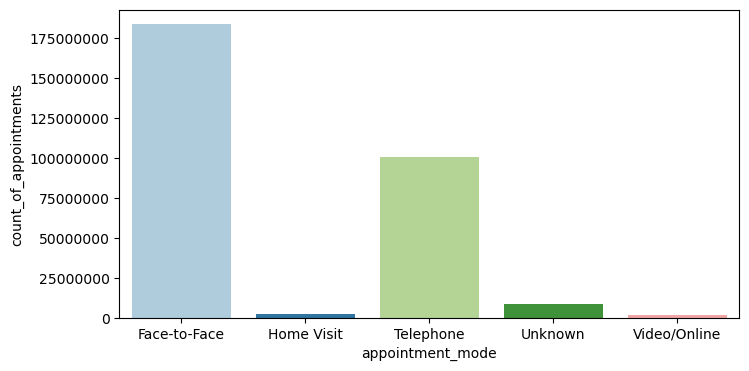

In [168]:
# Create a quick barplot
# Barplot of appointment mode by sum of appointments
fig, ax = plt.subplots(figsize=(8, 4))

# use seaborn to plot the chart
sns.barplot(x='appointment_mode', y='count_of_appointments', \
            data=ar_groupby_mode.groupby('appointment_mode')['count_of_appointments'].sum().reset_index(), ax=ax)

# format labels
ax.ticklabel_format(style='plain', axis='y')

# show plot
plt.show()

- Face-to-Face is clearly the most common appointment mode, followed by Telephone.

In [169]:
# subset the data for only Face-to-Face & Telephone modes
ar_groupby_mode_subset = ar_groupby_mode[ \
                         (ar_groupby_mode['appointment_mode'] == 'Face-to-Face') | \
                         (ar_groupby_mode['appointment_mode'] == 'Telephone')]

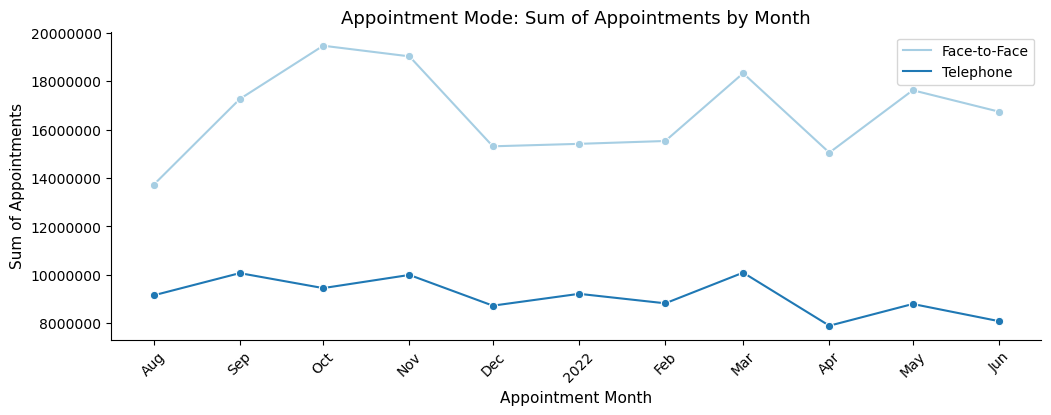

In [178]:
fig, ax = plt.subplots(figsize=(12, 4))

# setup colour palette
sns.set_palette('Paired')

# format date
major_locator = AutoDateLocator()
formatter = ConciseDateFormatter(major_locator)
ax.xaxis.set_major_formatter(formatter)

sns.lineplot(data=ar_groupby_mode_subset, x='appointment_date', y='count_of_appointments', \
             hue='appointment_mode', marker="o",  linestyle="-")

# setup labels, ticks, spines, legend and title
ax.set_xlabel(r'Appointment Month', size=11)
ax.set_ylabel(r'Sum of Appointments', size=11)
ax.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
ax.tick_params(left=True, bottom=True)
sns.despine(left=False, bottom=False)
plt.title("Appointment Mode: Sum of Appointments by Month", size=13)
plt.legend(loc='best')

# show plot
plt.show()

# export chart
fig.savefig('appointment_mode_lineplot.png', dpi=300, bbox_inches='tight')

- The dataset shows appointments by telephone reducing over time
- Face-to-Face visits saw a spike in October & November 2021, and gradually increasing.

In [179]:
# subset the data for only Home Visit & Video/Online modes
ar_groupby_mode_subset = ar_groupby_mode[ \
                         (ar_groupby_mode['appointment_mode'] == 'Home Visit') | \
                         (ar_groupby_mode['appointment_mode'] == 'Video/Online')]

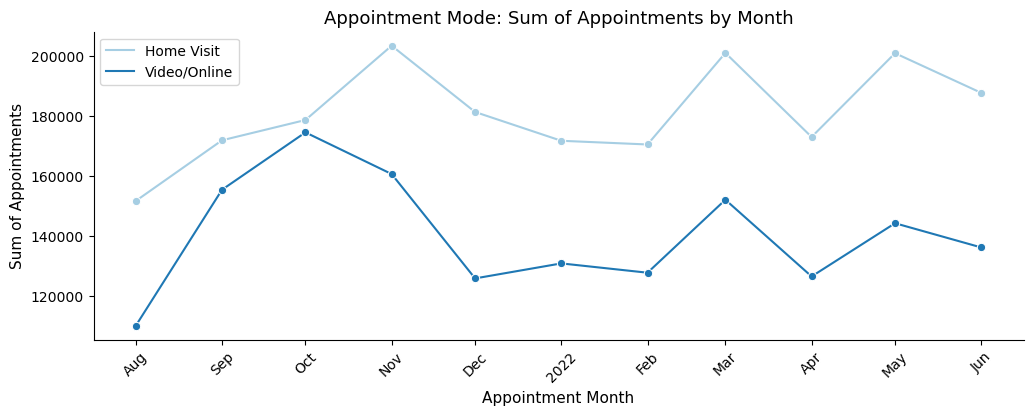

In [180]:
fig, ax = plt.subplots(figsize=(12, 4))

# setup colour palette
sns.set_palette('Paired')

# format date
major_locator = AutoDateLocator()
formatter = ConciseDateFormatter(major_locator)
ax.xaxis.set_major_formatter(formatter)

sns.lineplot(data=ar_groupby_mode_subset, x='appointment_date', y='count_of_appointments', \
             hue='appointment_mode', marker="o",  linestyle="-")


# setup labels, ticks, spines, legend and title
ax.set_xlabel(r'Appointment Month', size=11)
ax.set_ylabel(r'Sum of Appointments', size=11)
ax.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
ax.tick_params(left=True, bottom=True)
sns.despine(left=False, bottom=False)
plt.title("Appointment Mode: Sum of Appointments by Month", size=13)
plt.legend(loc='best')

# show plot
plt.show()

- Video/Online appointments, while increasing suddenly during October, dropped back and have remained fairly steady over time
- Home visits have clearly increased

### (v) How does time between booking and appointment change over time?

In [181]:
# create groupby dataset for time_between_book_and_appointment and appointment date
ar_groupby_time_month = ar_subset_post_covid.groupby(['time_between_book_and_appointment', 'appointment_date']) \
                                                     ['count_of_appointments'].sum().reset_index()

In [182]:
# change time_between_book_and_appointment column to ordered category
# remove 'Unknown / Data Quality' from dataset
ar_groupby_time_month['time_between_book_and_appointment'] = ar_groupby_time_month['time_between_book_and_appointment']. \
       astype(pd.api.types.CategoricalDtype(categories=['Same Day',
                                                        '1 Day',
                                                        '2 to 7 Days',
                                                        '8  to 14 Days',
                                                        '15  to 21 Days',
                                                        '22  to 28 Days',
                                                        'More than 28 Days'], ordered=True))

In [183]:
# review the data
ar_groupby_time_month.head()

time_between_book_and_appointment appointment_date  count_of_appointments
0                             1 Day       2021-08-01                2018319
1                             1 Day       2021-09-01                2666072
2                             1 Day       2021-10-01                2598516
3                             1 Day       2021-11-01                2506532
4                             1 Day       2021-12-01                2219212

In [184]:
# groupby time to use in a barplot
ar_groupby_time = ar_groupby_time_month.groupby('time_between_book_and_appointment') \
                                               ['count_of_appointments'].sum().reset_index()

In [185]:
# show head
ar_groupby_time.head()

time_between_book_and_appointment  count_of_appointments
0                          Same Day              130976642
1                             1 Day               25872974
2                       2 to 7 Days               60734100
3                     8  to 14 Days               37507051
4                    15  to 21 Days               19454328

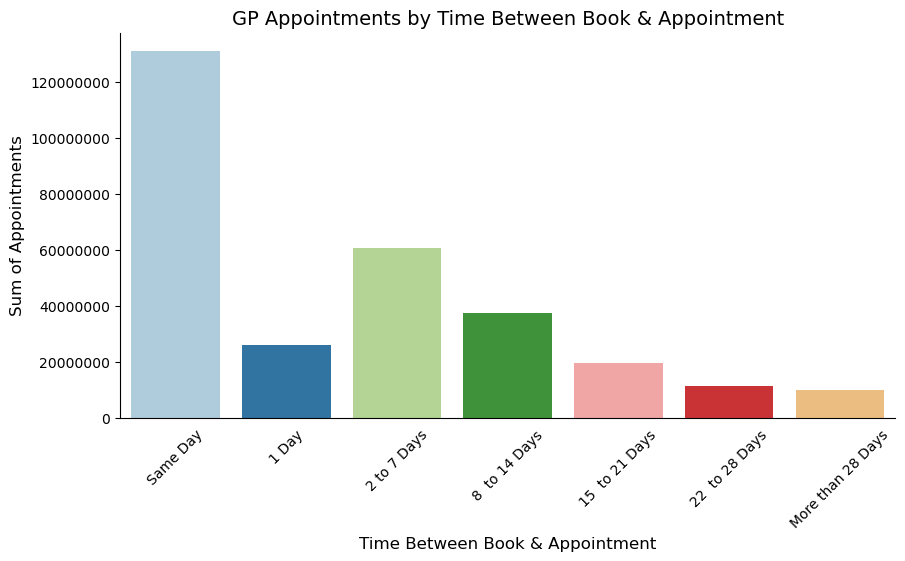

In [186]:
# Create a barplot.
# Barplot of sum of appointments by time between book and appointment
fig, ax = plt.subplots(figsize=(10, 5))

# setup colour palette
sns.set_palette('Paired')

# use seaborn to plot the chart
by_duration = sns.barplot(x='time_between_book_and_appointment', y='count_of_appointments', \
                          data=ar_groupby_time, ax=ax, errorbar=None)

# list of labels for x axis
for item in by_duration.get_xticklabels():
    item.set_rotation(45)

# format the y axis labels
ax.ticklabel_format(style='plain', axis='y')

# label the axis
ax.set_xlabel(r'Time Between Book & Appointment', size=12)
ax.set_ylabel(r'Sum of Appointments', size=12)
plt.title("GP Appointments by Time Between Book & Appointment", size=14)

# remove ticks (bottom) and despine (right and top)
ax.tick_params(left=True, bottom=False)
sns.despine(right=True, top=True)

# show chart
plt.show()

# export chart
fig.savefig('time_between_book_and_appointment_barplot.png', dpi=300, bbox_inches='tight')

- Most appointments are seen within 1 week of booking
- It would be good to understand how patients waiting longer than 2 weeks changes over time 

In [209]:
# change datatype of time_between_book_and_appointment to be string (as category it will show all)
ar_groupby_time_month['time_between_book_and_appointment'] = \
ar_groupby_time_month["time_between_book_and_appointment"].values.astype('string')

In [210]:
# subset the data to be time more than 2 weeks
ar_groupby_time_month_subset = ar_groupby_time_month[ \
                              (ar_groupby_time_month['time_between_book_and_appointment'] == '15  to 21 Days') | \
                              (ar_groupby_time_month['time_between_book_and_appointment'] == '22  to 28 Days') | \
                              (ar_groupby_time_month['time_between_book_and_appointment'] == 'More than 28 Days')]

In [211]:
# view the shape of dataset
ar_groupby_time_month_subset.groupby('time_between_book_and_appointment')['count_of_appointments'].sum().reset_index().head()

time_between_book_and_appointment  count_of_appointments
0                    15  to 21 Days               19454328
1                    22  to 28 Days               11430584
2                 More than 28 Days                9880538

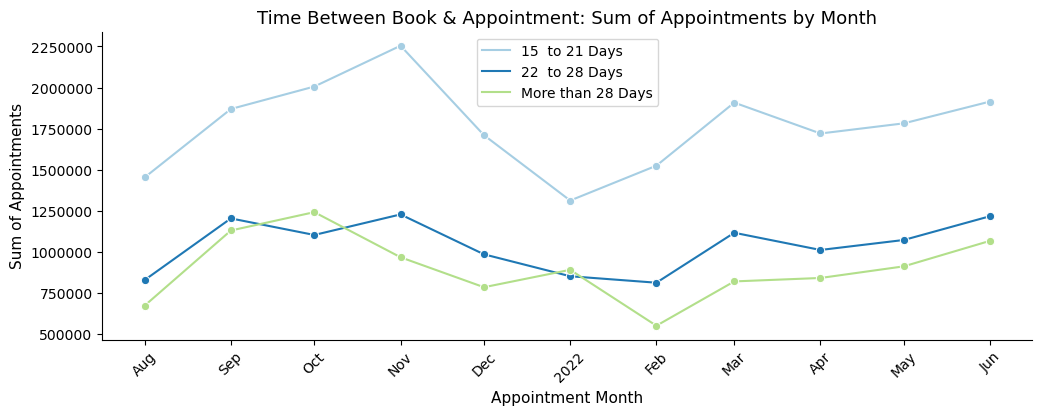

In [212]:
# Plot chart of patients waiting more than 3 weeks for appointments
fig, ax = plt.subplots(figsize=(12, 4))

# setup colour palette
sns.set_palette('Paired')

# format the date x-axis
major_locator = AutoDateLocator()
formatter = ConciseDateFormatter(major_locator)
ax.xaxis.set_major_formatter(formatter)

# plot the chart
sns.lineplot(data=ar_groupby_time_month_subset, x='appointment_date', y='count_of_appointments', \
             hue='time_between_book_and_appointment', marker="o",  linestyle="-", color='#1161b8')

# setup labels, ticks, spines, legend and title
ax.set_xlabel(r'Appointment Month', size=11)
ax.set_ylabel(r'Sum of Appointments', size=11)
ax.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
ax.tick_params(left=True, bottom=True)
sns.despine(left=False, bottom=False)
plt.title("Time Between Book & Appointment: Sum of Appointments by Month", size=13)
plt.legend(loc='best')

# show the plot
plt.show()

# export chart
fig.savefig('time_gt_2weeks.png', dpi=300, bbox_inches='tight')

- For the time between booking and appointment more than 2 weeks, the total appointments in this category peaked in October 2021 and gradually declined until early 2022. Then there was a general trend in the sum of appointments increasing after February 2022.

## 4. Missed Appointments <a id="84"></a>

In this analysis it would be beneficial to for any trends or relationships in the data regarding missed appointments. This may help the NHS develop a strategy to reduce the number of appointments not attended.

In [13]:
# Create a variable to store the average % of missed appointments
dna_mean = round(ar_subset_post_covid[ar_subset_post_covid['appointment_status']=='DNA'] \
                               ['count_of_appointments'].sum() \
                               /(ar_subset_post_covid['count_of_appointments'].sum())*100, 2)

print(f'The average of missed appointments in the post-Covid dataset is {dna_mean}%')

The average of missed appointments in the post-Covid dataset is 4.5%


### (i) How are missed appointments distributed by ICB location, as a percentage of the total appointments?

<Axes: xlabel='percentage_of_dna', ylabel='Count'>

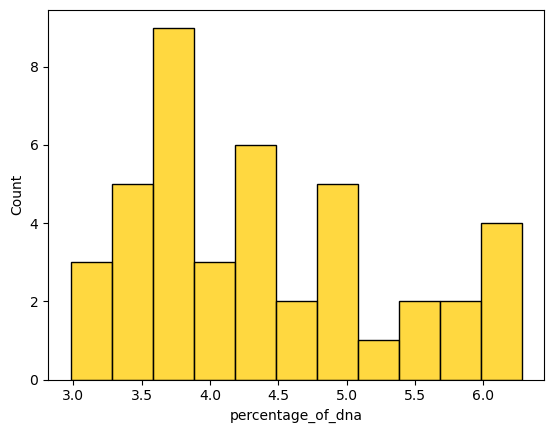

In [214]:
sns.histplot(data=ar_pivot_icb_status, x='percentage_of_dna', binwidth=0.3, color='#ffcc00')

- The histogram is skewed to the lower end of the scale of percentage of 'Did Not Attend' appointments. This suggests that there are fewer ICB Locations above average of 4.5% than there are below.


### (ii) Create a map showing the percentage of missed appointments by ICB

<div class="alert alert-block alert-danger">
<b>Important:</b> The shapefile must be on your local computer, and change the file location in the code below. The data can be downloaded the <a href="https://geoportal.statistics.gov.uk/datasets/ons::integrated-care-boards-april-2023-en-bsc-2/explore?location=52.832374%2C-2.374080%2C8.49" target="_blank">Government statistics website</a>.
</div>

In [11]:
# set the filepath and load in a shapefile
fp = "D:\LSE\Assignment 2\icb_shape_files\ICB_APR_2023_EN_BSC.shp"
map_df = gpd.read_file(fp)

map_df['ICB23NM'] = map_df['ICB23NM'].str.replace('Integrated Care Board', '')

# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()

ICB23CD                                     ICB23NM   BNG_E   BNG_N   
0  E54000008                NHS Cheshire and Merseyside   374405  380936  \
1  E54000010       NHS Staffordshire and Stoke-on-Trent   398243  334651   
2  E54000011         NHS Shropshire, Telford and Wrekin   350226  302960   
3  E54000013                           NHS Lincolnshire   517984  358538   
4  E54000015  NHS Leicester, Leicestershire and Rutland   466552  310188   

      LONG      LAT                              GlobalID   
0 -2.38572  53.3247  01aa947d-176c-4218-b9f5-6798c1191576  \
1 -2.02756  52.9093  3b28608f-bcd0-4cc3-b3fd-ee20085b1351   
2 -2.73668  52.6221  7771af61-6a62-4c2c-b9c9-1bfbdb20ba60   
3 -0.23884  53.1110  00359689-8b11-467f-8e48-247c842cbef5   
4 -1.01690  52.6853  221b43d6-c9ee-4fe9-bd15-c16166e272a7   

                                            geometry  
0  POLYGON ((336404.203 422323.301, 335946.900 42...  
1  POLYGON ((404258.156 368301.562, 406240.093 36...  
2  POLYGON ((374820.812 344544.594, 374602.312 34...  
3  POLYGON ((512490.999 414654.689, 512679.309 41...  
4  POLYGON ((482154.188 340911.500, 483722.808 34...

<Axes: >

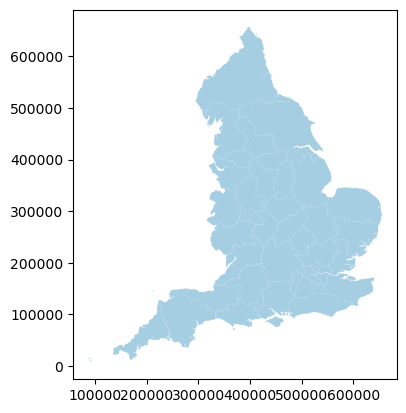

In [12]:
# plot the shape of the polygon
map_df.plot()

In [13]:
# Read the ar table from the database
icb = pd.read_sql('SELECT * from ar_pivot_icb_status', engine)

# drop the sum of appointments column
icb.drop(['sum_of_appointments'], axis=1, inplace=True)

In [14]:
# check the head
icb.head()

icb_ons_name  percentage_of_dna   
0                           NHS Mid and South Essex                2.98  \
1                              NHS Northamptonshire                3.09   
2  NHS Bath and North East Somerset, Swindon and ...               3.20   
3                                        NHS Dorset                3.30   
4                          NHS Derby and Derbyshire                3.35   

   gp_per_100000 dna_status gp_status  
0          48.20        Low       Bad  
1          57.84        Low        OK  
2          59.82        Low        OK  
3          57.29        Low        OK  
4          65.31        Low      Good

In [15]:
# merge geospatial data with the icb appointment data
merged = map_df.set_index('ICB23NM').join(icb.set_index('icb_ons_name')).reset_index()

merged.sort_values(by=['LONG'], inplace=True)
merged.head()

ICB23NM    ICB23CD   BNG_E   BNG_N     LONG   
19  NHS Cornwall and the Isles of Scilly   E54000036  212497   64493 -4.64254  \
20                             NHS Devon   E54000037  283157   93085 -3.65678   
21                          NHS Somerset   E54000038  309318  131066 -3.29569   
2     NHS Shropshire, Telford and Wrekin   E54000011  350226  302960 -2.73668   
28      NHS Lancashire and South Cumbria   E54000048  352411  467532 -2.72924   

        LAT                              GlobalID   
19  50.4502  77024d50-a54d-4c4b-9122-08c49c0c9bba  \
20  50.7256  05ceb46b-1675-4eb1-a8bb-c41a6db2e9f4   
21  51.0717  7d455181-8907-4096-bbe6-b1cbdab7d94e   
2   52.6221  7771af61-6a62-4c2c-b9c9-1bfbdb20ba60   
28  54.1015  c3d322aa-b7c4-451d-95ab-c928ce0e2b2d   

                                             geometry  percentage_of_dna   
19  MULTIPOLYGON (((88859.996 8832.496, 89270.734 ...               3.74  \
20  MULTIPOLYGON (((264838.577 43779.215, 264643.3...               3.86   
21  MULTIPOLYGON (((329170.090 148190.593, 329228....               4.60   
2   POLYGON ((374820.812 344544.594, 374602.312 34...               4.10   
28  MULTIPOLYGON (((341524.402 455205.098, 341196....               5.00   

    gp_per_100000 dna_status gp_status  
19          65.08     Medium      Good  
20          65.39     Medium      Good  
21          58.53     Medium        OK  
2           59.44     Medium        OK  
28          56.87     Medium        OK

In [16]:
# The date range to show on the map
min_date = ar_subset_post_covid['appointment_date'].min().strftime('%m/%Y')
max_date = ar_subset_post_covid['appointment_date'].max().strftime('%m/%Y')

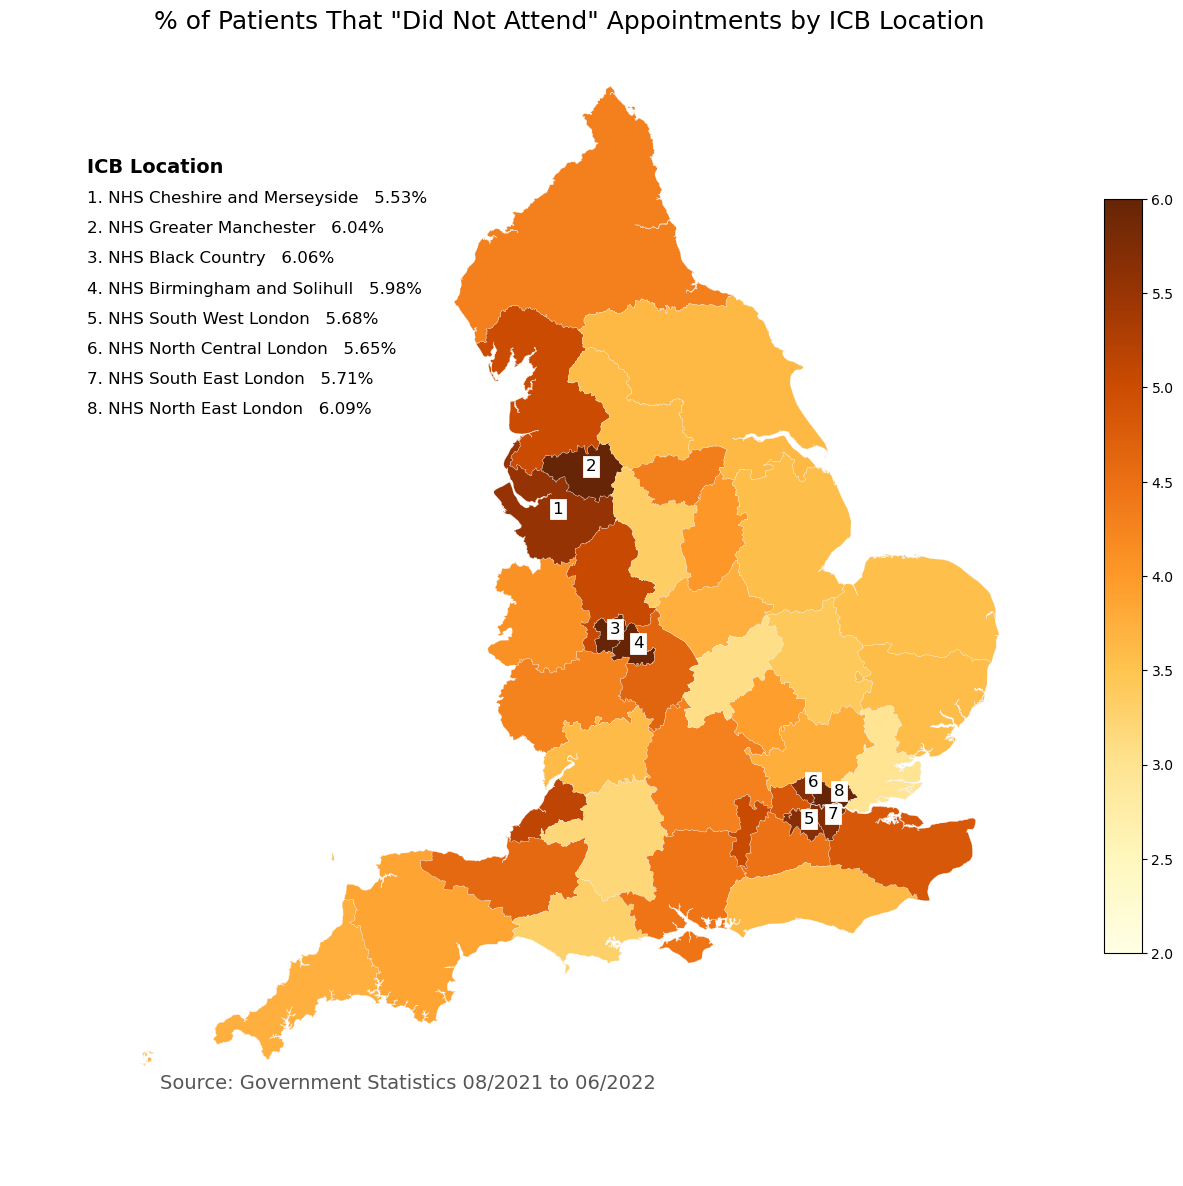

In [17]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'percentage_of_dna'

# set the range for the choropleth
vmin, vmax = 2, 6

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(16, 14))

# create map
merged.plot(column=variable, cmap='YlOrBr', linewidth=0.2, ax=ax, edgecolor='whitesmoke', \
            vmin=vmin, vmax=vmax, legend=True, legend_kwds={'shrink': 0.7})

# remove the axis
ax.axis('off')

# add a title
ax.set_title('% of Patients That "Did Not Attend" Appointments by ICB Location', \
             fontdict={'fontsize': '18', 'fontweight' : '2'})

# create an annotation for the data source
ax.annotate(f"Source: Government Statistics {min_date} to {max_date}", xy=(0.1, .08), \
            xycoords='figure fraction', horizontalalignment='left', \
            verticalalignment='top', fontsize=14, color='#555555')

coord_y = 600000
coord_x = 50000

plt.text(coord_x, coord_y, "ICB Location", fontsize=14, horizontalalignment='left', color='black', weight='semibold')

n = 1
coord_y = coord_y - 20000
greater_than = 5.15
less_than = 0
   
merged.sort_values(by=['LONG'], inplace=True)

for x in merged.index:
    if merged['percentage_of_dna'][x] > greater_than or merged['percentage_of_dna'][x] < less_than:
        ax.annotate(text=f"{n}. {merged['ICB23NM'][x].replace('Integrated Care Board', '')} \
 {'%.2f' % merged['percentage_of_dna'][x]}%", 
                    xy=merged.geometry[x].centroid.coords[0], 
                    ha='left', color='black', xytext=(coord_x, coord_y), fontsize=12)
        ax.annotate(text=n, 
                    xy=merged.geometry[x].centroid.coords[0], 
                    ha='left', color='black', 
                    bbox=dict(boxstyle="square,pad=0.1", fc="white", ec="white", lw=2), fontsize=12)
        coord_y = coord_y - 20000
        n = n + 1
        
# export map
fig.savefig('icb_map_export.png', dpi=300)

- The North West and London show the highest rates of missed appointments.
- NHS Black Country (6.06%), NHS Greater Manchester (6.04%) & NHS North East London (6.09%) have the highest rates.

### (iii) Create a lineplot illustrating how unattended appointments changed over time

In [33]:
# Create a subset of appointment status by appointment date
ar_groupby_month_status = ar_subset_post_covid.groupby(['appointment_status', 'appointment_date']) \
                                               ['count_of_appointments'].sum().reset_index()

# set region to 'All'
ar_groupby_month_status['region_ons_name'] = 'All Regions'

In [34]:
# Filter appointment status to be DNA only
ar_groupby_month_status = ar_groupby_month_status.loc[ar_groupby_month_status['appointment_status']=='DNA']

In [35]:
# show the head
ar_groupby_month_status.head()

appointment_status appointment_date  count_of_appointments region_ons_name
11                DNA       2021-08-01                 949137     All Regions
12                DNA       2021-09-01                1321348     All Regions
13                DNA       2021-10-01                1565624     All Regions
14                DNA       2021-11-01                1428087     All Regions
15                DNA       2021-12-01                1198866     All Regions

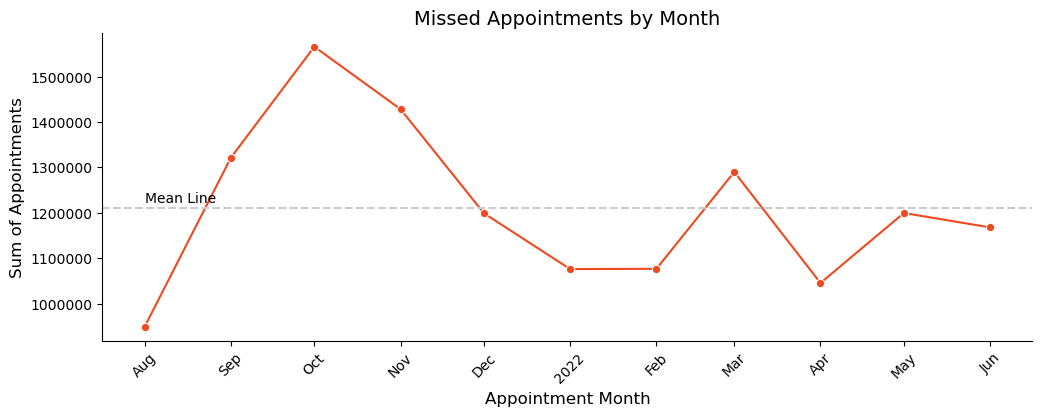

In [229]:
# Setup figure
fig, ax = plt.subplots(figsize=(12, 4))

# calcualte mean of the dataset
dna_mean = ar_groupby_month_status['count_of_appointments'].mean()

# format the x-axis date
major_locator = AutoDateLocator()
formatter = ConciseDateFormatter(major_locator)
ax.xaxis.set_major_formatter(formatter)

sns.lineplot(data=ar_groupby_month_status, x='appointment_date', \
             y='count_of_appointments', \
             marker="o",  linestyle="-", color='#f0491f')

# show the mean line for the dataset
ax.axhline(y=dna_mean, color='#CCCCCC', linestyle='--')
ax.text(ar_groupby_month_status['appointment_date'].min(), dna_mean+(dna_mean*0.01),'Mean Line')

# setup labels, ticks, spines and title
ax.set_xlabel(r'Appointment Month', size=12)
ax.set_ylabel(r'Sum of Appointments', size=12)
ax.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
ax.tick_params(left=True, bottom=True)
sns.despine(left=False, bottom=False)
plt.title("Missed Appointments by Month", size=14)

# show chart
plt.show()

# export chart
fig.savefig('missed_appointments_linechart.png', dpi=300, bbox_inches='tight')

- Missed appointments rose dramatically during the busiest month of October, but then fell below the average by December and effectively remains below average since then.

### Compare with London and the North West regions

In [63]:
# Create a subset of appointment status by appointment date and region
ar_groupby_month_status_region = ar_subset_post_covid.groupby(['appointment_status', 'appointment_date', 'region_ons_name']) \
                                               ['count_of_appointments'].sum().reset_index()

In [64]:
# Filter appointment status to be DNA only
ar_groupby_month_status_region = ar_groupby_month_status_region \
                                 .loc[ar_groupby_month_status_region['appointment_status']=='DNA']

In [65]:
# show the head
ar_groupby_month_status_region.head()

appointment_status appointment_date           region_ons_name   
77                DNA       2021-08-01           East of England  \
78                DNA       2021-08-01                    London   
79                DNA       2021-08-01                  Midlands   
80                DNA       2021-08-01  North East and Yorkshire   
81                DNA       2021-08-01                North West   

    count_of_appointments  
77                  80908  
78                 181395  
79                 184948  
80                 134208  
81                 144345

In [66]:
# create subset with only London & North West region data
ar_subset_london_northwest = ar_groupby_month_status_region \
                             .loc[(ar_groupby_month_status_region['region_ons_name']=='London') | \
                                  (ar_groupby_month_status_region['region_ons_name']=='North West')]

In [68]:
# show the head
ar_subset_london_northwest.head()

appointment_status appointment_date region_ons_name  count_of_appointments
78                DNA       2021-08-01          London                 181395
81                DNA       2021-08-01      North West                 144345
85                DNA       2021-09-01          London                 227227
88                DNA       2021-09-01      North West                 221661
92                DNA       2021-10-01          London                 255278

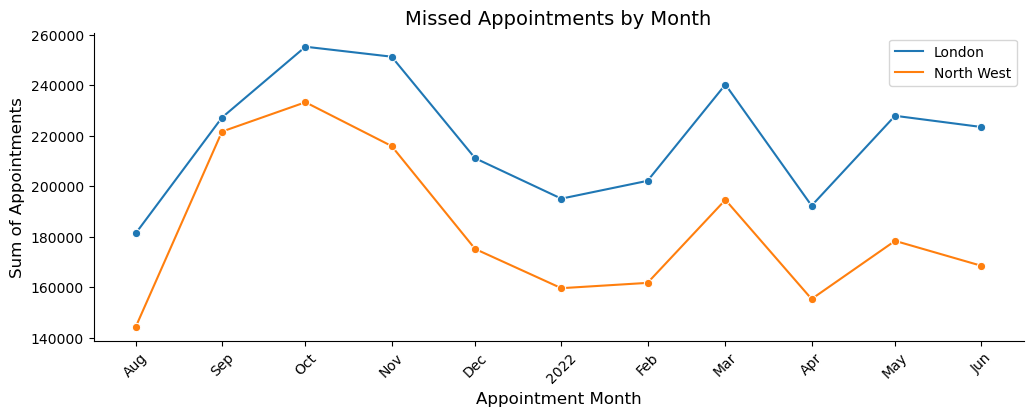

In [70]:
# Setup figure
fig, ax = plt.subplots(figsize=(12, 4))

# format the x-axis date
major_locator = AutoDateLocator()
formatter = ConciseDateFormatter(major_locator)
ax.xaxis.set_major_formatter(formatter)

sns.lineplot(data=ar_subset_london_northwest, x='appointment_date', \
             y='count_of_appointments', hue='region_ons_name',\
             marker="o",  linestyle="-", color='#f0491f')

# setup labels, ticks, spines and title
ax.set_xlabel(r'Appointment Month', size=12)
ax.set_ylabel(r'Sum of Appointments', size=12)
ax.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
ax.tick_params(left=True, bottom=True)
sns.despine(left=False, bottom=False)
plt.title("Missed Appointments by Month", size=14)
plt.legend(loc='best')

# show chart
plt.show()

# export chart
fig.savefig('missed_appointments_by_region_linechart.png', dpi=300, bbox_inches='tight')

### (iv) Show how the time between booking and the actual appointment can impact whether or not patients will attend an appointment. And any differences in the appointment mode.

### Time Between Book and Appointment

In [15]:
# read the table from the database
ar_pivot_time_status = pd.read_sql('SELECT * from ar_pivot_time_status', engine)

# set region to 'All'
ar_pivot_time_status['region'] = 'All Regions'

In [16]:
# show the head
ar_pivot_time_status.head(10)

time_between_book_and_appointment  sum_of_appointments  percentage_of_dna   
0                          Same Day            130976642               1.75  \
1            Unknown / Data Quality               190553               2.67   
2                             1 Day             25872974               4.04   
3                       2 to 7 Days             60734100               6.08   
4                     8  to 14 Days             37507051               7.65   
5                    15  to 21 Days             19454328               8.06   
6                    22  to 28 Days             11430584               8.18   
7                 More than 28 Days              9880538               9.21   

        region  
0  All Regions  
1  All Regions  
2  All Regions  
3  All Regions  
4  All Regions  
5  All Regions  
6  All Regions  
7  All Regions

In [17]:
# drop row unknown quality
ar_pivot_time_status.drop(1, axis=0, inplace=True)

In [18]:
# show the head
ar_pivot_time_status.head(10)

time_between_book_and_appointment  sum_of_appointments  percentage_of_dna   
0                          Same Day            130976642               1.75  \
2                             1 Day             25872974               4.04   
3                       2 to 7 Days             60734100               6.08   
4                     8  to 14 Days             37507051               7.65   
5                    15  to 21 Days             19454328               8.06   
6                    22  to 28 Days             11430584               8.18   
7                 More than 28 Days              9880538               9.21   

        region  
0  All Regions  
2  All Regions  
3  All Regions  
4  All Regions  
5  All Regions  
6  All Regions  
7  All Regions

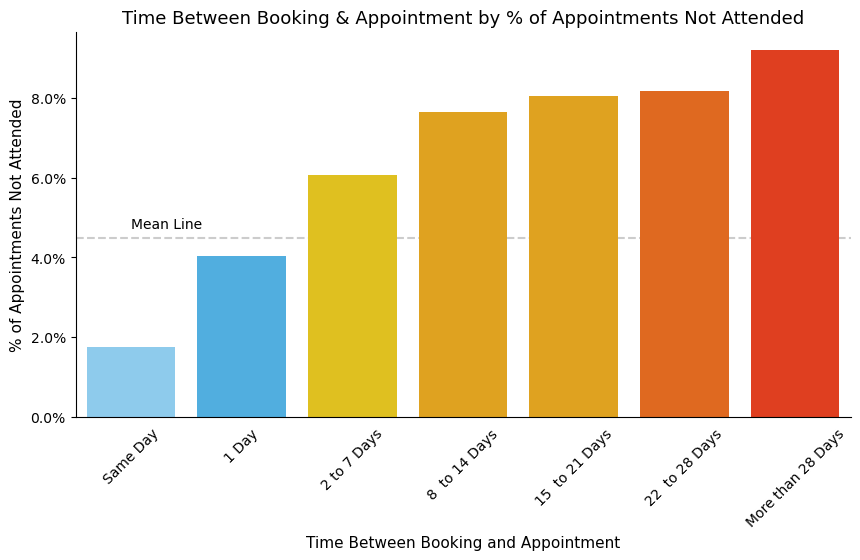

In [19]:
# Barplot of time between book and appointment by percentage of dna
fig, ax = plt.subplots(figsize=(10, 5))

# setup colour palette
# sns.set_palette('Paired')

# the average appointments not attended
df_mean = dna_mean

# use seaborn to plot the chart
by_time = sns.barplot(x='time_between_book_and_appointment', y='percentage_of_dna', \
                      data=ar_pivot_time_status, ax=ax, \
                      palette={'Same Day':'#7ed0fc', \
                               '1 Day':'#39b5f7', \
                               '2 to 7 Days':'#ffd500', \
                               '8  to 14 Days':'#ffae00', \
                               '15  to 21 Days':'#ffae00', \
                               '22  to 28 Days':'#ff6200', \
                               'More than 28 Days':'#ff2a00'})


# list of labels for x axis
for item in by_time.get_xticklabels():
    item.set_rotation(45)

# format the y axis labels
ax.ticklabel_format(style='plain', axis='y')

# plot the mean line
ax.axhline(y=df_mean, color='#CCCCCC', linestyle='--', zorder=0)

# label the axis
ax.text(0, df_mean+(df_mean*0.05),'Mean Line')
ax.set_xlabel(r'Time Between Booking and Appointment', size=11)
ax.set_ylabel(r'% of Appointments Not Attended', size=11)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Time Between Booking & Appointment by % of Appointments Not Attended", size=13)

# remove ticks (bottom) and despine (right and top)
ax.tick_params(left=True, bottom=False)
sns.despine(right=True, top=True)

# show plot
plt.show()

# export chart
fig.savefig('time_between_booking.png', dpi=300, bbox_inches='tight')

- Clear relationship showing as the time between booking and appointment is longer, so are the chances of a missed appointment.
- Appointments with a time gap of more than 28 days between booking have a 9.21% chance or being missed - more than double the national average.

<div class="alert alert-block alert-info"><b>NOTE:</b> Compare this data to a subset of the data filtered by only the London region. London is the region with the highest rate of missed appointments.</div>

In [20]:
# create subset with only London region data
ar_subset_london = ar_subset_post_covid.loc[ar_subset_post_covid['region_ons_name']=='London']

The function pivot_status used below can be found <a href='#76'>here</a>.

In [24]:
# pivot table for time_between_book_and_appointment by appointment status
ar_subset_london = pivot_status(ar_subset_london,'time_between_book_and_appointment', 0)
ar_subset_london['region'] = 'London'

In [25]:
# show the head
ar_subset_london.head(8)

time_between_book_and_appointment  sum_of_appointments  percentage_of_dna   
0            Unknown / Data Quality                61559               1.76  \
1                          Same Day             19337205               2.41   
2                             1 Day              4668673               5.10   
3                       2 to 7 Days             10193241               7.77   
4                     8  to 14 Days              5231452               9.69   
5                    15  to 21 Days              2228981               9.79   
6                    22  to 28 Days              1091623              10.06   
7                 More than 28 Days               671705              11.15   

   region  
0  London  
1  London  
2  London  
3  London  
4  London  
5  London  
6  London  
7  London

In [26]:
# drop row unknown quality
ar_subset_london.drop(0, axis=0, inplace=True)

In [27]:
# show the head
ar_subset_london.head(8)

time_between_book_and_appointment  sum_of_appointments  percentage_of_dna   
1                          Same Day             19337205               2.41  \
2                             1 Day              4668673               5.10   
3                       2 to 7 Days             10193241               7.77   
4                     8  to 14 Days              5231452               9.69   
5                    15  to 21 Days              2228981               9.79   
6                    22  to 28 Days              1091623              10.06   
7                 More than 28 Days               671705              11.15   

   region  
1  London  
2  London  
3  London  
4  London  
5  London  
6  London  
7  London

In [28]:
# concatenate subsets together
concat_subsets = pd.concat([ar_pivot_time_status, ar_subset_london], axis=0, join='inner')

In [29]:
# view the head
concat_subsets.reset_index().head(20)

index time_between_book_and_appointment  sum_of_appointments   
0       0                          Same Day            130976642  \
1       2                             1 Day             25872974   
2       3                       2 to 7 Days             60734100   
3       4                     8  to 14 Days             37507051   
4       5                    15  to 21 Days             19454328   
5       6                    22  to 28 Days             11430584   
6       7                 More than 28 Days              9880538   
7       1                          Same Day             19337205   
8       2                             1 Day              4668673   
9       3                       2 to 7 Days             10193241   
10      4                     8  to 14 Days              5231452   
11      5                    15  to 21 Days              2228981   
12      6                    22  to 28 Days              1091623   
13      7                 More than 28 Days               671705   

    percentage_of_dna       region  
0                1.75  All Regions  
1                4.04  All Regions  
2                6.08  All Regions  
3                7.65  All Regions  
4                8.06  All Regions  
5                8.18  All Regions  
6                9.21  All Regions  
7                2.41       London  
8                5.10       London  
9                7.77       London  
10               9.69       London  
11               9.79       London  
12              10.06       London  
13              11.15       London

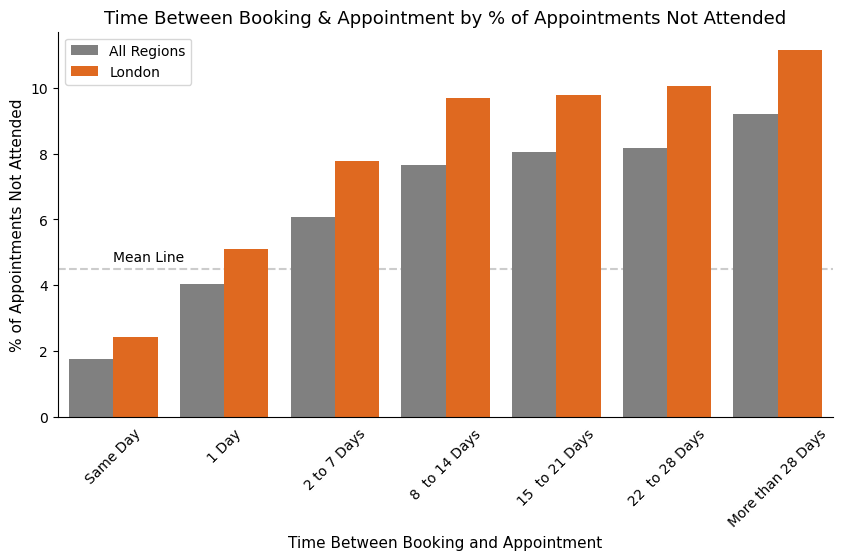

In [30]:
# Barplot of time between book and appointment by percentage of dna
fig, ax = plt.subplots(figsize=(10, 5))

# the average appointments not attended
df_mean = dna_mean

# use seaborn to plot the chart
by_time = sns.barplot(data=concat_subsets, \
                      x='time_between_book_and_appointment', \
                      y='percentage_of_dna', hue='region', \
                      palette=['#808080', '#ff6200'])


# list of labels for x axis
for item in by_time.get_xticklabels():
    item.set_rotation(45)

# format the y axis labels
ax.ticklabel_format(style='plain', axis='y')

# plot the mean line
ax.axhline(y=df_mean, color='#CCCCCC', linestyle='--', zorder=0)

# label the axis
ax.text(0, df_mean+(df_mean*0.05),'Mean Line')
ax.set_xlabel(r'Time Between Booking and Appointment', size=11)
ax.set_ylabel(r'% of Appointments Not Attended', size=11)
plt.title("Time Between Booking & Appointment by % of Appointments Not Attended", size=13)

# remove ticks (bottom) and despine (right and top)
ax.tick_params(left=True, bottom=False)
sns.despine(right=True, top=True)
plt.legend(loc='best')

# show plot
plt.show()

# export chart
fig.savefig('time_between_booking_london.png', dpi=300, bbox_inches='tight')

- The graph shows that the chance of missed appointments from the London region is higher in every category.

### Appointment Mode

In [33]:
# read the table from the database
ar_pivot_mode_status = pd.read_sql('SELECT * from ar_pivot_mode_status', engine)

In [34]:
ar_pivot_mode_status.head()

appointment_mode  sum_of_appointments  percentage_of_dna
0        Telephone            100274881               2.09
1          Unknown              8733661               3.50
2       Home Visit              1991144               3.94
3     Video/Online              1543497               5.02
4     Face-to-Face            183503587               5.86

In [35]:
# Change dtype to ordered category
ar_pivot_mode_status['appointment_mode'] = ar_pivot_mode_status['appointment_mode']. \
       astype(pd.api.types.CategoricalDtype(categories=['Unknown',
                                                        'Telephone',
                                                        'Home Visit',
                                                        'Video/Online',
                                                        'Face-to-Face'], ordered=True))

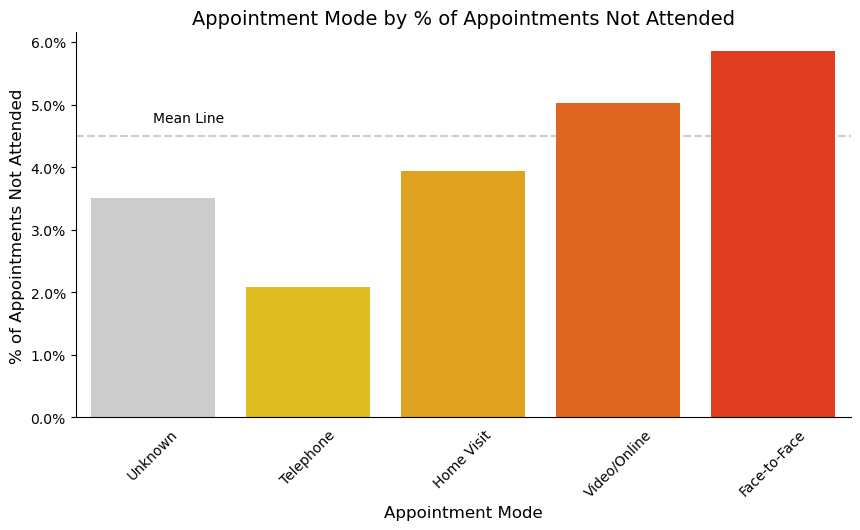

In [36]:
# Create a barplot.
# Barplot of appointment mode by percentage of dna
fig, ax = plt.subplots(figsize=(10, 5))

# the average appointments not attended
df_mean = dna_mean

# use seaborn to plot the chart
by_mode = sns.barplot(x='appointment_mode', y='percentage_of_dna', \
                      data=ar_pivot_mode_status, ax=ax, \
                      palette={'Telephone':'#ffd000', \
                               'Unknown':'#cccccc', \
                               'Home Visit':'#ffae00', \
                               'Video/Online':'#ff5e00', \
                               'Face-to-Face':'#ff2a00'})

# list of labels for x axis
for item in by_mode.get_xticklabels():
    item.set_rotation(45)

# format the y axis labels
ax.ticklabel_format(style='plain', axis='y')

# plot the mean line
ax.axhline(y=df_mean, color='#CCCCCC', linestyle='--', zorder=0)

# label the axis
ax.text(0, df_mean+(df_mean*0.05),'Mean Line')
ax.set_xlabel(r'Appointment Mode', size=12)
ax.set_ylabel(r'% of Appointments Not Attended', size=12)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
plt.title("Appointment Mode by % of Appointments Not Attended", size=14)

# remove ticks (bottom) and despine (right and top)
ax.tick_params(left=True, bottom=False)
sns.despine(right=True, top=True)

plt.show()

# export chart
fig.savefig('appointment_mode.png', dpi=300, bbox_inches='tight')

- Appointments by telephone and home visit are least likely to be missed. 
- Patients are most likely to miss Face-to-Face appointments which are meeting at the GP surgery.

### (iv) Is there a relationship between sum of the appointments and patients not attending?

In [37]:
# create a pivot table from the post-covid subset and aggregate by sum of appointments 
# and average gp_per_100000
ar_pivot_month_region = pd.pivot_table(ar_subset_post_covid, values =['count_of_appointments', 'gp_per_100000'], \
                         index =['appointment_date','region_ons_name'], \
                         columns =['appointment_status'], \
                         aggfunc={'count_of_appointments':np.sum, 'gp_per_100000':np.mean})

# calculate new columns 
# sum of all appoinments
ar_pivot_month_region['sum_of_appointments'] = ar_pivot_month_region['count_of_appointments']['Attended'] \
                                             + ar_pivot_month_region['count_of_appointments']['DNA'] \
                                             + ar_pivot_month_region['count_of_appointments']['Unknown']
# percentage of dna appointments
ar_pivot_month_region['percentage_of_DNA'] = round((ar_pivot_month_region['count_of_appointments']['DNA'] \
                                                   /ar_pivot_month_region['sum_of_appointments'])*100,2)
# gp_per_100000 by region
ar_pivot_month_region['gps_per_100000'] = round(ar_pivot_month_region['gp_per_100000']['DNA'],2)
                 
# drop columns that won't be used
ar_pivot_month_region.drop(['count_of_appointments', 'gp_per_100000'], axis=1, inplace=True)

#drop multilevel index and reset
ar_pivot_month_region.columns = ar_pivot_month_region.columns.droplevel(1)
ar_pivot_month_region = ar_pivot_month_region.reset_index()

In [38]:
# show head
ar_pivot_month_region.head(7)

appointment_date           region_ons_name  sum_of_appointments   
0       2021-08-01           East of England              2723599  \
1       2021-08-01                    London              3541514   
2       2021-08-01                  Midlands              4637457   
3       2021-08-01  North East and Yorkshire              3852537   
4       2021-08-01                North West              2862341   
5       2021-08-01                South East              3625648   
6       2021-08-01                South West              2609075   

   percentage_of_DNA  gps_per_100000  
0               2.97           52.56  
1               5.12           50.64  
2               3.99           59.51  
3               3.48           59.24  
4               5.04           61.89  
5               3.76           52.48  
6               3.33           61.23

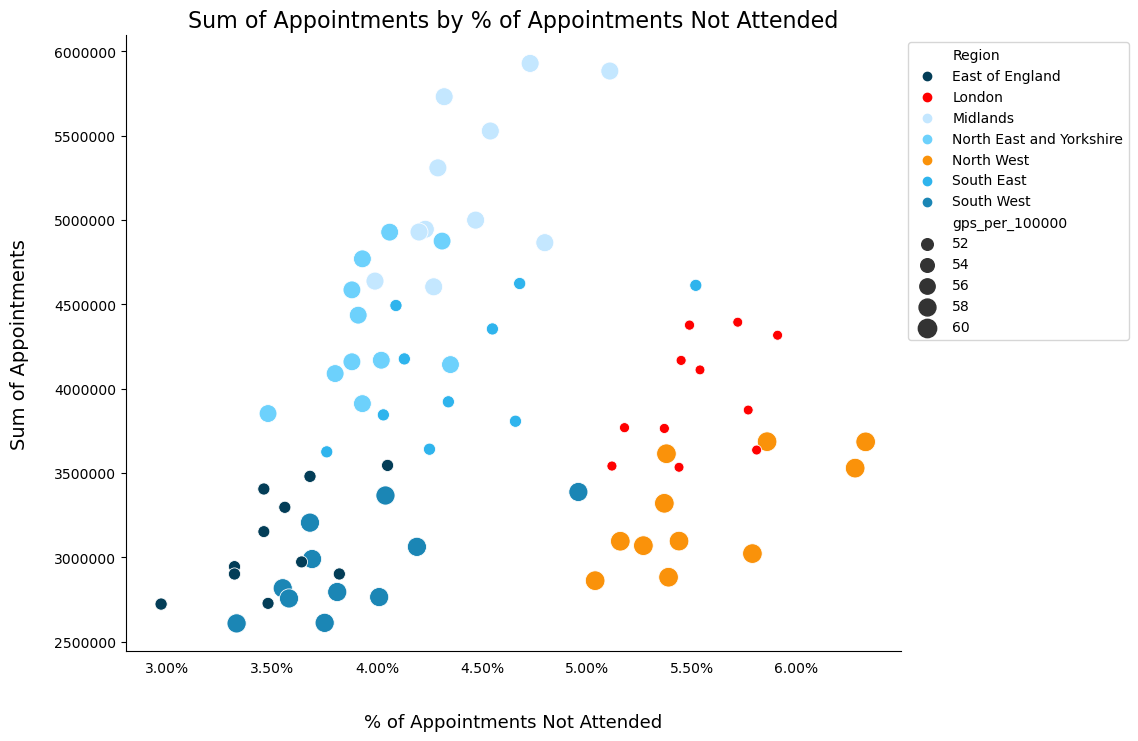

In [39]:
# setup figure
fig, ax = plt.subplots(figsize=(10, 8))

# Create the scatterplot.
sns.scatterplot(x='percentage_of_DNA',
                y='sum_of_appointments', hue='region_ons_name',
                size='gps_per_100000',
                data=ar_pivot_month_region,
                sizes=(50,200),
                legend='brief',
                palette={'East of England':'#033d57', \
                         'Midlands':'#c4e7ff', \
                         'North East and Yorkshire':'#6dd1fc', \
                         'North West':'#fa920a', \
                         'South East':'#2fb4ed', \
                         'South West':'#1b86b5', \
                         'London':'r'})

# show full tick labels on y axis
ax.ticklabel_format(style='plain', axis='y')
ax.set_xlabel(r'% of Appointments Not Attended', size=13)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel(r'Sum of Appointments', size=14)
plt.title("Sum of Appointments by % of Appointments Not Attended", size=16)

# adjust axis label positions
ax.xaxis.set_label_coords(.5, -.1)
ax.yaxis.set_label_coords(-.125, .5)

# remove ticks (bottom) and despine (right and top)
ax.tick_params(left=True, bottom=False)
sns.despine(right=True, top=True)

# show legend outside the chart on the left side
plt.legend(bbox_to_anchor=(1.0, 1.0), loc='upper left').get_texts()[0].set_text('Region')

# show plot
plt.show()

# export chart
fig.savefig('scatterplot_region_status.png', dpi=300, bbox_inches='tight')

- The scatterplot illustrates the relationships between the different regions, the number of GPs per 100000 population, and the percentage of appointments not attended.
- There are two regional groups: (group 1) London, North West, (group 2) East of England, Midlands, North East & Yorkshire, South East, South West.
- Group 1 London: Shows high rates of missed appointments, along with low GP numbers per 100000 population. No obvious relationship with the sum of apppointments.
- Group 1 North West: High GP numbers per 100000 population, low sum of appointments. It is difficult to guess any reason for the high number of missed appointments.
- Group 2: There is a relationship between the sum of appointments and the % of appointments not attended. This will be explored in a separate chart below.

### A linear regression plot and scatterplot removing London and North West regions

In [42]:
# remove London & North West regions from dataset
ar_pivot_month_region_subset = ar_pivot_month_region[ \
                               (ar_pivot_month_region['region_ons_name'] != 'London') & \
                               (ar_pivot_month_region['region_ons_name'] != 'North West')]

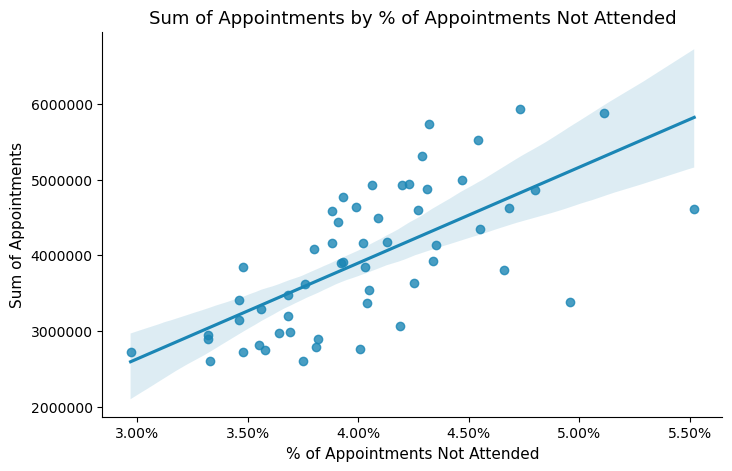

In [43]:
# Create the regplot with line of best fit
# setup figure
fig, ax = plt.subplots(figsize=(8, 5))

# plot a quick regression plot
sns.regplot(x='percentage_of_DNA',
               y='sum_of_appointments',
               data=ar_pivot_month_region_subset, color='#1b86b5')

# show full tick labels on y axis
ax.ticklabel_format(style='plain', axis='y')
ax.set_xlabel(r'% of Appointments Not Attended', size=11)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel(r'Sum of Appointments', size=11)
plt.title("Sum of Appointments by % of Appointments Not Attended", size=13)

# remove ticks (bottom) and despine (right and top)
sns.despine(right=True, top=True)

# show chart
plt.show()

# export chart
fig.savefig('regplot_region_status.png', dpi=300, bbox_inches='tight')

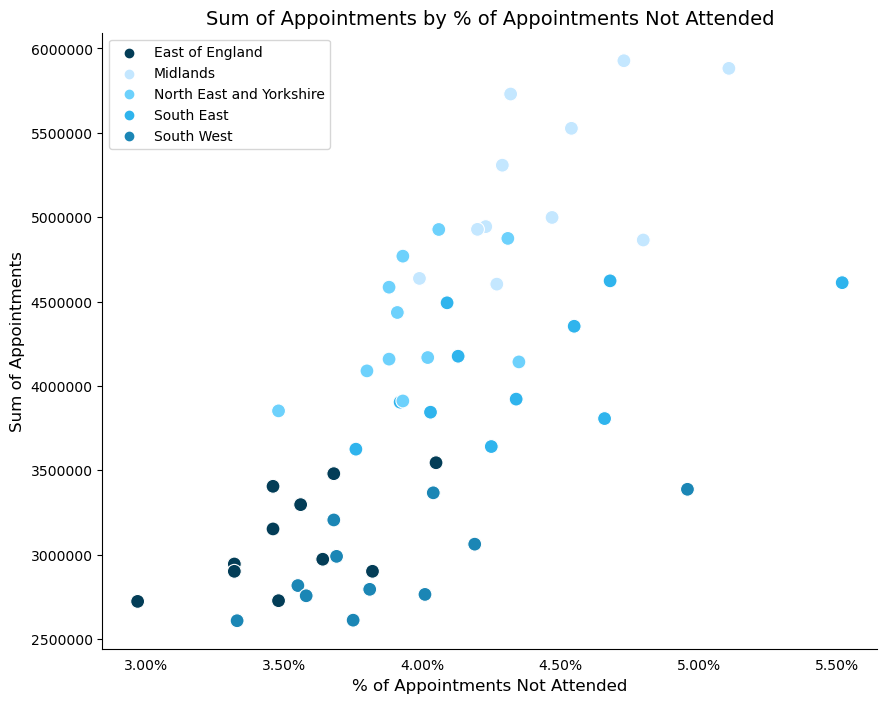

In [44]:
# Create the scatterplot
# setup figure
fig, ax = plt.subplots(figsize=(10, 8))

# create plot
sns.scatterplot(x='percentage_of_DNA',
               y='sum_of_appointments',
               data=ar_pivot_month_region_subset,
               hue='region_ons_name',
               s=100,
               legend='brief',
               palette={'East of England':'#033d57', \
                        'Midlands':'#c4e7ff', \
                        'North East and Yorkshire':'#6dd1fc', \
                        'South East':'#2fb4ed', \
                        'South West':'#1b86b5'})

# show full tick labels on y axis
ax.ticklabel_format(style='plain', axis='y')
ax.set_xlabel(r'% of Appointments Not Attended', size=12)
ax.xaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel(r'Sum of Appointments', size=12)
plt.title("Sum of Appointments by % of Appointments Not Attended", size=14)

# plot legend
plt.legend(loc='best')

# remove ticks (bottom) and despine (right and top)
ax.tick_params(left=True, bottom=False)
sns.despine(right=True, top=True)

# show plot
plt.show()

# export chart
fig.savefig('scatterplot_region_status_no_london.png', dpi=300, bbox_inches='tight')

- The regplot and scatterplot show the positive correlation between sum of appointments and the percentage of missed appointments. This indicates that as GP surgeries get busier, appointments will more likely to be missed.

### Lineplots to illustrate the relationship between region, total appointments & % of missed appointments

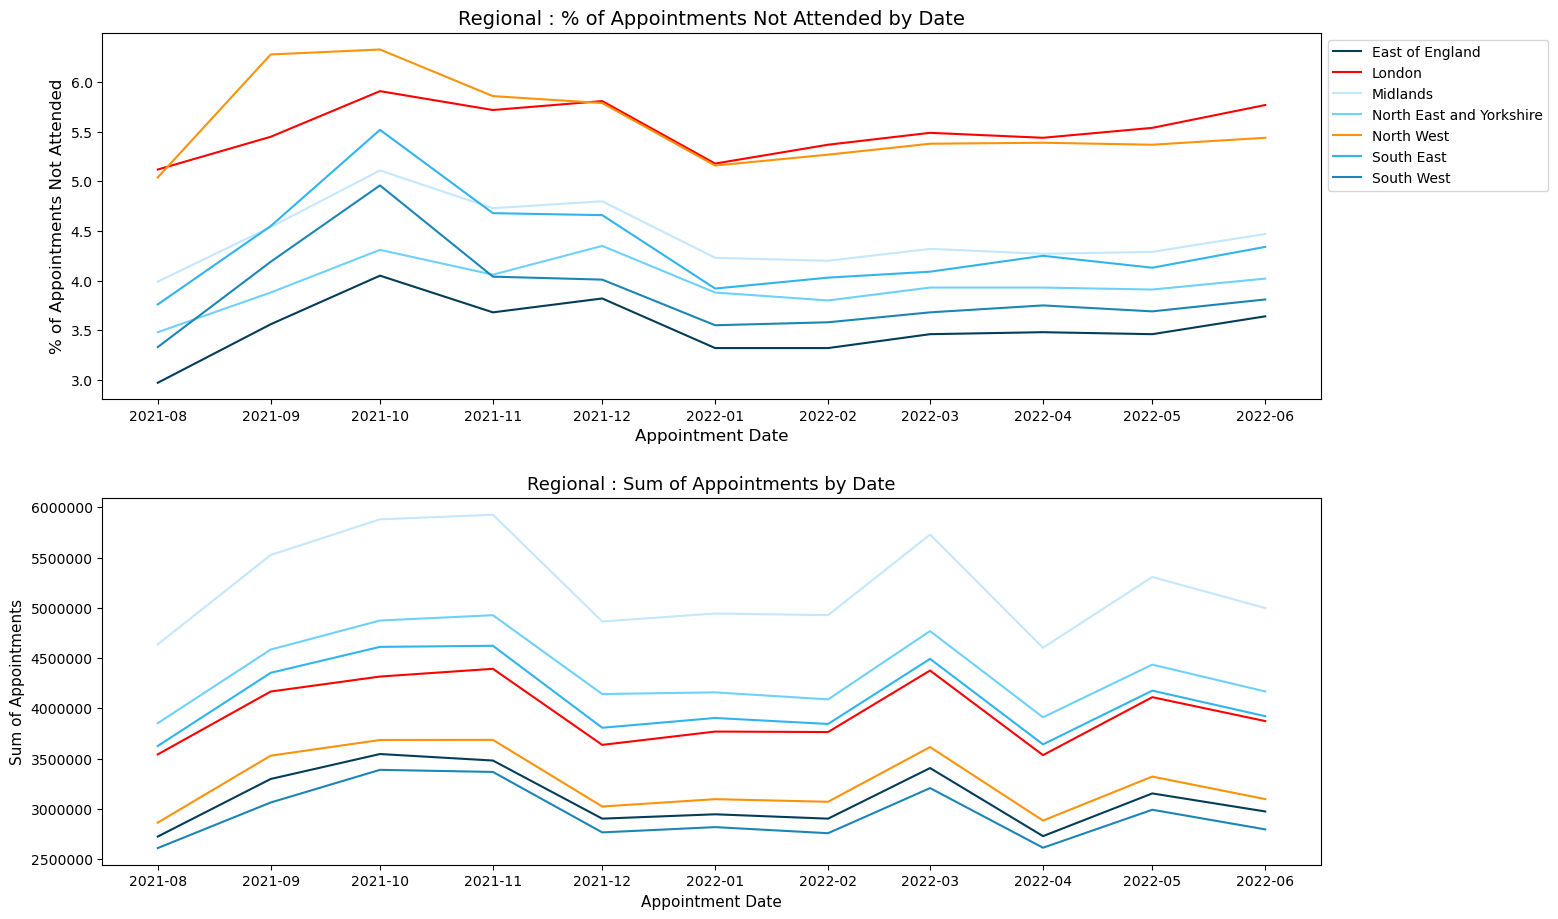

In [45]:
# Alternative methods.
fig, ax = plt.subplots(2)
fig.set_size_inches(14, 10)
fig.tight_layout(pad=5.0)

# Create lineplots.
sns.lineplot(x='appointment_date',
             y='percentage_of_DNA',
             ax=ax[0],
             hue='region_ons_name',
             data=ar_pivot_month_region,
             palette={'East of England':'#033d57', \
                      'Midlands':'#c4e7ff', \
                      'North East and Yorkshire':'#6dd1fc', \
                      'North West':'#fa920a', \
                      'South East':'#2fb4ed', \
                      'South West':'#1b86b5', \
                      'London':'r'})

ax[0].set_xlabel(r'Appointment Date', size=12)
ax[0].set_ylabel(r'% of Appointments Not Attended', size=12)
ax[0].set_title('Regional : % of Appointments Not Attended by Date', size=14)
# ax[0].get_legend().remove()
ax[0].legend(bbox_to_anchor=(1.0, 1.0), loc='upper left')

sns.lineplot(x='appointment_date',
             y='sum_of_appointments',
             ax=ax[1],
             hue='region_ons_name',
             data=ar_pivot_month_region,
             palette={'East of England':'#033d57', \
                      'Midlands':'#c4e7ff', \
                      'North East and Yorkshire':'#6dd1fc', \
                      'North West':'#fa920a', \
                      'South East':'#2fb4ed', \
                      'South West':'#1b86b5', \
                      'London':'r'})

# show full tick labels on y axis
ax[1].ticklabel_format(style='plain', axis='y')

ax[1].set_xlabel(r'Appointment Date', size=11)
ax[1].set_ylabel(r'Sum of Appointments', size=11)
ax[1].set_title('Regional : Sum of Appointments by Date', size=13)
ax[1].get_legend().remove()
# ax[1].legend(bbox_to_anchor=(0.5, -0.65), loc='lower center')

# View the lineplots.
plt.show()

# export chart
fig.savefig('linechart_region_status.png', dpi=300, bbox_inches='tight')

- The top linechart above clearly shows that London and the North West regions have much higher percentage of missed appointments.
- The bottom linechart shows that London and North West have low to medium sum of appointments in comparison to the other regions.
- We can conclude that simply analysing the sum of appointments will not be a reliable incidator of missed appointments.

### (vi) Do missed appointments differ by healthcare professional over time?

In [46]:
# remove unknown category
ar_subset_dna = ar_subset_post_covid.loc[ar_subset_post_covid['appointment_status']!='DNA']

In [47]:
# create groupby month for healthcare professional type
ar_groupby_month_hcp = ar_subset_dna.groupby(['hcp_type', 'appointment_date']) \
                                             ['count_of_appointments'].sum().reset_index()

In [48]:
# remove unknown category
ar_groupby_month_hcp = ar_groupby_month_hcp.loc[ar_groupby_month_hcp['hcp_type']!='Unknown']

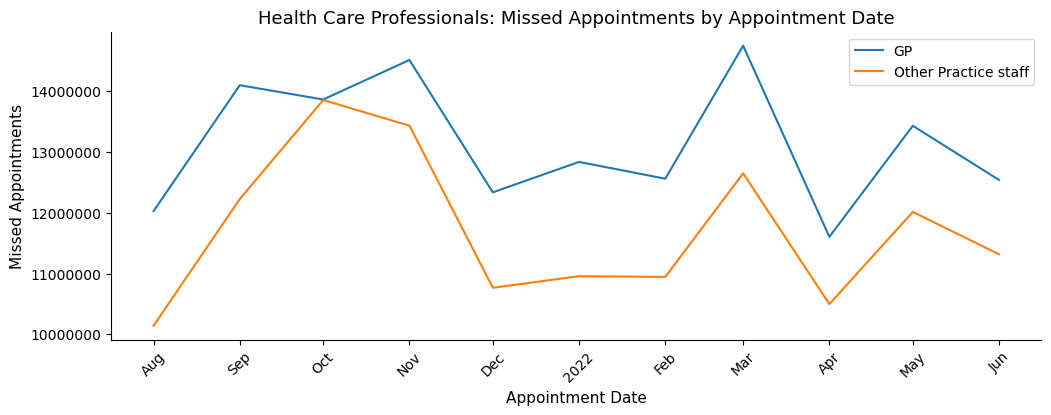

In [49]:
# create figure
fig, ax = plt.subplots(figsize=(12, 4))

major_locator = AutoDateLocator()
formatter = ConciseDateFormatter(major_locator)
ax.xaxis.set_major_formatter(formatter)

ax.ticklabel_format(style='plain', axis='y')

# create plot
sns.lineplot(data=ar_groupby_month_hcp, x='appointment_date', y='count_of_appointments', hue='hcp_type')
plt.xticks(rotation=45)

# show full tick labels on y axis
ax.ticklabel_format(style='plain', axis='y')
ax.set_xlabel(r'Appointment Date', size=11)
ax.set_ylabel(r'Missed Appointments', size=11)
plt.title("Health Care Professionals: Missed Appointments by Appointment Date", size=13)

# plot legend
plt.legend(loc='best')

# despine (right and top)
sns.despine(right=True, top=True)

# show plot
plt.show()

- The lineplot for healthcare professionals does not highlight anything irregular.
- There are typical peak demand for appointments in October 2021 and March 2022.

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">9. Analyse The Twitter Data</h2></th>
        <th><a id='9'></a><a href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

In [50]:
# Read the nc table from the database
tweets = pd.read_sql('SELECT * from tweets', engine)

In [51]:
# show the shape of the dataset
tweets.shape

(1174, 10)

In [52]:
# describe the the dataset
tweets.describe()

tweet_id  tweet_retweet_count  tweet_favorite_count
count  1.174000e+03          1174.000000            1174.00000
mean   1.567612e+18             8.629472               0.37138
std    2.427553e+13            29.784675               2.04470
min    1.567574e+18             0.000000               0.00000
25%    1.567590e+18             0.000000               0.00000
50%    1.567611e+18             1.000000               0.00000
75%    1.567633e+18             3.000000               0.00000
max    1.567655e+18           303.000000              42.00000

In [53]:
# show the info of the dataset
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1174 entries, 0 to 1173
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   tweet_id                 1174 non-null   int64 
 1   tweet_full_text          1174 non-null   object
 2   tweet_entities           1174 non-null   object
 3   tweet_entities_hashtags  1007 non-null   object
 4   tweet_metadata           1174 non-null   object
 5   tweet_retweet_count      1174 non-null   int64 
 6   tweet_favorite_count     1174 non-null   int64 
 7   tweet_favorited          1174 non-null   bool  
 8   tweet_retweeted          1174 non-null   bool  
 9   tweet_lang               1174 non-null   object
dtypes: bool(2), int64(3), object(5)
memory usage: 75.8+ KB


In [54]:
# show the head of the dataset
tweets.head()

tweet_id                                    tweet_full_text   
0  1567629223795527681  As Arkansas’ first Comprehensive Stroke Certif...  \
1  1567582846612553728  RT @AndreaGrammer: Work-life balance is at the...   
2  1567582787070304256  RT @OntarioGreens: $10 billion can go a long w...   
3  1567582767625428992  RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies...   
4  1567582720460570625  ICYMI: Our recent blogs on Cybersecurity in Ac...   

                                      tweet_entities   
0  {'hashtags': [{'text': 'Healthcare', 'indices'...  \
1  {'hashtags': [{'text': 'PremiseHealth', 'indic...   
2  {'hashtags': [{'text': 'Healthcare', 'indices'...   
3  {'hashtags': [{'text': 'NEW', 'indices': [20, ...   
4  {'hashtags': [{'text': 'blogs', 'indices': [18...   

                             tweet_entities_hashtags   
0                                        #Healthcare  \
1                            #PremiseHealth, #hiring   
2                                        #Healthcare   
3                                               #NEW   
4  #blogs, #digitaltransformation, #cybersecurity...   

                                      tweet_metadata  tweet_retweet_count   
0  {'iso_language_code': 'en', 'result_type': 're...                    0  \
1  {'iso_language_code': 'en', 'result_type': 're...                    2   
2  {'iso_language_code': 'en', 'result_type': 're...                   39   
3  {'iso_language_code': 'en', 'result_type': 're...                    5   
4  {'iso_language_code': 'en', 'result_type': 're...                    0   

   tweet_favorite_count  tweet_favorited  tweet_retweeted tweet_lang  
0                     0            False            False         en  
1                     0            False            False         en  
2                     0            False            False         en  
3                     0            False            False         en  
4                     0            False            False         en

In [55]:
# show the count of column tweet_retweet_count
tweets['tweet_retweet_count'].value_counts()

tweet_retweet_count
0      526
1      215
2      114
3       70
5       35
4       27
7       18
12      16
8       15
73      14
9       13
6       12
208     12
35      10
37       6
11       6
10       5
53       5
44       4
150      4
63       4
76       3
85       3
41       3
62       3
207      3
68       3
78       2
23       2
24       2
72       2
16       2
13       1
49       1
48       1
15       1
107      1
14       1
79       1
20       1
39       1
19       1
303      1
57       1
40       1
54       1
169      1
Name: count, dtype: int64

In [56]:
# show the count of column tweet_favorite_count
tweets['tweet_favorite_count'].value_counts()

tweet_favorite_count
0     1027
1       91
2       16
3       13
4        7
5        5
6        2
17       1
12       1
10       1
8        1
13       1
11       1
7        1
20       1
28       1
14       1
18       1
9        1
42       1
Name: count, dtype: int64

In [57]:
# create new dataframe with only the object (string) datatypes
tweets_text = tweets[['tweet_full_text', 'tweet_entities', \
                      'tweet_entities_hashtags', 'tweet_metadata', \
                      'tweet_lang']]

tweets_text.head()

tweet_full_text   
0  As Arkansas’ first Comprehensive Stroke Certif...  \
1  RT @AndreaGrammer: Work-life balance is at the...   
2  RT @OntarioGreens: $10 billion can go a long w...   
3  RT @modrnhealthcr: 🚨#NEW:🚨 Insurance companies...   
4  ICYMI: Our recent blogs on Cybersecurity in Ac...   

                                      tweet_entities   
0  {'hashtags': [{'text': 'Healthcare', 'indices'...  \
1  {'hashtags': [{'text': 'PremiseHealth', 'indic...   
2  {'hashtags': [{'text': 'Healthcare', 'indices'...   
3  {'hashtags': [{'text': 'NEW', 'indices': [20, ...   
4  {'hashtags': [{'text': 'blogs', 'indices': [18...   

                             tweet_entities_hashtags   
0                                        #Healthcare  \
1                            #PremiseHealth, #hiring   
2                                        #Healthcare   
3                                               #NEW   
4  #blogs, #digitaltransformation, #cybersecurity...   

                                      tweet_metadata tweet_lang  
0  {'iso_language_code': 'en', 'result_type': 're...         en  
1  {'iso_language_code': 'en', 'result_type': 're...         en  
2  {'iso_language_code': 'en', 'result_type': 're...         en  
3  {'iso_language_code': 'en', 'result_type': 're...         en  
4  {'iso_language_code': 'en', 'result_type': 're...         en

In [58]:
# split the hashtags from the tweet_full_text column 
# and store in the tags variable
tags = []

for y in [x.split(' ') for x in tweets['tweet_full_text'].values]:
    for z in y:
        if '#' in z:
            # Change to lowercase.
            tags.append(z.lower())
            
tags

['#healthcare',
 '#premisehealth',
 '#hiring',
 '#healthcare',
 '🚨#new:🚨',
 'look!\n\n#blogs',
 '#digitaltransformation',
 '#cybersecurity',
 '#accounting',
 '#finance',
 '#healthcare',
 'https://t.co/jrgqeqdme4\n.\n#firstcoastcna',
 '#cnaexam',
 '#cnaexampreparation',
 '#jacksonville',
 '#cnatraining',
 '#nurse',
 '#nursing',
 '#nurselife',
 '#nursepractitioner',
 '#nurseproblems',
 '#nursingschool',
 '#healthcare',
 '🚨#new:🚨',
 '#disparities.',
 '@karahartnett\n#healthcare',
 '#alert',
 '#insurance',
 '#data\nhttps://t.co/h9hlamr7p9',
 '#healthcare',
 '#healthcare',
 '❤️\n\n#healthcare',
 '#healthcare',
 '#hcldr',
 '#premisehealth',
 '#hiring',
 '#premisehealth',
 '#hiring',
 '#healthcare',
 '#qualitypatientcare',
 '#jobs',
 '#job',
 '#ascp2022',
 '#ascp100.',
 '#healthcare',
 '#healthsecretary',
 '#healthcare',
 '#ai,',
 '#sdoh,',
 '#healthcare',
 '\nhttps://t.co/ewe7jntj1e\n#tropicana',
 '#real',
 '#juice',
 '#healthcare',
 '#watch',
 '#worms',
 '#fruits',
 '#healthtips',
 '#tips',

In [59]:
# turn the tags variable into a pandas series
series_tags = pd.Series(tags)

# show the head of the pandas series
series_tags.head()

0       #healthcare
1    #premisehealth
2           #hiring
3       #healthcare
4           🚨#new:🚨
dtype: object

In [60]:
# create new dataframe named data to store the pandas series
# aggregate the tags using value_counts to get the count of each hashtag in the dataset
data = series_tags.value_counts().reset_index()

# show the head
data.head(30)

index  count
0                   #healthcare    716
1                       #health     80
2                     #medicine     41
3                           #ai     40
4                          #job     38
5                      #medical     35
6                     #strategy     30
7               #pharmaceutical     28
8                #digitalhealth     25
9                    #marketing     25
10                      #pharma     25
11     #competitiveintelligence     24
12                     #biotech     24
13                  #medtwitter     24
14                       #meded     23
15                      #hiring     18
16                     #vaccine     18
17             #machinelearning     17
18                        #news     17
19                  #technology     17
20             #womeninmedicine     16
21                 #coronavirus     16
22                       #covid     16
23        #competitivemarketing     16
24                  #healthtech     15
25                    #wellness     15
26                    #medicare     14
27  #doctorofveterinarymedicine     14
28                     #covid19     14
29                     #science     14

In [61]:
# rename the index column to be word, this column stores the hashtags
data.rename(columns = {'index':'word'}, inplace = True)

In [62]:
# show the info of the new dataframe
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1754 entries, 0 to 1753
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   word    1754 non-null   object
 1   count   1754 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 27.5+ KB


In [63]:
# describe the new dataframe
data.describe()

count
count  1754.000000
mean      2.470353
std      17.462844
min       1.000000
25%       1.000000
50%       1.000000
75%       2.000000
max     716.000000

In [64]:
# subset the dataframe to be count greater than 25
data_subset = data.loc[data['count'] > 25]

In [65]:
# show the shape
data_subset.shape

(8, 2)

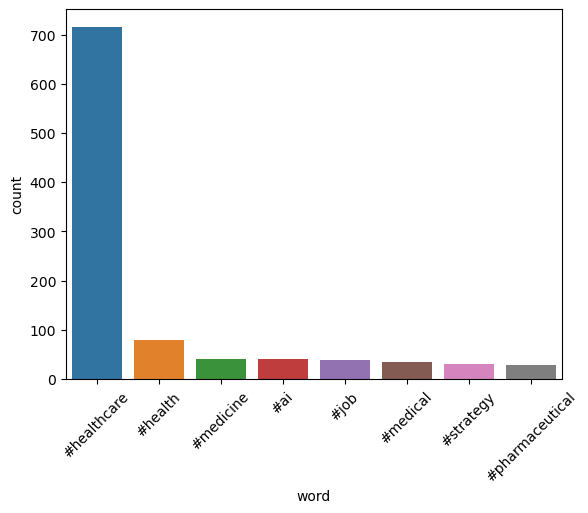

In [66]:
# plot the subset using barplot
sns.barplot(x='word', y='count', data=data_subset)
plt.xticks(rotation=45)
 
# Show the plot
plt.show()

- #healthcare was by far the top hashtag reported in this dataset, used more than 700 times.
- #health, #medicine, #medical, #pharmaceutical hashtags show up in the top 8.

> As a measure of public sentiment, analysis of real-time or historical social media data can provide valuable insights into the users/patients of the NHS.

<table width="100%">
<thead>
    <tr style="background-color:#D6EEEE">
        <th><h2 style="text-align:left">10. Recommendations</h2></th>
        <th><a id='10'></a><a href='#top'>Back to Top</a></th>
    </tr>
</thead>
</table>

### Key recommendations:
1. Healthcare Professional (HCP) types: the data needs to be improved, to include more detail about which type in the "Other Practice Staff" category.

2. Actual Duration: the data will be more useful if it can be assiged to a national category and/or HCP type, then we can see how long appointments take relating to the task.

3. National category could include the data for missed appointments.

4. Target improving the time between booking and appointment. Some appointments will require the longer time gap, but for others a shorter gap may reduce the amount of missed appointments (to less than 1 week).

5. Anonymised social media sentiment analysis can be utilised during the busiest periods to identify when staff shortages are effecting patient.

<hr>

### Further analysis of missed appointments should be focused on:
1. The usage of resources by national category, compare the ICB locations with high/low number of missed appointments to identify any trends or relationships.
2. A more granular look into the Sub-ICB location level, in particular the North West region, may show how the usage of resources differ.
3. GPs per 100000 population are low in the London region, could there be other staff shortages (e.g., Nurse, Physio) which increase the length of time between booking and appointment date?
<hr>

### Python Code for Suggested Further Analysis

### 1. Combine data from the national_categories and appointments_regional datasets

In [67]:
# Read the nc table from the database
nc_dna = pd.read_sql('SELECT n.*, s.dna_status, s.gp_status \
                  FROM nc AS n, ar_pivot_icb_status AS s \
                  WHERE n.icb_ons_name = s.icb_ons_name \
                  ORDER BY n.appointment_date', engine)

In [68]:
# show the head
nc_dna.head()

appointment_date icb_ons_code                     icb_ons_name   
0       2021-08-01    E54000051  NHS Humber and North Yorkshire   \
1       2021-08-01    E54000051  NHS Humber and North Yorkshire    
2       2021-08-01    E54000051  NHS Humber and North Yorkshire    
3       2021-08-01    E54000052           NHS Surrey Heartlands    
4       2021-08-01    E54000052           NHS Surrey Heartlands    

            region_ons_name   service_setting            context_type   
0  North East and Yorkshire             Other  Care Related Encounter  \
1  North East and Yorkshire             Other  Care Related Encounter   
2  North East and Yorkshire             Other  Care Related Encounter   
3                South East  General Practice  Care Related Encounter   
4                South East  General Practice  Care Related Encounter   

              national_category appointment_dayofweek  appointment_month   
0               Clinical Triage                Sunday                  8  \
1    General Consultation Acute                Sunday                  8   
2               Planned Clinics                Sunday                  8   
3    General Consultation Acute                Sunday                  8   
4  General Consultation Routine                Sunday                  8   

  appointment_season  appointment_year  gp_per_100000  count_of_appointments   
0             Summer              2021          58.50                     13  \
1             Summer              2021          58.50                     18   
2             Summer              2021          58.50                     22   
3             Summer              2021          54.35                      5   
4             Summer              2021          54.35                     52   

  dna_status gp_status  
0     Medium        OK  
1     Medium        OK  
2     Medium        OK  
3     Medium        OK  
4     Medium        OK

### Compare % of missed appointments low vs. high by national categories

In [69]:
# pivot table showing the national category by the status of missed appointments pulled in from the 
# appointments_regional dataset
experiment_1 = pd.pivot_table(nc_dna, values ='count_of_appointments',
    index =['national_category'],
    columns =['dna_status'], aggfunc = np.sum).reset_index()

experiment_1['sum_of_appointments'] = experiment_1['High'] + experiment_1['Low'] + experiment_1['Medium']
experiment_1['percentage_of_low'] = (experiment_1['Low']/experiment_1['sum_of_appointments'])*100
experiment_1['percentage_of_high'] = (experiment_1['High']/experiment_1['sum_of_appointments'])*100

experiment_1.sort_values(by='sum_of_appointments', ascending=False)

dna_status                                  national_category      High   
4                                General Consultation Routine  24492433  \
3                                  General Consultation Acute  13765987   
2                                             Clinical Triage  11002101   
11                                            Planned Clinics   4950882   
7                                        Inconsistent Mapping   8149394   
10                                 Planned Clinical Procedure   5211480   
15                                                   Unmapped   2151462   
16                                Unplanned Clinical Activity    455764   
6                                                  Home Visit    581215   
14                               Structured Medication Review    286988   
12          Service provided by organisation external to t...    216950   
9                      Patient contact during Care Home Round    159186   
1                                             Care Home Visit    145481   
13                                 Social Prescribing Service    106430   
17                                                    Walk-in     68017   
0           Care Home Needs Assessment & Personalised Care...     77332   
8                             Non-contractual chargeable work     38538   
5                      Group Consultation and Group Education      8003   

dna_status      Low    Medium  sum_of_appointments  percentage_of_low   
4           9809769  62969320             97271522          10.084934  \
3           5539008  34386155             53691150          10.316426   
2           4029522  26515341             41546964           9.698716   
11          3363025  19705841             28019748          12.002338   
7           2108082  17633326             27890802           7.558341   
10          2252920  18238294             25702694           8.765307   
15          1596701   7332647             11080810          14.409605   
16           442921   2157109              3055794          14.494465   
6            156170   1407067              2144452           7.282513   
14           308412   1262979              1858379          16.595754   
12            84722    550461               852133           9.942345   
9             60044    591100               810330           7.409821   
1             44248    438550               628279           7.042731   
13           119902    249496               475828          25.198601   
17            50745    293676               412438          12.303667   
0             70963    257609               405904          17.482705   
8              8287     92086               138911           5.965690   
5              1594     51035                60632           2.628975   

dna_status  percentage_of_high  
4                    25.179449  
3                    25.639211  
2                    26.481119  
11                   17.669260  
7                    29.218930  
10                   20.276007  
15                   19.416108  
16                   14.914749  
6                    27.103195  
14                   15.442921  
12                   25.459641  
9                    19.644589  
1                    23.155477  
13                   22.367326  
17                   16.491448  
0                    19.051795  
8                    27.742943  
5                    13.199301

In [70]:
# filter by high DNA only!!!
nc_dna_high = nc_dna.loc[nc_dna['dna_status']=='High'].reset_index()

nc_dna_high = nc_dna_high.groupby('national_category')['count_of_appointments'].sum().reset_index()

nc_dna_high['%'] = (nc_dna_high['count_of_appointments']/nc_dna_high['count_of_appointments'].sum())*100

nc_dna_high.sort_values(by='%', ascending=False).head(20)

national_category  count_of_appointments   
4                        General Consultation Routine               24492433  \
3                          General Consultation Acute               13765987   
2                                     Clinical Triage               11002101   
7                                Inconsistent Mapping                8149394   
10                         Planned Clinical Procedure                5211480   
11                                    Planned Clinics                4950882   
15                                           Unmapped                2151462   
6                                          Home Visit                 581215   
16                        Unplanned Clinical Activity                 455764   
14                       Structured Medication Review                 286988   
12  Service provided by organisation external to t...                 216950   
9              Patient contact during Care Home Round                 159186   
1                                     Care Home Visit                 145481   
13                         Social Prescribing Service                 106430   
0   Care Home Needs Assessment & Personalised Care...                  77332   
17                                            Walk-in                  68017   
8                     Non-contractual chargeable work                  38538   
5              Group Consultation and Group Education                   8003   

            %  
4   34.079917  
3   19.154638  
2   15.308838  
7   11.339448  
10   7.251497  
11   6.888889  
15   2.993645  
6    0.808730  
16   0.634171  
14   0.399329  
12   0.301874  
9    0.221499  
1    0.202429  
13   0.148092  
0    0.107603  
17   0.094642  
8    0.053624  
5    0.011136

In [71]:
# filter by low DNA only!!!
nc_dna_low = nc_dna.loc[nc_dna['dna_status']=='Low'].reset_index()

nc_dna_low = nc_dna_low.groupby('national_category')['count_of_appointments'].sum().reset_index()

nc_dna_low['%'] = (nc_dna_low['count_of_appointments']/nc_dna_low['count_of_appointments'].sum())*100

nc_dna_low.sort_values(by='%', ascending=False).head(20)

national_category  count_of_appointments   
4                        General Consultation Routine                9809769  \
3                          General Consultation Acute                5539008   
2                                     Clinical Triage                4029522   
11                                    Planned Clinics                3363025   
10                         Planned Clinical Procedure                2252920   
7                                Inconsistent Mapping                2108082   
15                                           Unmapped                1596701   
16                        Unplanned Clinical Activity                 442921   
14                       Structured Medication Review                 308412   
6                                          Home Visit                 156170   
13                         Social Prescribing Service                 119902   
12  Service provided by organisation external to t...                  84722   
0   Care Home Needs Assessment & Personalised Care...                  70963   
9              Patient contact during Care Home Round                  60044   
17                                            Walk-in                  50745   
1                                     Care Home Visit                  44248   
8                     Non-contractual chargeable work                   8287   
5              Group Consultation and Group Education                   1594   

            %  
4   32.648043  
3   18.434458  
2   13.410714  
11  11.192535  
10   7.497978  
7    7.015940  
15   5.314005  
16   1.474092  
14   1.026431  
6    0.519752  
13   0.399048  
12   0.281965  
0    0.236173  
9    0.199833  
17   0.168885  
1    0.147262  
8    0.027580  
5    0.005305

### 2. Investigate a subset of London data where time between book and appointment is greater than 1 week

In [73]:
# create subset with only London region data
ar_subset_london = ar_subset_post_covid.loc[ar_subset_post_covid['region_ons_name']=='London']

# remove time_between_book_and_appointment less than 1 week from dataset
ar_subset_london_gt_week = ar_subset_london[ \
                               (ar_subset_london['time_between_book_and_appointment'] != '1 Day') & \
                               (ar_subset_london['time_between_book_and_appointment'] != '2 to 7 Days')]

ar_subset_london_gt_week = ar_subset_london_gt_week \
                           .groupby(['appointment_status', 'appointment_date']) \
                                    ['count_of_appointments'].sum().reset_index()

# Filter appointment status to be DNA only
ar_subset_london_gt_week = ar_subset_london_gt_week.loc[ar_subset_london_gt_week['appointment_status']=='DNA']

ar_subset_london_gt_week.head()

appointment_status appointment_date  count_of_appointments
11                DNA       2021-08-01                 102598
12                DNA       2021-09-01                 127935
13                DNA       2021-10-01                 140505
14                DNA       2021-11-01                 144727
15                DNA       2021-12-01                 122629

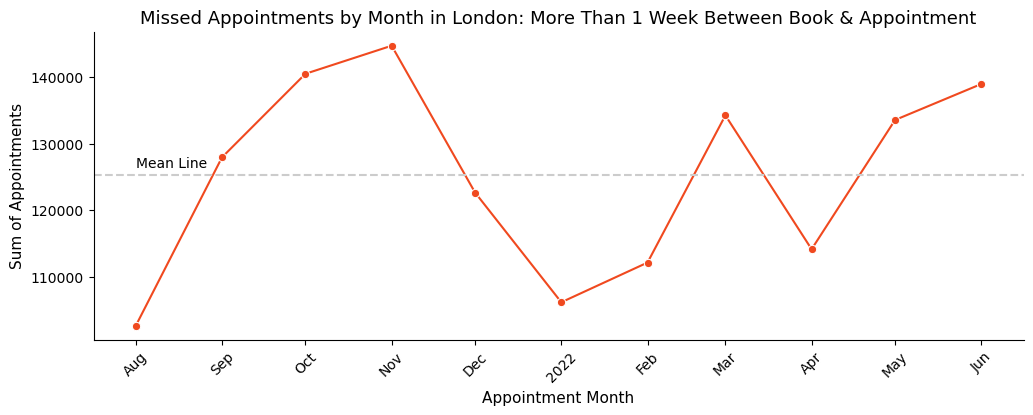

In [77]:
# Setup figure
fig, ax = plt.subplots(figsize=(12, 4))

# calcualte mean of the dataset
dna_mean = ar_subset_london_gt_week['count_of_appointments'].mean()

# format the x-axis date
major_locator = AutoDateLocator()
formatter = ConciseDateFormatter(major_locator)
ax.xaxis.set_major_formatter(formatter)

sns.lineplot(data=ar_subset_london_gt_week, x='appointment_date', \
             y='count_of_appointments', \
             marker="o",  linestyle="-", color='#f0491f')

# show the mean line for the dataset
ax.axhline(y=dna_mean, color='#CCCCCC', linestyle='--')
ax.text(ar_subset_london_gt_week['appointment_date'].min(), dna_mean+(dna_mean*0.01),'Mean Line')

# setup labels, ticks, spines and title
ax.set_xlabel(r'Appointment Month', size=11)
ax.set_ylabel(r'Sum of Appointments', size=11)
ax.ticklabel_format(style='plain', axis='y')
plt.xticks(rotation=45)
ax.tick_params(left=True, bottom=True)
sns.despine(left=False, bottom=False)
plt.title("Missed Appointments by Month in London: More Than 1 Week Between Book & Appointment", size=13)

# show chart
plt.show()

### 3. Create a map % of missed appointments by region

<div class="alert alert-block alert-danger">
<b>Important:</b> The shapefile must be on your local computer, and change the file location in the code below. The data can be downloaded the <a href="https://geoportal.statistics.gov.uk/datasets/ons::nhs-england-regions-july-2022-en-bfc-1/explore?location=52.750025%2C-2.489483%2C8.00&showTable=true" target="_blank">Government statistics website</a>.
</div>

In [15]:
# set the filepath and load in a shapefile
fp = "D:\\LSE\\Assignment 2\\region_shape_files\\NHSER_JUL_2022_EN_BFC.shp"
map_df = gpd.read_file(fp)

# check data type so we can see that this is not a normal dataframe, but a GEOdataframe
map_df.head()

NHSER22CD        NHSER22NM   BNG_E   BNG_N      LONG      LAT   
0  E40000003           London  517515  178392 -0.308660  51.4923  \
1  E40000005       South East  471724  171073 -0.969570  51.4341   
2  E40000006       South West  285015  102567 -3.633430  50.8112   
3  E40000007  East of England  565970  255923  0.425889  52.1766   
4  E40000010       North West  356889  444857 -2.657550  53.8981   

                               GlobalID   
0  0ed9266f-d879-4018-b6f4-93e9141d17c5  \
1  e65f164c-d972-4631-88ac-c4502d165b8f   
2  4c391736-de3a-4949-bfa1-28796fab96d4   
3  6b5f57d5-9882-48ca-bfe0-50bb8e40266c   
4  06dbe856-2d3b-478c-aaa5-205ab8e6ba43   

                                            geometry  
0  MULTIPOLYGON (((516122.679 172421.288, 516112....  
1  MULTIPOLYGON (((429043.995 84840.073, 429056.1...  
2  MULTIPOLYGON (((83962.840 5401.150, 83970.680 ...  
3  MULTIPOLYGON (((570605.060 181382.250, 570608....  
4  MULTIPOLYGON (((327869.488 373719.637, 327869....

In [11]:
# create pivot table of regions by appointment status
regions = pd.pivot_table(ar_subset_post_covid, values ='count_of_appointments',
    index =['region_ons_name'],
    columns =['appointment_status'], aggfunc=np.sum).reset_index()

# calculate % of missed appointments
regions['sum_of_appointments'] = regions['Attended'] + regions['DNA'] + regions['Unknown']
regions['percentage_of_dna'] = (regions['DNA']/regions['sum_of_appointments'])*100

regions.drop(['Attended', 'DNA', 'Unknown', 'sum_of_appointments'], axis=1, inplace=True)

regions.sort_values(by=['percentage_of_dna'], inplace=True)

In [13]:
# show head
regions.head(7)

appointment_status           region_ons_name  percentage_of_dna
0                            East of England           3.538586
6                                 South West           3.899142
3                   North East and Yorkshire           3.968299
5                                 South East           4.381434
2                                   Midlands           4.466896
1                                     London           5.536583
4                                 North West           5.600082

In [16]:
# merge geospatial data with the icb appointment data
merged = map_df.set_index('NHSER22NM').join(regions.set_index('region_ons_name')).reset_index()

merged.head()

NHSER22NM  NHSER22CD   BNG_E   BNG_N      LONG      LAT   
0           London  E40000003  517515  178392 -0.308660  51.4923  \
1       South East  E40000005  471724  171073 -0.969570  51.4341   
2       South West  E40000006  285015  102567 -3.633430  50.8112   
3  East of England  E40000007  565970  255923  0.425889  52.1766   
4       North West  E40000010  356889  444857 -2.657550  53.8981   

                               GlobalID   
0  0ed9266f-d879-4018-b6f4-93e9141d17c5  \
1  e65f164c-d972-4631-88ac-c4502d165b8f   
2  4c391736-de3a-4949-bfa1-28796fab96d4   
3  6b5f57d5-9882-48ca-bfe0-50bb8e40266c   
4  06dbe856-2d3b-478c-aaa5-205ab8e6ba43   

                                            geometry  percentage_of_dna  
0  MULTIPOLYGON (((516122.679 172421.288, 516112....           5.536583  
1  MULTIPOLYGON (((429043.995 84840.073, 429056.1...           4.381434  
2  MULTIPOLYGON (((83962.840 5401.150, 83970.680 ...           3.899142  
3  MULTIPOLYGON (((570605.060 181382.250, 570608....           3.538586  
4  MULTIPOLYGON (((327869.488 373719.637, 327869....           5.600082

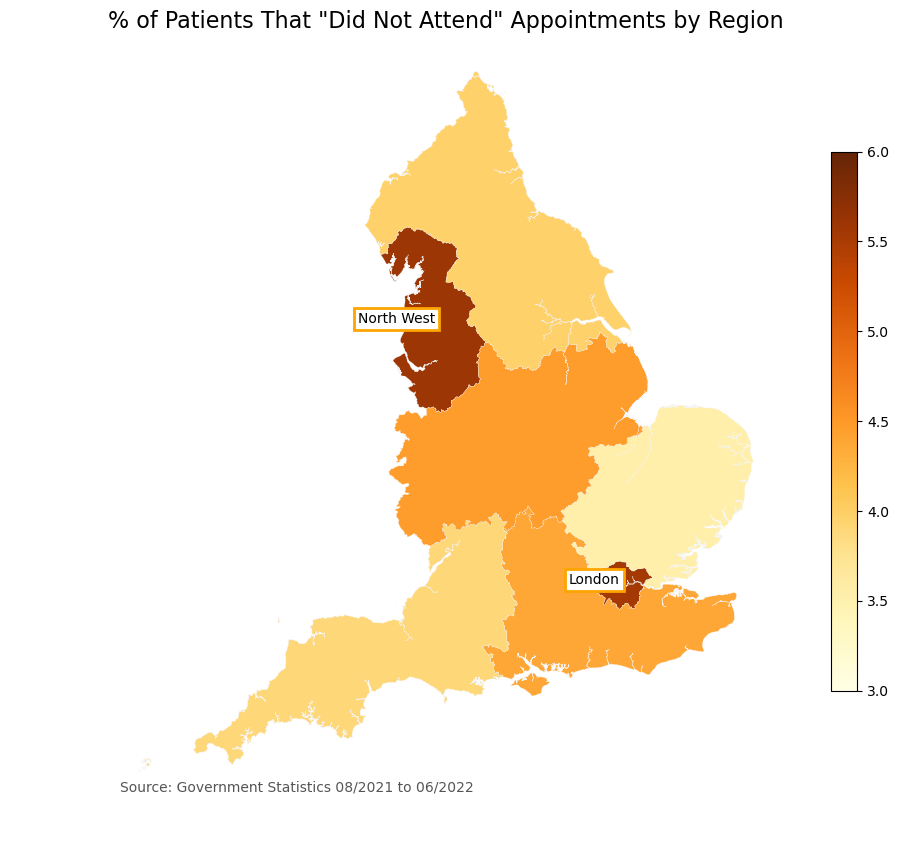

In [28]:
# set a variable that will call whatever column we want to visualise on the map
variable = 'percentage_of_dna'

# set the range for the choropleth
vmin, vmax = 3, 6

# create figure and axes for Matplotlib
fig, ax = plt.subplots(1, figsize=(12, 10))

# create map
merged.plot(column=variable, cmap='YlOrBr', linewidth=0.2, ax=ax, edgecolor='whitesmoke', \
            vmin=vmin, vmax=vmax, legend=True, legend_kwds={'shrink': 0.7})

# remove the axis
ax.axis('off')

# add a title
ax.set_title('% of Patients That "Did Not Attend" Appointments by Region', \
             fontdict={'fontsize': '16', 'fontweight' : '2'})

# create an annotation for the data source
ax.annotate('Source: Government Statistics 08/2021 to 06/2022', xy=(0.1, .08), \
            xycoords='figure fraction', horizontalalignment='left', \
            verticalalignment='top', fontsize=10, color='#555555')

for x in merged.index:
    if merged['percentage_of_dna'][x] > 5:
        ax.annotate(text=merged['NHSER22NM'][x], 
        xy=merged.geometry[x].centroid.coords[0], 
        ha='right', color='black',
        bbox=dict(boxstyle="square,pad=0.3", fc="white", ec="orange", lw=2))
        
fig.savefig('region_map_export.png', dpi=300)